# PPRS: results, analyses, & plots

In [1]:
import os
from os.path import join
from glob import glob
import pandas as pd
import numpy as np
from IPython import display
from nilearn.image import load_img, math_img, threshold_img
from nilearn.plotting import plot_design_matrix, plot_glass_brain, find_parcellation_cut_coords, plot_stat_map
from nilearn.glm.second_level import SecondLevelModel, non_parametric_inference
from nilearn.reporting import get_clusters_table
from nilearn.maskers import NiftiLabelsMasker
from sklearn.preprocessing import minmax_scale
import statsmodels.formula.api as smf
from scipy import stats
from pingouin import compute_effsize, ancova, pairwise_tests
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import get_cmap
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from atlasreader import get_statmap_info
import seaborn as sns

from utils_image import index_clusters_bin

from abagen import get_expression_data
from nilearn.input_data import NiftiLabelsMasker
from utils_image import parcel_data_to_volume
import sys
sys.path.append(os.path.dirname("/Users/llotter/projects/juspyce/juspyce"))
from juspyce.api import JuSpyce
from juspyce.stats import corr, residuals, mc_correction

wd = "/Users/llotter/projects/pprs"

def na():
    return slice(None)

/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


## Data

### Dataset

In [2]:
tps = ["T0", "T1", "T2", "T3", "T4", "T5"]
    
# load processed dataset
data_all = pd.read_csv(join(wd, "pheno", "pprs_pheno_mri_proc.csv"))
data_all = data_all.set_index(["ID", "tp", "group_str"], drop=False)
data_all.index.names = ["idx_id", "idx_tp", "idx_group"]

# load additional test scores
data_scores = pd.read_csv(join(wd, "pheno", "pprs_pheno_mri_scores.csv"))
data_scores = data_scores.set_index(["id", "tp"])
data_scores.index.names = ["idx_id", "idx_tp"]

# merge
data_all = data_all.merge(data_scores, left_index=True, right_index=True, how="left", suffixes=["", "_DROP"])
data_all = data_all[[c for c in data_all.columns if not c.endswith("_DROP")]]

# print numbers
def print_numbers(data, tp):
    print(f"TP {tp}: PP = {len(data[(data.group_str=='PP') & (data.tp==tp)])}, "
          f"NP = {len(data[(data.group_str=='NP') & (data.tp==tp)])}")

print("Original dataset")
for tp in tps:
    print_numbers(data_all, tp)
    
# exclude sessions with reconstruction problem
data = data_all.copy()
data = data[~((data.ID=="sub-002PP") & (data.tp=="T4"))]
    
# apply motion cutoff
data = data[(data.fwd_mean <= 0.5) & (data.fwd_max <= 3)]

# print numbers
print("After motion cutoff")
for tp in tps:
    print_numbers(data, tp)
n = data.shape[0]
n_pp = len(data[data.group_str=="PP"])
n_np = len(data[data.group_str=="NP"])

# new variables
data["weeks_postpartal"] = data.days_since_delivery / 7
data["ep_ratio"] = data.estradiol / data.progesterone
for horm in ["estradiol", "progesterone", "ep_ratio"]:
    data[horm+"_log"] = np.log(data[horm])

# sort variables
data.contraception = pd.Categorical(data.contraception.replace({1:"yes", 0:"no"}))
data.baby_blues = pd.Categorical(data.baby_blues.replace({1:"yes", 0:"no"}))
data.breastfeeding = pd.Categorical(data.breastfeeding.replace({1:"yes", 0:"no"}))
data.n_children = data.n_children.astype(float).astype('Int64')
data = data.rename(columns={
    "nbs_falff_path":"falff_path",
    "nbs_gcor_path":"gcor_path",
    "nbs_lcor_path":"lcor_path"
})

Original dataset
TP T0: PP = 76, NP = 23
TP T1: PP = 19, NP = 0
TP T2: PP = 18, NP = 0
TP T3: PP = 19, NP = 0
TP T4: PP = 19, NP = 0
TP T5: PP = 17, NP = 0
After motion cutoff
TP T0: PP = 75, NP = 23
TP T1: PP = 19, NP = 0
TP T2: PP = 18, NP = 0
TP T3: PP = 19, NP = 0
TP T4: PP = 18, NP = 0
TP T5: PP = 17, NP = 0


#### Subject lists

In [3]:
subs_alltps = [sub for sub in data.ID.unique() if data.loc[(sub,),:].shape[0]==6]
subs_NP = data.loc[(na(),na(),"NP")].ID.unique().tolist()
subs_PP = data.loc[(na(),na(),"PP")].ID.unique().tolist()
subs_PP_long = [sub for sub in data.ID.unique() if data.loc[(sub,),:].shape[0]>1]
subs_PP_onlybl = [sub for sub in data.loc[(na(),na(),"PP")].ID.unique() if data.loc[(sub,),:].shape[0]==1]

# new variable with cross vs long subjects
data["group_crosslong_str"] = data.group_str.copy()
data.loc[(subs_PP_long, na(), "PP"), "group_crosslong_str"] = "PP-long"
data.loc[(subs_PP_onlybl, na(), "PP"), "group_crosslong_str"] = "PP-cross"

### Templates

In [4]:
# brain mask
mask_brain = load_img(join(wd, "templates", "maskbrain_mni152_3mm.nii"))

# gm mask
mask_gm = load_img(join(wd, "templates", "maskgm_mni152_3mm.nii"))

# gm probability
tpm_gm = load_img(join(wd, "templates", "gmprob_mni152_1mm.nii.gz"))

# parcellation
parc = load_img(join(wd, "templates", "parc_schaefer100-7-tianS1_3mm.nii"))
# parcellation info
parc_xyz, parc_idc = find_parcellation_cut_coords(parc, return_label_names=True)
parc_labels = pd.read_csv(join(wd, "templates", "parc_schaefer100-7-tianS1_3mm.txt"), header=None)[0].to_list()
parc_n = len(parc_idc)
parc_info = pd.DataFrame({
    "idx": parc_idc,
    "label": parc_labels,
    "x": parc_xyz[:, 0],
    "y": parc_xyz[:, 1],
    "z": parc_xyz[:, 2]
})

# analysis mask
mask = math_img("parc != 0", parc=parc)

## Analyses: demographics

### Cross-sectional: Continuous data

In [5]:
vars = ["age", "edu", "fwd_mean", "fwd_max", "weeks_postpartal", "gestation_day", "baby_weight", "epds"]
vars_desc = ["count", "mean", "std", "min", "50%", "max"]

dem_data = []
for name, idc in zip(["Nulliparous (NP)", "Postpartum, all (PP)", "Postpartum, cross-sectional", "Postpartum, longitudinal"], 
                     [data.group_str=="NP", 
                      (data.group_str=="PP") & (data.tp=="T0"), 
                      data.group_crosslong_str=="PP-cross", 
                      (data.group_crosslong_str=="PP-long") & (data.tp=="T0")]):
    dem_data.append(
        data.loc[idc, vars].describe().T[vars_desc].rename(columns=dict(zip(vars_desc, [(name, v) for v in vars_desc]))).round(2)
    )
dem_data = pd.concat(dem_data, axis=1)

# analyses
for var in vars:
    for name, idc in zip(["MWU-test: NP vs. PP",
                          "MWU-test: PP-cross vs. PP-long"],
                         [[data.group_str=="NP", (data.group_str=="PP") & (data.tp=="T0")],
                          [data.group_crosslong_str=="PP-cross", (data.group_crosslong_str=="PP-long") & (data.tp=="T0")]]):
        try:
            mwu = stats.mannwhitneyu(
                x=data.loc[idc[0], var].dropna(),
                y=data.loc[idc[1], var].dropna(),
            )
            dem_data.loc[var, (name, "U")] = np.round(mwu[0], 2)
            dem_data.loc[var, (name, "p")] = np.round(mwu[1], 3)
        except:
            pass

dem_data.columns = pd.MultiIndex.from_tuples(dem_data.columns)
dem_data = pd.concat(
    [dem_data.loc[:, (c, na())] 
     for c in ["Nulliparous (NP)", "Postpartum, all (PP)", "MWU-test: NP vs. PP", 
               "Postpartum, cross-sectional", "Postpartum, longitudinal", "MWU-test: PP-cross vs. PP-long"]], 
    axis=1
)
dem_data = dem_data.rename(index={
    "age":"Age", 
    "edu":"Education", 
    "fwd_mean":"Mean FWD", 
    "fwd_max":"Max FWD",
    "weeks_postpartal":"Weeks postpartum",
    "gestation_day": "Gestation day",
    "baby_weight":"Weight of baby",
    "epds": "EPDS"
})

# save
dem_data.to_csv(join(wd, "tables", "demographics_cross1.csv"))
dem_data.to_html(join(wd, "tables", "demographics_cross1.html"))
dem_data

Nulliparous (NP)                                    \
                            count   mean   std    min    50%    max   
Age                          23.0  28.04  4.91  20.00  28.00  36.00   
Education                    19.0   3.53  0.51   3.00   4.00   4.00   
Mean FWD                     23.0   0.16  0.04   0.09   0.17   0.25   
Max FWD                      23.0   0.54  0.27   0.19   0.44   1.38   
Weeks postpartum              0.0    NaN   NaN    NaN    NaN    NaN   
Gestation day                 0.0    NaN   NaN    NaN    NaN    NaN   
Weight of baby                0.0    NaN   NaN    NaN    NaN    NaN   
EPDS                          0.0    NaN   NaN    NaN    NaN    NaN   

                 Postpartum, all (PP)                            ...  \
                                count     mean     std      min  ...   
Age                              75.0    30.52    3.54    21.00  ...   
Education                        73.0     3.38    0.92     0.00  ...   
Mean FWD                         75.0     0.18    0.08     0.05  ...   
Max FWD                          75.0     0.69    0.40     0.17  ...   
Weeks postpartum                 75.0     0.49    0.29     0.14  ...   
Gestation day                    75.0   274.85   11.83   238.00  ...   
Weight of baby                   75.0  3250.20  474.50  2050.00  ...   
EPDS                             75.0     4.21    3.21     0.00  ...   

                 Postpartum, cross-sectional           \
                                         50%      max   
Age                                    30.00    36.00   
Education                               3.00     4.00   
Mean FWD                                0.16     0.40   
Max FWD                                 0.66     2.06   
Weeks postpartum                        0.29     0.57   
Gestation day                         278.50   294.00   
Weight of baby                       3285.00  4290.00   
EPDS                                    3.00    10.00   

                 Postpartum, longitudinal                                     \
                                    count     mean     std      min      50%   
Age                                  19.0    32.68    3.56    25.00    33.00   
Education                            19.0     3.74    0.87     2.00     4.00   
Mean FWD                             19.0     0.15    0.06     0.05     0.16   
Max FWD                              19.0     0.52    0.33     0.18     0.46   
Weeks postpartum                     19.0     0.86    0.32     0.29     0.86   
Gestation day                        19.0   272.21   12.33   247.00   274.00   
Weight of baby                       19.0  3147.63  576.24  2050.00  3280.00   
EPDS                                 19.0     6.37    4.00     0.00     7.00   

                          MWU-test: PP-cross vs. PP-long         
                      max                              U      p  
Age                 39.00                          292.0  0.003  
Education            5.00                          371.0  0.053  
Mean FWD             0.24                          610.0  0.345  
Max FWD              1.72                          759.0  0.006  
Weeks postpartum     1.43                           80.0  0.000  
Gestation day      289.00                          627.0  0.249  
Weight of baby    4000.00                          575.5  0.600  
EPDS                12.00                          312.0  0.007  

[8 rows x 28 columns]

### Cross-sectional: Discrete data

In [6]:
vars = ["ethnicity", "baby_blues", "baby_sex_str", "birth_mode_str", "breastfeeding", "n_children", "contraception"]

dem_data_disc = []
for var in vars:
    for temp in [data.loc[(na(), "T0", na()), :].groupby(["group_str", var])[var].count(),
                 data.loc[(na(), "T0", "PP"), :].groupby(["group_crosslong_str", var])[var].count()]:
        dem_data_disc.append(
            temp \
                .to_frame() \
                .rename(columns={var: "Count"}) \
                .reset_index(drop=False) \
                .rename(columns={"group_str": "Group", "group_crosslong_str": "Group", var: "Category"}) \
                .assign(Variable=var) 
            )
dem_data_disc = pd.concat(dem_data_disc)
dem_data_disc = dem_data_disc.pivot(columns=["Group"], index=["Variable", "Category"])
dem_data_disc.loc[(["baby_blues", "breastfeeding"], na()), ("Count", "NP")] = np.nan
dem_data_disc.loc[("ethnicity", na()), :] = dem_data_disc.loc[("ethnicity", na()), :].replace({np.nan: 0})
dem_data_disc.loc[("ethnicity", na()), ("Count", "PP-long")] = np.nan
for var in ["baby_blues", "baby_sex_str", "birth_mode_str", "breastfeeding", "n_children"]:
    temp = dem_data_disc.loc[var, (na(), ["PP-cross", "PP-long"])]  
    # if var == "birth_mode_str":
    #     temp = pd.DataFrame({"section": temp.loc[["emergency", "section"], :].sum(),
    #                          "spontaneous": temp.loc[["spontaneous", "ventouse"], :].sum()}).T
    chi2 = stats.chi2_contingency(temp)
    dem_data_disc.loc[(var, na()), ("Chi2-test: PP-cross vs. PP-long", "Chi2")] = chi2[0].round(2)
    dem_data_disc.loc[(var, na()), ("Chi2-test: PP-cross vs. PP-long", "df")] = chi2[2]
    dem_data_disc.loc[(var, na()), ("Chi2-test: PP-cross vs. PP-long", "p")] = chi2[1].round(3)

temp = {
        "ethnicity": "Country of origin",
        "baby_blues": "Baby blues",
        "baby_sex_str": "Sex of baby",
        "birth_mode_str": "Birth mode",
        "breastfeeding": "Breastfeeding",
        "n_children": "Number of children",
        "Deutschland": "Germany",
        "deutschland": "Germany",
        "Bulgarien": "Bulgaria",
        "Italien": "Italy",
        "Schweiz": "Switzerland",
        "Belgien": "Belgium",
        "Niederlande": "Netherlands",
        "Polen": "Poland",
        "Russland": "Russia",
        "Frankreich": "France",
        "Slowakei": "Slovakia",
        "Spanien": "Spain",
        "Litauen": "Lithuania",
        "Tadschikistan": "Tajikistan",
        "f": "female",
        "m": "male",
        "NP": "Nulliparous (NP)", 
        "PP": "Postpartum (PP)",
        "PP-cross": "PP, cross-sectional",
        "PP-long": "PP, longitudinal",
        "contraception": "Contraception"
}
dem_data_disc.index = pd.MultiIndex.from_tuples(
    [(temp[v] if v in temp else v, temp[c] if c in temp else c) for v, c in dem_data_disc.index],
    names=dem_data_disc.index.names
)
dem_data_disc.columns = pd.MultiIndex.from_tuples(
    [(v, temp[c] if c in temp else c) for v, c in dem_data_disc.columns],
)

# save
dem_data_disc.to_csv(join(wd, "tables", "demographics_cross2.csv"))
dem_data_disc.to_html(join(wd, "tables", "demographics_cross2.html"))
dem_data_disc

Count                  \
                                 Nulliparous (NP) Postpartum (PP)   
Variable           Category                                         
Baby blues         no                         NaN            37.0   
                   yes                        NaN            38.0   
Sex of baby        female                     NaN            35.0   
                   male                       NaN            40.0   
Birth mode         emergency                  NaN             6.0   
                   section                    NaN            19.0   
                   spontaneous                NaN            47.0   
                   ventouse                   NaN             3.0   
Breastfeeding      no                         NaN             9.0   
                   yes                        NaN            66.0   
Contraception      no                        15.0             0.0   
                   yes                        4.0             0.0   
Country of origin  Belgium                    0.0             1.0   
                   Bulgaria                   1.0             0.0   
                   China                      1.0             0.0   
                   Germany                   13.0            45.0   
                   France                     1.0             0.0   
                   Iran                       1.0             0.0   
                   Italy                      1.0             0.0   
                   Liberia/Ghana              0.0             1.0   
                   Lithuania                  0.0             1.0   
                   Netherlands                0.0             1.0   
                   Poland                     0.0             2.0   
                   Russia                     0.0             1.0   
                   Switzerland                1.0             0.0   
                   Slovakia                   0.0             1.0   
                   Spain                      0.0             1.0   
                   Tajikistan                 0.0             1.0   
                   Germany                    0.0             1.0   
Number of children 1                          NaN            50.0   
                   2                          NaN            23.0   
                   3                          NaN             2.0   

                                                                       \
                                 PP, cross-sectional PP, longitudinal   
Variable           Category                                             
Baby blues         no                           26.0             11.0   
                   yes                          30.0              8.0   
Sex of baby        female                       26.0              9.0   
                   male                         30.0             10.0   
Birth mode         emergency                     4.0              2.0   
                   section                       9.0             10.0   
                   spontaneous                  41.0              6.0   
                   ventouse                      2.0              1.0   
Breastfeeding      no                            8.0              1.0   
                   yes                          48.0             18.0   
Contraception      no                            0.0              0.0   
                   yes                           0.0              0.0   
Country of origin  Belgium                       1.0              NaN   
                   Bulgaria                      0.0              NaN   
                   China                         0.0              NaN   
                   Germany                      45.0              NaN   
                   France                        0.0              NaN   
                   Iran                          0.0              NaN   
                   Italy                         0.0              NaN   
                   Lib

### Longitudinal: Continuous Data

In [7]:
vars = ["weeks_postpartal", 
        "epds",  "mpas", "mpas_attachment", "mpas_hostility", "mpas_interaction",
        "estradiol", "estradiol_log", "progesterone", "progesterone_log", "ep_ratio", "ep_ratio_log",
        "fwd_mean", "fwd_max"]

# demographic & motion data
dem_data_long = {}
for var in vars:
    print(var)
    data_desc = data.loc[(subs_PP_long, na(), "PP"),:].groupby("idx_tp")[var].describe()[["count", "mean", "std"]]
    data_desc = pd.concat(
        [data_desc.loc[tp] for tp in tps], 
        axis="index", 
        keys=[f"Postpartum (PP): {tp}" for tp in tps]
    ).round(2)
    dem_data_long[var] = data_desc
    # calculate LMM 
    if var!= "weeks_postpartal":
        
        temp = data.loc[(subs_PP_long, na(), "PP"), [var, "weeks_postpartal", "ID"]].dropna()
        
        lmm = smf.mixedlm(f"{var} ~ weeks_postpartal", groups="ID", data=temp).fit()
        lmm2 = smf.mixedlm(f"{var} ~ weeks_postpartal + np.square(weeks_postpartal)", groups="ID", data=temp).fit()
        
        data_desc[("LMM", "df")] = f"{(lmm.df_modelwc, lmm.df_resid)}"
        data_desc[("Weeks PP", "converged")] = lmm.converged
        data_desc[("Weeks PP", "coef")] = lmm.params["weeks_postpartal"].round(3)
        data_desc[("Weeks PP", "p")] = lmm.pvalues["weeks_postpartal"].round(3)
        data_desc[("Weeks PP^2", "converged")] = lmm2.converged
        data_desc[("Weeks PP^2", "coef")] = lmm2.params["np.square(weeks_postpartal)"].round(3)
        data_desc[("Weeks PP^2", "p")] = lmm2.pvalues["np.square(weeks_postpartal)"].round(3)
dem_data_long = pd.DataFrame(dem_data_long) \
    .round(2) \
    .T
dem_data_long = pd.concat([
    dem_data_long.iloc[:,1:-6], 
    dem_data_long.iloc[:,0], 
    dem_data_long.iloc[:,-5], dem_data_long.iloc[:,-6], dem_data_long.iloc[:,-4],
    dem_data_long.iloc[:,-2], dem_data_long.iloc[:,-3], dem_data_long.iloc[:,-1]
], axis=1)

# rename variables  
dem_data_long = dem_data_long.rename(index={
    "age":"Age", 
    "mpas":"MPAS - total",
    "mpas_attachment": "MPAS - attachment", 
    "mpas_hostility": "MPAS - hostility", 
    "mpas_interaction": "MPAS - interaction",
    "epds":"EPDS",
    "weeks_postpartal":"Weeks postpartum",
    "estradiol": "Estradiol", 
    "estradiol_log": "log(Estradiol)",
    "progesterone": "Progesterone", 
    "progesterone_log": "log(Progesterone)", 
    "ep_ratio": "Estradiol/Progesterone", 
    "ep_ratio_log": "log(Estradiol/Progesterone)",
    "fwd_mean":"Mean FWD", 
    "fwd_max":"Max FWD",
})

# save
dem_data_long.to_csv(join(wd, "tables", "demographics_long1.csv"))
dem_data_long.to_html(join(wd, "tables", "demographics_long1.html"))
dem_data_long

weeks_postpartal
epds
mpas
mpas_attachment
mpas_hostility
mpas_interaction
estradiol
estradiol_log
progesterone
progesterone_log
ep_ratio


/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceW

ep_ratio_log
fwd_mean
fwd_max


/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Postpartum (PP): T0                 \
                                          count   mean     std   
Weeks postpartum                           19.0   0.86    0.32   
EPDS                                       19.0   6.37     4.0   
MPAS - total                                0.0    NaN     NaN   
MPAS - attachment                           0.0    NaN     NaN   
MPAS - hostility                            0.0    NaN     NaN   
MPAS - interaction                          0.0    NaN     NaN   
Estradiol                                  19.0  41.63   45.45   
log(Estradiol)                             19.0   3.26    1.03   
Progesterone                               19.0   0.91    1.47   
log(Progesterone)                          19.0  -0.91    1.28   
Estradiol/Progesterone                     19.0  99.78  100.71   
log(Estradiol/Progesterone)                19.0   4.17    0.99   
Mean FWD                                   19.0   0.15    0.06   
Max FWD                                    19.0   0.52    0.33   

                            Postpartum (PP): T1                  \
                                          count    mean     std   
Weeks postpartum                           19.0     3.2    0.36   
EPDS                                       19.0    6.42    4.99   
MPAS - total                               19.0   81.32   10.25   
MPAS - attachment                          19.0   41.21    4.33   
MPAS - hostility                           19.0   18.74    3.25   
MPAS - interaction                         19.0   21.37     3.8   
Estradiol                                  19.0   58.43   85.74   
log(Estradiol)                             19.0    3.32    1.25   
Progesterone                               19.0    0.12    0.08   
log(Progesterone)                          19.0   -2.36    0.69   
Estradiol/Progesterone                     19.0  512.53  579.35   
log(Estradiol/Progesterone)                19.0    5.68    1.11   
Mean FWD                                   19.0    0.16    0.07   
Max FWD                                    19.0    0.62    0.29   

                            Postpartum (PP): T2                  \
                                          count    mean     std   
Weeks postpartum                           18.0    6.23    0.45   
EPDS                                       18.0    5.33    3.68   
MPAS - total                               18.0   83.61    8.29   
MPAS - attachment                          18.0   42.06    3.61   
MPAS - hostility                           18.0   19.89    2.78   
MPAS - interaction                         18.0   21.67    3.41   
Estradiol                                  18.0   39.81   59.44   
log(Estradiol)                             18.0    2.98    1.18   
Progesterone                               18.0     0.1    0.09   
log(Progesterone)                          18.0   -2.56    0.62   
Estradiol/Progesterone                     18.0  409.66  449.96   
log(Estradiol/Progesterone)                18.0    5.53    1.01   
Mean FWD                                   18.0    0.18    0.08   
Max FWD                                    18.0    0.74    0.35   

                            Postpartum (PP): T3  ... Postpartum (PP): T5  \
                                          count  ...               count   
Weeks postpartum                           19.0  ...                17.0   
EPDS                                       19.0  ...                13.0   
MPAS - total                               19.0  ...                13.0   
MPAS - attachment                          19.0  ...                13.0   
MPAS - hostility                           19.0  ...                13.0   
MPAS - interaction                         19.0  ...                13.0   
Estradiol                                  18.0  ...                16.0   
log(Estradiol)                             18.0  ...                16.0   
Progesterone                               18.0  ...             

## 2nd level cross-sectional MRI analyses

#### General analysis settings

In [8]:
# rerun analyses?
rerun_sec_lev = False

# settings
vox_thresh = 0.01
cl_thresh = -np.log10(0.05)
cl_inference = "mass"
n_perm = 10000

#### Inspect stored data paths

In [9]:
for sub in ["sub-001PP", "sub-040PP"]:
    for c in ["swu_rest_path", "wu_rest_path", "falff_path", "lcor_path", "gcor_path"]:
        for tp in data.loc[(sub,na(),na()), "tp"]:
            temp = data.loc[(sub,tp,na()), c]
            print(sub, tp, c, temp.values[0])

sub-001PP T0 swu_rest_path /Volumes/ext/data/pprs/conn_long/conn_pprs/data/BIDS/dataset/sub-0001/func/swusub-0001_run-01_bold.nii
sub-001PP T1 swu_rest_path /Volumes/ext/data/pprs/conn_long/conn_pprs/data/BIDS/dataset/sub-0001/func/swusub-0001_run-02_bold.nii
sub-001PP T2 swu_rest_path /Volumes/ext/data/pprs/conn_long/conn_pprs/data/BIDS/dataset/sub-0001/func/swusub-0001_run-03_bold.nii
sub-001PP T3 swu_rest_path /Volumes/ext/data/pprs/conn_long/conn_pprs/data/BIDS/dataset/sub-0001/func/swusub-0001_run-04_bold.nii
sub-001PP T4 swu_rest_path /Volumes/ext/data/pprs/conn_long/conn_pprs/data/BIDS/dataset/sub-0001/func/swusub-0001_run-05_bold.nii
sub-001PP T0 wu_rest_path /Volumes/ext/data/pprs/conn_long/conn_pprs/data/BIDS/dataset/sub-0001/func/wusub-0001_run-01_bold.nii
sub-001PP T1 wu_rest_path /Volumes/ext/data/pprs/conn_long/conn_pprs/data/BIDS/dataset/sub-0001/func/wusub-0001_run-02_bold.nii
sub-001PP T2 wu_rest_path /Volumes/ext/data/pprs/conn_long/conn_pprs/data/BIDS/dataset/sub-000

### Voxel-wise measures

#### Prepare model

N = 98 subjects


<AxesSubplot:label='conditions', ylabel='scan number'>

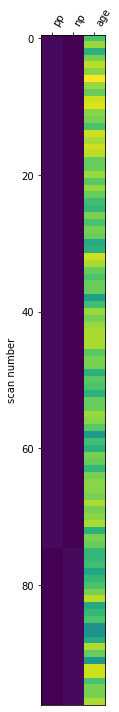

In [10]:
sec_lev_desi = pd.DataFrame({
    "pp": (data.loc[(na(),"T0",na()),:].group_str == "PP").astype(int),
    "np": (data.loc[(na(),"T0",na()),:].group_str == "NP").astype(int),
    "age": data.loc[(na(),"T0",na()),:].age
})

print(f"N = {data.loc[(na(),'T0',na()),:].shape[0]} subjects")
plot_design_matrix(sec_lev_desi, rescale=False)

#### Estimate

In [11]:
def run_2nd_level(data, contrast_par, contrast_nonpar, design=sec_lev_desi, 
                  vox_thresh=vox_thresh, cl_thresh=cl_thresh, cl_inference=cl_inference,
                  save_dir=wd, save_prefix="",
                  mask=mask, n_perm=n_perm, n_jobs=8, seed=42,
                  plot=True, cmap="cold_white_hot", title=""):
    # load data
    data = [load_img(d) for d in data]

    # fit 2nd level model
    sec_lev = SecondLevelModel(
        mask_img=mask,
        smoothing_fwhm=None, 
        n_jobs=n_jobs).fit(
            second_level_input=data,
            design_matrix=design,
        )

    # parametric
    sec_lev_par = sec_lev.compute_contrast(
        second_level_contrast=contrast_par,
        output_type="all")
    
    # non-parametric
    sec_lev_nonpar = non_parametric_inference(
        second_level_input=data,
        design_matrix=design,
        second_level_contrast=contrast_nonpar,
        mask=mask,
        model_intercept=True,
        n_perm=n_perm,
        two_sided_test=False,
        smoothing_fwhm=None,
        n_jobs=n_jobs,
        random_state=seed,
        threshold=vox_thresh
    )
    
    # extract and save results maps
    maps = {}
    maps["map_par_effectsize"] = sec_lev_par["effect_size"]
    maps["map_par_stat"] = sec_lev_par["stat"]
    maps["map_par_logp"] = math_img("-np.log10(i)", i=sec_lev_par["p_value"])
    maps["map_nonpar_logp"] = sec_lev_nonpar[f"logp_max_{cl_inference}"]
    cl_sig = (maps["map_nonpar_logp"].get_fdata() > cl_thresh).any()
    if cl_sig:
        maps["map_nonpar_bin"] = math_img(f"i > {cl_thresh}", i=maps["map_nonpar_logp"])
        maps["map_nonpar_idx"], _, cl_sizes = index_clusters_bin(maps["map_nonpar_bin"])
        print(f"{cl_sizes.shape[0]} significant cluster(s) detected.")
    else:
        print("No significant clusters detected.")
    for m in maps:
        maps[m].to_filename(join(save_dir, f"{save_prefix}{m}.nii.gz"))
    
    # plot con1
    if plot:
        gb = plot_glass_brain(
            maps["map_par_logp"], 
            display_mode = "lzry",
            colorbar=True, 
            cmap=cmap,
            title=title
        )
        if cl_sig:
            gb.add_contours(
                img=maps["map_nonpar_logp"], 
                levels=[cl_thresh], 
                colors="k", 
            )
            gb.add_overlay(
                img=maps["map_nonpar_idx"],
                cmap="tab10",
                alpha=0.8
            )
        plt.show()
    
    # return
    return maps

In [13]:
# iterate voxe-wise measures
sec_level_res = {}

for measure in ["falff", "lcor", "gcor"]:
    print(measure)
    sec_level_res[measure] = {}
    
    # RERUN
    if rerun_sec_lev:
        # get data files
        vols = [load_img(d) for d in data.loc[(na(),"T0",na()), measure + "_path"].to_list()]
        
        # con1
        print("con1")
        sec_level_res[measure]["con1"] = run_2nd_level(
            data=vols,
            contrast_par=np.array([1, -1, 0]),
            contrast_nonpar=np.array([1, 0, 0]),
            save_dir=join(wd, "results"),
            save_prefix=f"{measure}_con1_",
            cmap="cold_white_hot", 
            title=f"{measure}: PP > NP [-lg(p)]"
        )
        
        # con2
        print("con2")
        sec_level_res[measure]["con2"] = run_2nd_level(
            data=vols,
            contrast_par=np.array([-1, 1, 0]),
            contrast_nonpar=np.array([0, 1, 0]),
            save_dir=join(wd, "results"),
            save_prefix=f"{measure}_con2_",
            cmap="cold_white_hot_r", 
            title=f"{measure}: PP < NP [-lg(p)]"
        )
    
    else:
        # NOT RERUN, JUST LOAD SAVED FILES
        for con in ["con1", "con2"]:
            sec_level_res[measure][con] = {}
            for file in glob(join(wd, "results", f"{measure}_{con}_*.nii.gz")):
                name = os.path.basename(file).replace(f"{measure}_{con}_", "").replace(".nii.gz", "")
                sec_level_res[measure][con][name] = load_img(file)

# show results dict
sec_level_res

falff
lcor
gcor


{'falff': {'con1': {'map_par_stat': <nibabel.nifti1.Nifti1Image at 0x7fda302554f0>,
   'map_nonpar_bin': <nibabel.nifti1.Nifti1Image at 0x7fda302571f0>,
   'map_par_logp': <nibabel.nifti1.Nifti1Image at 0x7fda30255340>,
   'map_nonpar_logp': <nibabel.nifti1.Nifti1Image at 0x7fda30251e80>,
   'map_nonpar_idx': <nibabel.nifti1.Nifti1Image at 0x7fda30251f40>,
   'map_par_effectsize': <nibabel.nifti1.Nifti1Image at 0x7fda61a9a8b0>},
  'con2': {'map_par_stat': <nibabel.nifti1.Nifti1Image at 0x7fda61a9a760>,
   'map_nonpar_logp': <nibabel.nifti1.Nifti1Image at 0x7fda61a9aac0>,
   'map_par_logp': <nibabel.nifti1.Nifti1Image at 0x7fda61a9a940>,
   'map_nonpar_idx': <nibabel.nifti1.Nifti1Image at 0x7fda61cf0ee0>,
   'map_par_effectsize': <nibabel.nifti1.Nifti1Image at 0x7fda61a98910>,
   'map_nonpar_bin': <nibabel.nifti1.Nifti1Image at 0x7fda61a9b3d0>}},
 'lcor': {'con1': {'map_par_logp': <nibabel.nifti1.Nifti1Image at 0x7fda61a9b4f0>,
   'map_nonpar_logp': <nibabel.nifti1.Nifti1Image at 0x7fda

## 2nd level longitudinal MRI analyses

In [14]:
rerun_sec_lev_long = False

In [15]:
sec_level_res_long = dict()

for measure in ["falff", "lcor", "gcor"]:
    print(measure)
    sec_level_res_long[measure] = dict()
    
    if rerun_sec_lev_long:
        
        for var in ["", "progesterone_log", "estradiol_log", "ep_ratio_log", 
                    "epds",  "mpas", "mpas_attachment", "mpas_hostility", "mpas_interaction"]:
            
                vars = ["age", "weeks_postpartal"]
                if var != "":
                    vars += [var]
                    
                sec_lev_desi_long = data.loc[(subs_PP_long, na(), "PP"), vars].copy().dropna()
                
                for sub in subs_PP_long:
                    sec_lev_desi_long[sub] = 0
                    for tp in sec_lev_desi_long.loc[(sub, na(), "PP"), :].index.get_level_values("idx_tp"):        
                        sec_lev_desi_long.loc[(sub, tp, "PP"), sub] = 1
                    if var != "":
                        temp = sec_lev_desi_long.loc[(sub, na(), "PP"), var]
                        if len(temp.unique()) == 1:
                            temp = temp - temp.mean()
                        else:
                            temp = (temp - temp.mean()) / temp.std()
                        if temp.isna().any():
                            print(f"na values for subject {sub}:", temp)
                        sec_lev_desi_long.loc[(sub, na(), "PP"), var] = temp
                        
                if var != "":
                    sec_lev_desi_long[var] = (sec_lev_desi_long[var] - sec_lev_desi_long[var].mean()) / sec_lev_desi_long[var].std()
                    sec_lev_desi_long[f"{var}*weeks_postpartal"] = sec_lev_desi_long[var] * sec_lev_desi_long["weeks_postpartal"]
                    contrast = f"{var}*weeks_postpartal"
                else:
                    contrast = "weeks_postpartal"
                print(contrast)
                # plot_design_matrix(sec_lev_desi_long, rescale=True)
                # plt.show()
        
                sec_lev = SecondLevelModel(
                    mask_img=mask,
                    smoothing_fwhm=None, 
                    n_jobs=-1
                ).fit(
                    second_level_input=[load_img(d) for d in data.loc[sec_lev_desi_long.index, f"{measure}_path"].to_list()],
                    design_matrix=sec_lev_desi_long,
                )
                    
                res = sec_lev.compute_contrast(
                    contrast, output_type="all"
                )
                
                sec_level_res_long[measure][contrast] = res["effect_size"]
                res["effect_size"].to_filename(join(wd, "results", f"{measure}_long_{contrast}.nii.gz"))

                plot_glass_brain(
                    res["effect_size"], 
                    display_mode="lzry",
                    colorbar=True, 
                    cmap="RdBu_r",
                    plot_abs=False,
                    symmetric_cbar=True,
                    title=f"{measure}: {contrast}"
                )
                plt.show()
        
    else:
        for file in glob(join(wd, "results", f"{measure}_long_*.nii.gz")):
            contrast = os.path.basename(file).replace(f"{measure}_long_", "").replace(".nii.gz", "")
            sec_level_res_long[measure][contrast] = load_img(file, wildcards=False)

# show results dict
sec_level_res_long

falff
lcor
gcor


{'falff': {'mpas*weeks_postpartal': <nibabel.nifti1.Nifti1Image at 0x7fda30255970>,
  'estradiol_log*weeks_postpartal': <nibabel.nifti1.Nifti1Image at 0x7fda3026edc0>,
  'mpas_hostility*weeks_postpartal': <nibabel.nifti1.Nifti1Image at 0x7fda3026eca0>,
  'ep_ratio_log*weeks_postpartal': <nibabel.nifti1.Nifti1Image at 0x7fda62ab37f0>,
  'weeks_postpartal': <nibabel.nifti1.Nifti1Image at 0x7fda62ab3670>,
  'mpas_attachment*weeks_postpartal': <nibabel.nifti1.Nifti1Image at 0x7fda62ab3dc0>,
  'progesterone_log*weeks_postpartal': <nibabel.nifti1.Nifti1Image at 0x7fda62ab7f70>,
  'mpas_interaction*weeks_postpartal': <nibabel.nifti1.Nifti1Image at 0x7fda62ab7be0>,
  'epds*weeks_postpartal': <nibabel.nifti1.Nifti1Image at 0x7fda62ab7dc0>},
 'lcor': {'mpas*weeks_postpartal': <nibabel.nifti1.Nifti1Image at 0x7fda62ab7e50>,
  'progesterone_log*weeks_postpartal': <nibabel.nifti1.Nifti1Image at 0x7fda62ab7b50>,
  'mpas_hostility*weeks_postpartal': <nibabel.nifti1.Nifti1Image at 0x7fda62ab7250>,
  '

## Post-hoc MRI analyses

### Cluster statistics

In [16]:
cl_stat = list()
for measure, measure_name in zip(["falff", "lcor", "gcor"], ["fALFF", "LCOR", "GCOR"]):
    for con, con_name in zip(["con1", "con2"], ["PP > NP", "PP < NP"]):
        
        if "map_nonpar_bin" in sec_level_res[measure][con].keys():
            map_thresh = sec_level_res[measure][con]["map_nonpar_logp"]
        
            cl_stat_stat = get_clusters_table(
                map_thresh,
                cl_thresh
            )
            cl_stat_atlas = get_statmap_info(
                map_thresh,
                cluster_extent=1,
                voxel_thresh=cl_thresh
            )[0]
            cl_stat.append(
                pd.concat([
                    cl_stat_stat[["X","Y","Z","Peak Stat","Cluster Size (mm3)"]], 
                    cl_stat_atlas["aal"]
                ], axis="columns") \
                    .assign(Measure=measure_name, Contrast=con_name) \
                    .set_index(["Measure", "Contrast"], drop=True)
            )

cl_stat = pd.concat(cl_stat, axis="index")
cl_stat["Peak Stat"] = cl_stat["Peak Stat"].astype("float").round(2)
cl_stat[["X", "Y", "Z"]] = cl_stat[["X", "Y", "Z"]].astype(int)
cl_stat = cl_stat.rename(columns={
    "Peak Stat": "-lg(p)",
    "Cluster Size (mm3)": "Cluster size [mm^3]",
    "aal": "AAL region coverage"
})

cl_names = [
    "fALFF-PP>NP-rightPrecentral", "fALFF-PP>NP-leftMedTemp",
    "fALFF-PP<NP-rightPFC",
    "LCOR-PP<NP-leftIns", "LCOR-PP<NP-rightIns",
    "GCOR-PP<NP-leftPut", "GCOR-PP<NP-rightPut", 
]
cl_stat["Cluster name"] = [name.split("-")[2] for name in cl_names]
cl_stat = cl_stat.set_index("Cluster name", append=True)

cl_stat.to_csv(join(wd, "tables", "cluster_stat.csv"))
cl_stat.to_html(join(wd, "tables", "cluster_stat.html"))
cl_stat

/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/nilearn/reporting/_get_clusters_table.py:103: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body. Identifying the nearest in-cluster voxel.
  warnings.warn(
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/nilearn/reporting/_get_clusters_table.py:103: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body. Identifying the nearest in-cluster voxel.
  warnings.warn(


X   Y   Z  -lg(p)  Cluster size [mm^3]  \
Measure Contrast Cluster name                                               
fALFF   PP > NP  rightPrecentral  40 -20  60    1.43                 3672   
                 leftMedTemp     -29  10 -36    1.37                 3321   
        PP < NP  rightPFC         22  37  45    1.31                 2835   
LCOR    PP < NP  leftIns         -41 -17   9    2.23                11124   
                 rightIns         43  -2   6    1.44                 5481   
GCOR    PP < NP  leftPut         -26  -2   3    1.78                 5724   
                 rightPut         28  -5   3    1.60                 5373   

                                                                AAL region coverage  
Measure Contrast Cluster name                                                        
fALFF   PP > NP  rightPrecentral          72.06% Precentral_R; 22.79% Postcentral_R  
                 leftMedTemp      47.97% Temporal_Pole_Mid_L; 19.51% ParaHippoca...  
        PP < NP  rightPFC            80.95% Frontal_Sup_2_R; 14.29% Frontal_Mid_2_R  
LCOR    PP < NP  leftIns          36.89% Insula_L; 32.52% Rolandic_Oper_L; 9.95%...  
                 rightIns         57.64% Insula_R; 25.62% Rolandic_Oper_R; 9.85%...  
GCOR    PP < NP  leftPut          71.23% Putamen_L; 20.28% Pallidum_L; 8.02% no_...  
                 rightPut         63.32% Putamen_R; 16.08% Pallidum_R; 13.57% no...

### Data extraction

In [17]:
rerun_cl_extract = False

In [18]:
if rerun_cl_extract:
    # structural data
    vols_struct = [load_img(d) for d in data.gm_anat_path.to_list()]
    vbm_nona = ~data.vbm_path.isnull()
    vols_vbm = [load_img(d) for d in data.vbm_path[vbm_nona].to_list()]

    # VOXEL-WISE
    for measure in ["falff", "lcor", "gcor"]:
        print(measure)
        
        # image data
        vols_func = [load_img(d) for d in data[measure + "_path"].to_list()]
            
        for con in ["con1", "con2"]:
            
            # indexed thresholded image
            if "map_nonpar_idx" in sec_level_res[measure][con].keys():
                
                # masker
                masker = NiftiLabelsMasker(
                    labels_img=sec_level_res[measure][con]["map_nonpar_idx"],
                    standardize=False,
                )
                # extract functional and structural data
                temp_func = masker.fit_transform(vols_func)
                temp_struct = masker.fit_transform(vols_struct)
                temp_vbm = masker.fit_transform(vols_vbm)
                for cl in range(temp_func.shape[1]):
                    data[f"{measure}_{con}_cl{cl+1}"] = temp_func[:, cl]
                    data[f"gm_{measure}_{con}_cl{cl+1}"] = temp_struct[:, cl]    
                    data.loc[vbm_nona, f"vbm_{measure}_{con}_cl{cl+1}"] = temp_vbm[:, cl]    

    # SAVE    
    data.to_csv(join(wd, "pheno", "pprs_pheno_mri_proc_res.csv"))
    
else:
    data = pd.read_csv(join(wd, "pheno", "pprs_pheno_mri_proc_res.csv"))
    data = data.set_index(["idx_id", "idx_tp", "idx_group"])

#### Cluster/Network labels

In [19]:
cl_labs = [c for c in data.columns if c.startswith("falff_con") | c.startswith("lcor_con") | c.startswith("gcor_con")]
print(len(cl_labs), cl_labs)

cl_names = cl_names
print(len(cl_names), cl_names)

cl_iter = []
for lab, name in zip(cl_labs, cl_names):
    name = name.split("-")
    cl_iter.append((
        lab, 
        name[0], 
        name[1].replace(">", " > ").replace("<", " < "), 
        "" if lab.startswith("nbs") else name[2] 
    ))
print(len(cl_iter), cl_iter)

7 ['falff_con1_cl1', 'falff_con1_cl2', 'falff_con2_cl1', 'lcor_con2_cl1', 'lcor_con2_cl2', 'gcor_con2_cl1', 'gcor_con2_cl2']
7 ['fALFF-PP>NP-rightPrecentral', 'fALFF-PP>NP-leftMedTemp', 'fALFF-PP<NP-rightPFC', 'LCOR-PP<NP-leftIns', 'LCOR-PP<NP-rightIns', 'GCOR-PP<NP-leftPut', 'GCOR-PP<NP-rightPut']
7 [('falff_con1_cl1', 'fALFF', 'PP > NP', 'rightPrecentral'), ('falff_con1_cl2', 'fALFF', 'PP > NP', 'leftMedTemp'), ('falff_con2_cl1', 'fALFF', 'PP < NP', 'rightPFC'), ('lcor_con2_cl1', 'LCOR', 'PP < NP', 'leftIns'), ('lcor_con2_cl2', 'LCOR', 'PP < NP', 'rightIns'), ('gcor_con2_cl1', 'GCOR', 'PP < NP', 'leftPut'), ('gcor_con2_cl2', 'GCOR', 'PP < NP', 'rightPut')]


### MRI baseline sensitivity analyses

#### Covariates PP vs NP comparison

In [20]:
mri_bl_confounds = list()

for lab, measure, contrast, name in cl_iter:
            
    # get MRI data
    temp_mri = data.loc[(na(), "T0", na()), lab]

    # initiate save df
    temp_df = pd.DataFrame({
        "Measure": measure,
        "Contrast": contrast,
        "Cluster name": name
    }, index=range(1))
    
    # iterate confounds
    for confound, confound_name in zip(
        [["age"], ["age", "fwd_mean", "fwd_max"], ["age", f"gm_{lab}"], ["age", "edu"], ],
        ["Age", "Age, FWD", "Age, GM", "Age, Education"],
    ):
        
        temp_conf = data.loc[(na(), "T0", na()), confound]
        temp_na = ~temp_conf.isna().any(1).values
        # regress confound from data
        temp_resid = residuals(x=temp_conf[temp_na].values, y=temp_mri[temp_na].values)       
        
        # calc statistics
        aov = ancova(
            data=data.loc[(na(), "T0", na()),:][temp_na],
            dv=lab,
            between="group",
            covar=confound
        )
        f, p, np2 = [aov.loc[aov.Source=="group", c].values[0] for c in ["F", "p-unc", "np2"]]
        df = f"({aov.DF[0]}, {aov.DF.values[-1]})"
        
        g = compute_effsize(
            x=temp_resid[data[data.tp=="T0"].loc[temp_na].group_str == "PP"],
            y=temp_resid[data[data.tp=="T0"].loc[temp_na].group_str == "NP"],
            paired=False,
            eftype="hedges"
        )

        # save
        temp_df[("ANCOVA: PP vs. NP: " + confound_name, "F")] = f.round(2)
        temp_df[("ANCOVA: PP vs. NP: " + confound_name, "df")] = df
        temp_df[("ANCOVA: PP vs. NP: " + confound_name, "-lg(p)")] = -np.log10(p).round(3) #p.round(3) if p >= 0.001 else "< 0.001"
        temp_df[("ANCOVA: PP vs. NP: " + confound_name, "np2")] = np2.round(2)
        temp_df[("ANCOVA: PP vs. NP: " + confound_name, "g")] = g.round(2)
    
    # save
    temp_df = temp_df.set_index(["Measure", "Contrast", "Cluster name"])
    mri_bl_confounds.append(temp_df)

mri_bl_confounds = pd.concat(mri_bl_confounds)
mri_bl_confounds.columns = pd.MultiIndex.from_tuples(mri_bl_confounds.columns)

mri_bl_confounds.to_csv(join(wd, "tables", "mri_baseline_conf.csv"))
mri_bl_confounds.to_html(join(wd, "tables", "mri_baseline_conf.html"))
mri_bl_confounds

ANCOVA: PP vs. NP: Age                        \
                                                      F       df -lg(p)   np2   
Measure Contrast Cluster name                                                   
fALFF   PP > NP  rightPrecentral                  21.33  (1, 95)  4.917  0.18   
                 leftMedTemp                      28.60  (1, 95)  6.214  0.23   
        PP < NP  rightPFC                         36.77  (1, 95)  7.571  0.28   
LCOR    PP < NP  leftIns                          32.94  (1, 95)  6.947  0.26   
                 rightIns                         21.55  (1, 95)  4.957  0.18   
GCOR    PP < NP  leftPut                          16.63  (1, 95)  4.026  0.15   
                 rightPut                         18.01  (1, 95)  4.292  0.16   

                                       ANCOVA: PP vs. NP: Age, FWD           \
                                     g                           F       df   
Measure Contrast Cluster name                                                 
fALFF   PP > NP  rightPrecentral  1.05                       20.61  (1, 93)   
                 leftMedTemp      1.21                       26.69  (1, 93)   
        PP < NP  rightPFC        -1.37                       32.84  (1, 93)   
LCOR    PP < NP  leftIns         -1.30                       29.85  (1, 93)   
                 rightIns        -1.06                       19.13  (1, 93)   
GCOR    PP < NP  leftPut         -0.93                       18.60  (1, 93)   
                 rightPut        -0.97                       21.01  (1, 93)   

                                                     \
                                 -lg(p)   np2     g   
Measure Contrast Cluster name                         
fALFF   PP > NP  rightPrecentral  4.774  0.18  1.02   
                 leftMedTemp      5.867  0.22  1.16   
        PP < NP  rightPFC         6.911  0.26 -1.28   
LCOR    PP < NP  leftIns          6.410  0.24 -1.23   
                 rightIns         4.498  0.17 -0.99   
GCOR    PP < NP  leftPut          4.396  0.17 -0.97   
                 rightPut         4.848  0.18 -1.03   

                                 ANCOVA: PP vs. NP: Age, GM                  \
                                                          F       df -lg(p)   
Measure Contrast Cluster name                                                 
fALFF   PP > NP  rightPrecentral                      19.56  (1, 94)  4.582   
                 leftMedTemp                          22.99  (1, 94)  5.215   
        PP < NP  rightPFC                             22.98  (1, 94)  5.214   
LCOR    PP < NP  leftIns                              13.21  (1, 94)  3.342   
                 rightIns                              7.75  (1, 94)  2.188   
GCOR    PP < NP  leftPut                              17.11  (1, 94)  4.115   
                 rightPut                             18.39  (1, 94)  4.360   

                                              \
                                   np2     g   
Measure Contrast Cluster name                  
fALFF   PP > NP  rightPrecentral  0.17  0.97   
                 leftMedTemp      0.20  1.03   
        PP < NP  rightPFC         0.20 -0.93   
LCOR    PP < NP  leftIns          0.12 -0.61   
                 rightIns         0.08 -0.52   
GCOR    PP < NP  leftPut          0.15 -0.94   
                 rightPut         0.16 -0.97   

                                 ANCOVA: PP vs. NP: Age, Education           \
                                                                 F       df   
Measure Contrast Cluster name                                                 
fALFF   PP > NP  rightPrecentral                             17.19  (1, 88)   
                 leftMedTemp                                 25.78  (1, 88)   
        PP < NP  rightPFC                                    27.62  (1, 88)   
LCOR    PP < NP  leftIns                                     28.06  (1, 88)   
                 rightIns                              

#### Covariates within-PP

In [21]:
vars = ["birth_mode", "baby_sex", "n_children", "age", "weeks_postpartal", "baby_weight", "gestation_day", "epds", "fwd_mean", "fwd_max"]
var_names = ["Birth mode", "Sex of baby", "Number of children", "Age", "Postpartum week", "Weight of baby", "Gestation day", "EPDS", "Mean FWD", "Max FWD"]

mri_bl_assoc = pd.DataFrame(
    index=pd.MultiIndex.from_tuples(cl_iter, names=["lab", "Measure", "Contrast", "Cluster name"])
)

for var, var_name in zip(vars, var_names):
    for lab, measure, contrast, name in cl_iter:
        
        temp = data.loc[(na(), "T0", "PP"), [var, lab] + (["age"] if var!="age" else [])].dropna()
        temp = temp.sort_values(by=var)
        
        if var in ["birth_mode", "baby_sex", "n_children"]:
            aov = ancova(
                data=temp,
                dv=lab,
                between=var,
                covar="age"
            )
            f, p, np2 = [aov.loc[aov.Source==var, c].values[0] for c in ["F", "p-unc", "np2"]]
            df = f"({aov.DF[0]}, {aov.DF.values[-1]})"
            mri_bl_assoc.loc[(lab, measure, contrast, name), [(f"ANCOVA: {var_name} - {s}") for s in ["F", "df", "p", "np2"]]] = \
                (f.round(2), df, p.round(3), np2.round(2))
                
        else:
            temp[var] = (temp[var] - temp[var].mean()) / temp[var].std()
            lr = smf.ols(f"{lab} ~ {var}{' + age' if var!='age' else ''}", data=temp).fit()
            coef, df, p = lr.params[var], f"({lr.df_model:.0f}, {lr.df_resid:.0f})", lr.pvalues[var]
            mri_bl_assoc.loc[(lab, measure, contrast, name), [(f"MLR: {var_name} - {s}") for s in ["coef", "df", "p"]]] = \
                (coef.round(3), df, p.round(3))
            
            
mri_bl_assoc.columns = pd.MultiIndex.from_tuples([tuple(c.split(" - ")) for c in mri_bl_assoc.columns])
mri_bl_assoc = mri_bl_assoc.droplevel("lab")

mri_bl_assoc.to_csv(join(wd, "tables", "mri_baseline_assoc.csv"))
mri_bl_assoc.to_html(join(wd, "tables", "mri_baseline_assoc.html"))
mri_bl_assoc     

ANCOVA: Birth mode                        \
                                                  F       df      p   np2   
Measure Contrast Cluster name                                               
fALFF   PP > NP  rightPrecentral               0.83  (3, 70)  0.481  0.03   
                 leftMedTemp                   0.84  (3, 70)  0.478  0.03   
        PP < NP  rightPFC                      1.12  (3, 70)  0.345  0.05   
LCOR    PP < NP  leftIns                       1.76  (3, 70)  0.163  0.07   
                 rightIns                      1.99  (3, 70)  0.123  0.08   
GCOR    PP < NP  leftPut                       0.61  (3, 70)  0.608  0.03   
                 rightPut                      1.50  (3, 70)  0.221  0.06   

                                 ANCOVA: Sex of baby                        \
                                                   F       df      p   np2   
Measure Contrast Cluster name                                                
fALFF   PP > NP  rightPrecentral                0.89  (1, 72)  0.348  0.01   
                 leftMedTemp                    3.77  (1, 72)  0.056  0.05   
        PP < NP  rightPFC                       4.95  (1, 72)  0.029  0.06   
LCOR    PP < NP  leftIns                        1.97  (1, 72)  0.165  0.03   
                 rightIns                       0.32  (1, 72)  0.571  0.00   
GCOR    PP < NP  leftPut                        0.22  (1, 72)  0.642  0.00   
                 rightPut                       0.16  (1, 72)  0.687  0.00   

                                 ANCOVA: Number of children           ...  \
                                                          F       df  ...   
Measure Contrast Cluster name                                         ...   
fALFF   PP > NP  rightPrecentral                       1.54  (2, 71)  ...   
                 leftMedTemp                           0.15  (2, 71)  ...   
        PP < NP  rightPFC                              0.34  (2, 71)  ...   
LCOR    PP < NP  leftIns                               0.62  (2, 71)  ...   
                 rightIns                              1.02  (2, 71)  ...   
GCOR    PP < NP  leftPut                               0.35  (2, 71)  ...   
                 rightPut                              1.40  (2, 71)  ...   

                                 MLR: Gestation day MLR: EPDS                  \
                                                  p      coef       df      p   
Measure Contrast Cluster name                                                   
fALFF   PP > NP  rightPrecentral              0.342    -0.069  (2, 72)  0.204   
                 leftMedTemp                  0.416    -0.025  (2, 72)  0.547   
        PP < NP  rightPFC                     0.979     0.071  (2, 72)  0.091   
LCOR    PP < NP  leftIns                      0.060     0.006  (2, 72)  0.865   
                 rightIns                     0.283     0.031  (2, 72)  0.359   
GCOR    PP < NP  leftPut                      0.022    -0.070  (2, 72)  0.299   
                 rightPut                     0.120    -0.052  (2, 72)  0.428   

                                 MLR: Mean FWD                 MLR: Max FWD  \
                                          coef       df      p         coef   
Measure Contrast Cluster name                                                 
fALFF   PP > NP  rightPrecentral        -0.020  (2, 72)  0.718       -0.055   
                 leftMedTemp            -0.023  (2, 72)  0.593        0.016   
        PP < NP  rightPFC               -0.086  (2, 72)  0.041       -0.083   
LCOR    PP < NP  leftIns                -0.010  (2, 72)  0.767       -0.026   
                 rightIns               -0.034  (2, 72)  0.321       -0.022   
GCOR    PP < NP  leftPut                 0.016  (2, 72)  0.817        0.088   
                 rightPut                0.039  (2, 72)  0.557        0.109   

                                                  
                                       df      p  
Measur

#### Spatial correlation between metrics and with longitudinal maps

In [22]:
rerun_spc_longcross = False

In [23]:
if rerun_spc_longcross:
    measures = ["falff", "lcor", "gcor"]
    method = "spearman"
    
    temp = [sec_level_res[m]["con1"]["map_par_effectsize"] for m in measures] + [sec_level_res_long[m]["weeks_postpartal"] for m in measures]
    temp_lab = [m+"_cross" for m in measures] + [m+"_long" for m in measures]
    
    jsp = JuSpyce(
        y=temp,
        y_labels=temp_lab,
        x=temp,
        x_labels=temp_lab,
        z=[tpm_gm],
        data_space="mni152",
        parcellation=parc,
        parcellation_space="mni152",
        parcellation_labels=parc_info.label.to_list(),
        standardize="xy",
        n_proc=-1,
    ).fit()
    jsp.transform("partial", dataset="X", replace=True, verbose=True)
    jsp.transform("partial", dataset="Y", replace=True, verbose=True)
    
    jsp.predict(method)
    jsp.permute_maps(method, permute="x", n_perm=10000, seed=42)
    mri_longcross_cor = pd.concat([
        jsp.predictions[method],
        jsp.p_predictions[method]
    ], axis=1)
    mri_longcross_cor.columns = pd.MultiIndex.from_tuples([(c, "rho") for c in jsp.x_lab] + [(c, "p") for c in jsp.x_lab])

    # save
    mri_longcross_cor.to_csv(join(wd, "results", "spc_longcross.csv"))
    jsp.X.to_csv(join(wd, "results", "spc_longcross_data.csv"))
    
else:
    mri_longcross_cor = pd.read_csv(join(wd, "results", "spc_longcross.csv"), index_col=0, header=[0,1])

# show
mri_longcross_cor

falff_cross lcor_cross gcor_cross falff_long lcor_long gcor_long  \
                    rho        rho        rho        rho       rho       rho   
falff_cross         inf   0.595200  -0.132442  -0.323720 -0.103890  0.082794   
lcor_cross     0.595200        inf   0.315067  -0.356537 -0.449520 -0.309583   
gcor_cross    -0.132442   0.315067        inf  -0.214027 -0.537368 -0.902542   
falff_long    -0.323720  -0.356537  -0.214027        inf  0.723192  0.264008   
lcor_long     -0.103890  -0.449520  -0.537368   0.723192       inf  0.638458   
gcor_long      0.082794  -0.309583  -0.902542   0.264008  0.638458       inf   

            falff_cross lcor_cross gcor_cross falff_long lcor_long gcor_long  
                      p          p          p          p         p         p  
falff_cross      0.0001     0.0001     0.6252     0.0624    0.6738    0.8080  
lcor_cross       0.0001     0.0001     0.2014     0.0232    0.0168    0.3572  
gcor_cross       0.4236     0.1568     0.0001     0.2942    0.0020    0.0001  
falff_long       0.0140     0.0204     0.2346     0.0001    0.0001    0.2448  
lcor_long        0.5224     0.0110     0.0076     0.0001    0.0001    0.0236  
gcor_long        0.6094     0.2066     0.0001     0.1900    0.0001    0.0001

## Longitudinal MRI analyses

#### Cross: PP vs NP each timepoint

In [24]:
mri_long_unpaired = list()
p_list = list()

for tp in tps:
    
    subs_PP_tp = data.loc[(subs_PP_long, tp, "PP")].ID.unique().tolist()
    
    temp_df2 = list()
    for lab, measure, contrast, name in cl_iter:
            
        temp = pd.concat([
            data.loc[(subs_PP_tp, tp, "PP"), :],
            data.loc[(subs_NP, "T0", "NP"), :]
        ])
            
        # calc statistics
        aov = ancova(
            data=temp,
            dv=lab,
            between="group",
            covar="age"
        )
        f, p, np2 = [aov.loc[aov.Source=="group", c].values[0] for c in ["F", "p-unc", "np2"]]
        df = f"({aov.DF[0]}, {aov.DF.values[-1]})"
        p_list.append(p)
        
        temp_resid = residuals(
            temp.age, 
            temp[lab]
        )
        
        g = compute_effsize(
            x=temp_resid[temp.group_str == "PP"],
            y=temp_resid[temp.group_str == "NP"],
            paired=False,
            eftype="hedges"
        )
        
        # initiate save df
        temp_df = pd.DataFrame({
            "Measure": measure,
            "Contrast": contrast,
            "Cluster name": name,
            (f"ANCOVA: PP-{tp} vs. NP: Age", "F"): f.round(2),
            (f"ANCOVA: PP-{tp} vs. NP: Age", "df"): df,
            (f"ANCOVA: PP-{tp} vs. NP: Age", "-lg(p)"): -np.log10(p).round(3), 
            (f"ANCOVA: PP-{tp} vs. NP: Age", "np2"): np2.round(2),
            (f"ANCOVA: PP-{tp} vs. NP: Age", "g"): g.round(2)
        }, index=range(1))
        
        # save
        temp_df = temp_df.set_index(["Measure", "Contrast", "Cluster name"])
        temp_df2.append(temp_df)
        
    temp_df2 = pd.concat(temp_df2)
    mri_long_unpaired.append(temp_df2)

# p correction
q_list = -np.log10(mc_correction(p_list)[0]).reshape(len(cl_names), len(tps), order="F").round(3)
for i, tp in enumerate(tps):
     mri_long_unpaired[i][(f"ANCOVA: PP-{tp} vs. NP: Age", "-lg(q)")] = q_list[:,i]
     mri_long_unpaired[i] = mri_long_unpaired[i].iloc[:,[0,1,2,5,3,4]]

mri_long_unpaired = pd.concat(mri_long_unpaired, axis="columns")
mri_long_unpaired.columns = pd.MultiIndex.from_tuples(mri_long_unpaired.columns)

mri_long_unpaired.to_csv(join(wd, "tables", "mri_longitudinal_unpaired_stat.csv"))
mri_long_unpaired.to_html(join(wd, "tables", "mri_longitudinal_unpaired_stat.html"))
mri_long_unpaired

ANCOVA: PP-T0 vs. NP: Age                  \
                                                         F       df -lg(p)   
Measure Contrast Cluster name                                                
fALFF   PP > NP  rightPrecentral                     22.81  (1, 39)  4.597   
                 leftMedTemp                         17.13  (1, 39)  3.743   
        PP < NP  rightPFC                            14.57  (1, 39)  3.327   
LCOR    PP < NP  leftIns                             12.81  (1, 39)  3.026   
                 rightIns                            12.03  (1, 39)  2.889   
GCOR    PP < NP  leftPut                              5.39  (1, 39)  1.592   
                 rightPut                             8.02  (1, 39)  2.137   

                                                    ANCOVA: PP-T1 vs. NP: Age  \
                                 -lg(q)   np2     g                         F   
Measure Contrast Cluster name                                                   
fALFF   PP > NP  rightPrecentral  3.275  0.37  1.21                     14.74   
                 leftMedTemp      2.722  0.31  1.07                      4.32   
        PP < NP  rightPFC         2.482  0.27 -0.99                     24.65   
LCOR    PP < NP  leftIns          2.306  0.25 -0.93                      8.96   
                 rightIns         2.266  0.24 -0.91                      6.71   
GCOR    PP < NP  leftPut          1.366  0.12 -0.62                      3.52   
                 rightPut         1.755  0.17 -0.75                      4.51   

                                                         ...  \
                                       df -lg(p) -lg(q)  ...   
Measure Contrast Cluster name                            ...   
fALFF   PP > NP  rightPrecentral  (1, 39)  3.356  2.482  ...   
                 leftMedTemp      (1, 39)  1.354  1.178  ...   
        PP < NP  rightPFC         (1, 39)  4.855  3.275  ...   
LCOR    PP < NP  leftIns          (1, 39)  2.321  1.901  ...   
                 rightIns         (1, 39)  1.873  1.600  ...   
GCOR    PP < NP  leftPut          (1, 39)  1.168  1.022  ...   
                 rightPut         (1, 39)  1.396  1.205  ...   

                                 ANCOVA: PP-T4 vs. NP: Age                     \
                                                    -lg(p) -lg(q)   np2     g   
Measure Contrast Cluster name                                                   
fALFF   PP > NP  rightPrecentral                     1.659  1.416  0.13  0.65   
                 leftMedTemp                         2.364  1.917  0.20  0.82   
        PP < NP  rightPFC                            4.095  2.949  0.34 -1.15   
LCOR    PP < NP  leftIns                             2.554  2.076  0.21 -0.86   
                 rightIns                            1.954  1.609  0.16 -0.72   
GCOR    PP < NP  leftPut                             0.017  0.009  0.00  0.01   
                 rightPut                            0.038  0.009  0.00 -0.03   

                                 ANCOVA: PP-T5 vs. NP: Age                  \
                                                         F       df -lg(p)   
Measure Contrast Cluster name                                                
fALFF   PP > NP  rightPrecentral                     10.76  (1, 37)  2.645   
                 leftMedTemp                          7.99  (1, 37)  2.123   
        PP < NP  rightPFC                            10.96  (1, 37)  2.682   
LCOR    PP < NP  leftIns                              3.02  (1, 37)  1.044   
                 rightIns                             3.56  (1, 37)  1.174   
GCOR    PP < NP  leftPut                              0.30  (1, 37)  0.233   
                 rightPut                             0.05  (1, 37)  0.085   

                                                     
                                 -lg(q)   np2     g  
Measure Contrast Cluster name                        
fALFF   PP > NP  rightPrecentral  2.135  0.23 

### Cross: PP vs NP each timepoint controlled for GM

In [25]:
mri_long_unpaired_gm = list()
p_list = list()

for tp in tps:
    
    subs_PP_tp = data.loc[(subs_PP_long, tp, "PP")].ID.unique().tolist()
    
    temp_df2 = list()
    for lab, measure, contrast, name in cl_iter:
            
        temp = pd.concat([
            data.loc[(subs_PP_tp, tp, "PP"), :],
            data.loc[(subs_NP, "T0", "NP"), :]
        ])
            
        # calc statistics
        aov = ancova(
            data=temp,
            dv=lab,
            between="group",
            covar=["age", "gm_"+lab]
        )
        f, p, np2 = [aov.loc[aov.Source=="group", c].values[0] for c in ["F", "p-unc", "np2"]]
        df = f"({aov.DF[0]}, {aov.DF.values[-1]})"
        p_list.append(p)
        
        temp_resid = residuals(
            temp[["age", "gm_"+lab]], 
            temp[lab]
        )
        
        g = compute_effsize(
            x=temp_resid[temp.group_str == "PP"],
            y=temp_resid[temp.group_str == "NP"],
            paired=False,
            eftype="hedges"
        )
        
        # initiate save df
        temp_df = pd.DataFrame({
            "Measure": measure,
            "Contrast": contrast,
            "Cluster name": name,
            (f"ANCOVA: PP-{tp} vs. NP: Age", "F"): f.round(2),
            (f"ANCOVA: PP-{tp} vs. NP: Age", "df"): df,
            (f"ANCOVA: PP-{tp} vs. NP: Age", "-lg(p)"): -np.log10(p).round(3), 
            (f"ANCOVA: PP-{tp} vs. NP: Age", "np2"): np2.round(2),
            (f"ANCOVA: PP-{tp} vs. NP: Age", "g"): g.round(2)
        }, index=range(1))
        
        # save
        temp_df = temp_df.set_index(["Measure", "Contrast", "Cluster name"])
        temp_df2.append(temp_df)
        
    temp_df2 = pd.concat(temp_df2)
    mri_long_unpaired_gm.append(temp_df2)

# p correction
q_list = -np.log10(mc_correction(p_list)[0]).reshape(len(cl_names), len(tps), order="F").round(3)
for i, tp in enumerate(tps):
     mri_long_unpaired_gm[i][(f"ANCOVA: PP-{tp} vs. NP: Age", "-lg(q)")] = q_list[:,i]
     mri_long_unpaired_gm[i] = mri_long_unpaired_gm[i].iloc[:,[0,1,2,5,3,4]]

mri_long_unpaired_gm = pd.concat(mri_long_unpaired_gm, axis="columns")
mri_long_unpaired_gm.columns = pd.MultiIndex.from_tuples(mri_long_unpaired_gm.columns)

mri_long_unpaired_gm.to_csv(join(wd, "tables", "mri_longitudinal_unpaired_gm_stat.csv"))
mri_long_unpaired_gm.to_html(join(wd, "tables", "mri_longitudinal_unpaired_gm_stat.html"))
mri_long_unpaired_gm

ANCOVA: PP-T0 vs. NP: Age                  \
                                                         F       df -lg(p)   
Measure Contrast Cluster name                                                
fALFF   PP > NP  rightPrecentral                     19.22  (1, 38)  4.051   
                 leftMedTemp                         14.60  (1, 38)  3.321   
        PP < NP  rightPFC                            10.74  (1, 38)  2.649   
LCOR    PP < NP  leftIns                              2.04  (1, 38)  0.793   
                 rightIns                             4.83  (1, 38)  1.466   
GCOR    PP < NP  leftPut                              4.94  (1, 38)  1.491   
                 rightPut                             7.89  (1, 38)  2.107   

                                                    ANCOVA: PP-T1 vs. NP: Age  \
                                 -lg(q)   np2     g                         F   
Measure Contrast Cluster name                                                   
fALFF   PP > NP  rightPrecentral  2.676  0.34  1.02                     14.26   
                 leftMedTemp      2.419  0.28  0.90                      3.40   
        PP < NP  rightPFC         1.962  0.22 -0.70                     18.87   
LCOR    PP < NP  leftIns          0.646  0.05 -0.26                      1.94   
                 rightIns         1.144  0.11 -0.48                      2.77   
GCOR    PP < NP  leftPut          1.146  0.11 -0.60                      3.55   
                 rightPut         1.598  0.17 -0.75                      4.70   

                                                         ...  \
                                       df -lg(p) -lg(q)  ...   
Measure Contrast Cluster name                            ...   
fALFF   PP > NP  rightPrecentral  (1, 38)  3.264  2.419  ...   
                 leftMedTemp      (1, 38)  1.136  0.928  ...   
        PP < NP  rightPFC         (1, 38)  3.998  2.676  ...   
LCOR    PP < NP  leftIns          (1, 38)  0.764  0.633  ...   
                 rightIns         (1, 38)  0.981  0.789  ...   
GCOR    PP < NP  leftPut          (1, 38)  1.174  0.948  ...   
                 rightPut         (1, 38)  1.438  1.137  ...   

                                 ANCOVA: PP-T4 vs. NP: Age                     \
                                                    -lg(p) -lg(q)   np2     g   
Measure Contrast Cluster name                                                   
fALFF   PP > NP  rightPrecentral                     1.684  1.265  0.14  0.66   
                 leftMedTemp                         2.631  1.962  0.22  0.83   
        PP < NP  rightPFC                            3.390  2.419  0.29 -0.95   
LCOR    PP < NP  leftIns                             1.293  1.012  0.10 -0.46   
                 rightIns                            1.517  1.149  0.12 -0.58   
GCOR    PP < NP  leftPut                             0.018  0.018  0.00  0.01   
                 rightPut                            0.066  0.034  0.00 -0.05   

                                 ANCOVA: PP-T5 vs. NP: Age                  \
                                                         F       df -lg(p)   
Measure Contrast Cluster name                                                
fALFF   PP > NP  rightPrecentral                     10.00  (1, 36)  2.498   
                 leftMedTemp                          7.17  (1, 36)  1.955   
        PP < NP  rightPFC                            10.36  (1, 36)  2.564   
LCOR    PP < NP  leftIns                              0.47  (1, 36)  0.303   
                 rightIns                             1.27  (1, 36)  0.572   
GCOR    PP < NP  leftPut                              0.28  (1, 36)  0.220   
                 rightPut                             0.05  (1, 36)  0.084   

                                                     
                                 -lg(q)   np2     g  
Measure Contrast Cluster name                        
fALFF   PP > NP  rightPrecentral  1.916  0.22 

### Long: LMM

In [26]:
mri_long_lmm = list()
p_values = list()

for lab, measure, contrast, name in cl_iter:
    print(lab)
    
    # longitudinal data, only PP, doesnt matter if all timepoints
    temp_mri_long = data.loc[(subs_PP_long, na(), "PP"), :]
    
    # calculate LMM and pairwise paired t tests
    lmm = smf.mixedlm(f"{lab} ~ weeks_postpartal", data=temp_mri_long, groups="ID").fit()
    lmm2 = smf.mixedlm(f"{lab} ~ weeks_postpartal + np.square(weeks_postpartal)", data=temp_mri_long, groups="ID").fit()
    p_values.append(lmm.pvalues[["weeks_postpartal"]].to_list() + lmm2.pvalues[["weeks_postpartal"]].to_list())

    temp_df = pd.DataFrame({
        "Measure": measure,
        "Contrast": contrast,
        "Cluster name": name,
        ("", "df"): f"({lmm.df_modelwc}, {lmm.df_resid})",
        ("Weeks PP", "converged"): lmm.converged,
        ("Weeks PP", "coef"): lmm.params["weeks_postpartal"].round(4),
        ("Weeks PP", "-lg(p)"): -np.log10(lmm.pvalues["weeks_postpartal"]).round(3),
        ("Weeks PP^2", "converged"): lmm2.converged,
        ("Weeks PP^2", "coef"): lmm2.params["np.square(weeks_postpartal)"].round(4),
        ("Weeks PP^2", "-lg(p)"): -np.log10(lmm2.pvalues["np.square(weeks_postpartal)"]).round(3),
    }, index=range(1))
    
    # save
    temp_df = temp_df.set_index(["Measure", "Contrast", "Cluster name"])
    mri_long_lmm.append(temp_df)
        
mri_long_lmm = pd.concat(mri_long_lmm)
mri_long_lmm.columns = pd.MultiIndex.from_tuples(mri_long_lmm.columns)

p_values = np.array(p_values).flatten()
q_values = mc_correction(p_values)[0]
mri_long_lmm["Weeks PP", "-lg(q)"] = -np.log10(q_values[::2]).round(3)
mri_long_lmm["Weeks PP^2", "-lg(q)"] = -np.log10(q_values[1::2]).round(3)

mri_long_lmm = mri_long_lmm.iloc[:, [0, 1,2,3,-2, 4,5,6,-1]]

mri_long_lmm.to_csv(join(wd, "tables", "mri_longitudinal_lmm_stat.csv"))
mri_long_lmm.to_html(join(wd, "tables", "mri_longitudinal_lmm_stat.html"))
mri_long_lmm

falff_con1_cl1
falff_con1_cl2
falff_con2_cl1
lcor_con2_cl1
lcor_con2_cl2
gcor_con2_cl1
gcor_con2_cl2


Weeks PP                        \
                                        df converged    coef -lg(p) -lg(q)   
Measure Contrast Cluster name                                                
fALFF   PP > NP  rightPrecentral  (3, 108)      True -0.0050  0.486  0.381   
                 leftMedTemp      (3, 108)      True -0.0016  0.197  0.165   
        PP < NP  rightPFC         (3, 108)      True  0.0053  0.906  0.605   
LCOR    PP < NP  leftIns          (3, 108)      True  0.0034  0.650  0.407   
                 rightIns         (3, 108)      True  0.0027  0.496  0.381   
GCOR    PP < NP  leftPut          (3, 108)      True  0.0216  3.207  2.538   
                 rightPut         (3, 108)      True  0.0203  3.561  2.644   

                                 Weeks PP^2                        
                                  converged    coef -lg(p) -lg(q)  
Measure Contrast Cluster name                                      
fALFF   PP > NP  rightPrecentral       True  0.0011  0.985  0.815  
                 leftMedTemp           True  0.0003  0.283  0.276  
        PP < NP  rightPFC              True  0.0002  0.233  0.033  
LCOR    PP < NP  leftIns               True -0.0007  1.188  1.020  
                 rightIns              True -0.0003  0.356  0.381  
GCOR    PP < NP  leftPut               True -0.0016  1.309  1.843  
                 rightPut              True -0.0018  2.083  2.644

### Long: LMM controlled for GM

In [27]:
mri_long_lmm_gm = list()
p_values = list()

for lab, measure, contrast, name in cl_iter:
    print(lab)
    
    # longitudinal data, only PP, doesnt matter if all timepoints
    temp_mri_long = data.loc[(subs_PP_long, na(), "PP"), :]
    
    # calculate LMM and pairwise paired t tests
    lmm = smf.mixedlm(f"{lab} ~ weeks_postpartal + gm_{lab}", data=temp_mri_long, groups="ID").fit()
    lmm2 = smf.mixedlm(f"{lab} ~ weeks_postpartal + np.square(weeks_postpartal) + gm_{lab}", data=temp_mri_long, groups="ID").fit()
    p_values.append(lmm.pvalues[["weeks_postpartal"]].to_list() + lmm2.pvalues[["weeks_postpartal"]].to_list())

    temp_df = pd.DataFrame({
        "Measure": measure,
        "Contrast": contrast,
        "Cluster name": name,
        ("", "df"): f"({lmm.df_modelwc}, {lmm.df_resid})",
        ("Weeks PP", "converged"): lmm.converged,
        ("Weeks PP", "coef"): lmm.params["weeks_postpartal"].round(4),
        ("Weeks PP", "-lg(p)"): -np.log10(lmm.pvalues["weeks_postpartal"]).round(3),
        ("Weeks PP^2", "converged"): lmm2.converged,
        ("Weeks PP^2", "coef"): lmm2.params["np.square(weeks_postpartal)"].round(4),
        ("Weeks PP^2", "-lg(p)"): -np.log10(lmm2.pvalues["np.square(weeks_postpartal)"]).round(3),
    }, index=range(1))
    
    # save
    temp_df = temp_df.set_index(["Measure", "Contrast", "Cluster name"])
    mri_long_lmm_gm.append(temp_df)
        
mri_long_lmm_gm = pd.concat(mri_long_lmm_gm)
mri_long_lmm_gm.columns = pd.MultiIndex.from_tuples(mri_long_lmm_gm.columns)

p_values = np.array(p_values).flatten()
q_values = -np.log10(mc_correction(p_values)[0])
mri_long_lmm_gm["Weeks PP", "-lg(q)"] = q_values[::2].round(3)
mri_long_lmm_gm["Weeks PP^2", "-lg(q)"] = q_values[1::2].round(3)

mri_long_lmm_gm = mri_long_lmm_gm.iloc[:, [0, 1,2,3,-2, 4,5,6,-1]]

mri_long_lmm_gm.to_csv(join(wd, "tables", "mri_longitudinal_lmm_gm_stat.csv"))
mri_long_lmm_gm.to_html(join(wd, "tables", "mri_longitudinal_lmm_gm_stat.html"))
mri_long_lmm_gm

falff_con1_cl1
falff_con1_cl2
falff_con2_cl1
lcor_con2_cl1
lcor_con2_cl2
gcor_con2_cl1
gcor_con2_cl2


Weeks PP                        \
                                        df converged    coef -lg(p) -lg(q)   
Measure Contrast Cluster name                                                
fALFF   PP > NP  rightPrecentral  (4, 107)      True -0.0062  0.632  0.389   
                 leftMedTemp      (4, 107)      True -0.0017  0.208  0.141   
        PP < NP  rightPFC         (4, 107)      True  0.0047  0.698  0.389   
LCOR    PP < NP  leftIns          (4, 107)      True  0.0004  0.041  0.041   
                 rightIns         (4, 107)      True  0.0016  0.243  0.141   
GCOR    PP < NP  leftPut          (4, 107)      True  0.0211  3.029  2.360   
                 rightPut         (4, 107)      True  0.0208  3.752  2.606   

                                 Weeks PP^2                        
                                  converged    coef -lg(p) -lg(q)  
Measure Contrast Cluster name                                      
fALFF   PP > NP  rightPrecentral       True  0.0013  1.288  1.115  
                 leftMedTemp           True  0.0003  0.301  0.173  
        PP < NP  rightPFC              True  0.0003  0.306  0.082  
LCOR    PP < NP  leftIns               True -0.0005  0.687  0.389  
                 rightIns              True -0.0002  0.222  0.149  
GCOR    PP < NP  leftPut               True -0.0018  1.531  2.075  
                 rightPut              True -0.0018  1.890  2.427

### Long: LMM controlled for other covariates

Only sign results (-> GCOR in putamen)

In [28]:
mri_long_lmm_cov = list()
mri_long_sig = (mri_long_lmm.loc[:, (na(), "-lg(q)")] > -np.log10(0.05)).any(axis=1)

for cov, cov_name, tps_cov in zip([None, "age", "fwd_mean + fwd_max", "weeks_postpartal", "gestation_day", "birth_mode", "baby_weight", "baby_sex", "breastfeeding", "n_children"],
                                  ["None", "Age", "FWD", "Postpartum week (BL)", "Gestation day", "Birth mode", "Weight of baby", "Sex of baby", "Breastfeeding", "Number of children"],
                                  [tps, tps, tps, tps, tps, tps, tps, tps, ["T0", "T4", "T5"], tps, tps, tps,]):
    print(cov)  
    # longitudinal data, only PP, doesnt matter if all timepoints
    temp_mri_long = data.loc[(subs_PP_long, tps_cov, "PP"), :].copy()
    if cov == "weeks_postpartal":
        temp_mri_long["weeks_postpartal_bl"] = np.nan
        for sub in subs_PP_long:
            temp_mri_long.loc[(sub, na(), "PP"), "weeks_postpartal_bl"] = temp_mri_long.loc[(sub, "T0", "PP"), "weeks_postpartal"]
        cov = "weeks_postpartal_bl"
          
    for lab, measure, contrast, name in np.array(cl_iter)[mri_long_sig]:
        
        # calculate LMM and pairwise paired t tests
        lmm = smf.mixedlm(f"{lab} ~ weeks_postpartal {'+ ' + cov if cov is not None else ''}", data=temp_mri_long, groups="ID").fit()
        lmm2 = smf.mixedlm(f"{lab} ~ weeks_postpartal + np.square(weeks_postpartal) {'+ ' + cov if cov is not None else ''}", data=temp_mri_long, groups="ID").fit()

        temp_df = pd.DataFrame({
            "Covariate": cov_name,
            "Measure": measure,
            "Contrast": contrast,
            "Cluster name": name,
            ("", "df"): f"({lmm.df_modelwc}, {lmm.df_resid})",
            ("Weeks PP", "converged"): lmm.converged,
            ("Weeks PP", "coef"): lmm.params["weeks_postpartal"].round(4),
            ("Weeks PP", "-lg(p)"): -np.log10(lmm.pvalues["weeks_postpartal"]).round(3),
            ("Weeks PP^2", "converged"): lmm2.converged,
            ("Weeks PP^2", "coef"): lmm2.params["np.square(weeks_postpartal)"].round(4),
            ("Weeks PP^2", "-lg(p)"): -np.log10(lmm2.pvalues["np.square(weeks_postpartal)"]).round(3),
        }, index=range(1))
        
        # save
        temp_df = temp_df.set_index(["Covariate", "Measure", "Contrast", "Cluster name"])
        mri_long_lmm_cov.append(temp_df)
        
mri_long_lmm_cov = pd.concat(mri_long_lmm_cov)
mri_long_lmm_cov.columns = pd.MultiIndex.from_tuples(mri_long_lmm_cov.columns)

mri_long_lmm_cov.to_csv(join(wd, "tables", "mri_longitudinal_lmm_cov_stat.csv"))
mri_long_lmm_cov.to_html(join(wd, "tables", "mri_longitudinal_lmm_cov_stat.html"))
mri_long_lmm_cov

None
age
fwd_mean + fwd_max
weeks_postpartal
gestation_day
birth_mode
baby_weight
baby_sex
breastfeeding
n_children


Weeks PP  \
                                                          df converged   
Covariate            Measure Contrast Cluster name                       
None                 GCOR    PP < NP  leftPut       (3, 108)      True   
                                      rightPut      (3, 108)      True   
Age                  GCOR    PP < NP  leftPut       (4, 107)      True   
                                      rightPut      (4, 107)      True   
FWD                  GCOR    PP < NP  leftPut       (5, 106)      True   
                                      rightPut      (5, 106)      True   
Postpartum week (BL) GCOR    PP < NP  leftPut       (4, 107)      True   
                                      rightPut      (4, 107)      True   
Gestation day        GCOR    PP < NP  leftPut       (4, 107)      True   
                                      rightPut      (4, 107)      True   
Birth mode           GCOR    PP < NP  leftPut       (4, 107)      True   
                                      rightPut      (4, 107)      True   
Weight of baby       GCOR    PP < NP  leftPut       (4, 107)      True   
                                      rightPut      (4, 107)      True   
Sex of baby          GCOR    PP < NP  leftPut       (4, 107)      True   
                                      rightPut      (4, 107)      True   
Breastfeeding        GCOR    PP < NP  leftPut        (4, 51)      True   
                                      rightPut       (4, 51)      True   
Number of children   GCOR    PP < NP  leftPut       (4, 107)      True   
                                      rightPut      (4, 107)      True   

                                                                  Weeks PP^2  \
                                                      coef -lg(p)  converged   
Covariate            Measure Contrast Cluster name                             
None                 GCOR    PP < NP  leftPut       0.0216  3.207       True   
                                      rightPut      0.0203  3.561       True   
Age                  GCOR    PP < NP  leftPut       0.0216  3.195       True   
                                      rightPut      0.0202  3.542       True   
FWD                  GCOR    PP < NP  leftPut       0.0219  3.262       True   
                                      rightPut      0.0205  3.574       True   
Postpartum week (BL) GCOR    PP < NP  leftPut       0.0216  3.201       True   
                                      rightPut      0.0203  3.555       True   
Gestation day        GCOR    PP < NP  leftPut       0.0216  3.204       True   
                                      rightPut      0.0203  3.565       True   
Birth mode           GCOR    PP < NP  leftPut       0.0217  3.213       True   
                                      rightPut      0.0203  3.569       True   
Weight of baby       GCOR    PP < NP  leftPut       0.0214  3.147       True   
                                      rightPut      0.0200  3.474       True   
Sex of baby          GCOR    PP < NP  leftPut       0.0216  3.200       True   
                                      rightPut      0.0202  3.531       True   
Breastfeeding        GCOR    PP < NP  leftPut       0.0212  2.356       True   
                                      rightPut      0.0205  2.534       True   
Number of children   GCOR    PP < NP  leftPut       0.0217  3.211       True   
                                      rightPut      0.0203  3.561       True   

                                                                   
                                                      coef -lg(p)  
Covariate            Measure Contrast Cluster name                 
None                 GCOR    PP < NP  leftPut      -0.0016  1.309  
                                      rightPut     -0.0018  2.083  
Age                  GCOR    PP < NP  leftPut      -0.0016  1.312  
                                      rightPut     -0.0018  2.090  
FWD                  GCOR    PP < NP  left

### Long: PP vs PP each timepoint

In [29]:
mri_long_paired = list()
p_list = list()

for lab, measure, contrast, name in cl_iter:
    print(lab)
    
    # longitudinal data, only PP, doesnt matter if all timepoints
    temp_mri_long = data.loc[(subs_PP_long, na(), "PP"), :].copy()
    
    temp_df = pd.DataFrame({
        "Measure": measure,
        "Contrast": contrast,
        "Cluster name": name,
    }, index=range(1))
    
    ph = pairwise_tests(
        data=temp_mri_long,
        dv=lab,
        within="tp",
        subject="ID",
        padjust="fdr_bh",
        #alternative="less" if contrast=="PP < NP" else "greater"
    )
                
    # calculate single T-Tests PP vs PP
    # iterate timepoints
    for tp in ph.A.unique():
        for tp_comp in ph.loc[ph.A==tp, "B"].unique():
            
            temp_df[(f"T-test: {tp} vs. {tp_comp}", "T")] = ph.loc[(ph.A==tp) & (ph.B==tp_comp), "T"].values[0].round(2)
            temp_df[(f"T-test: {tp} vs. {tp_comp}", "-lg(p)")] = -np.log10(ph.loc[(ph.A==tp) & (ph.B==tp_comp), "p-unc"].values[0]).round(3)
            temp_df[(f"T-test: {tp} vs. {tp_comp}", "-lg(q)")] = -np.log10(ph.loc[(ph.A==tp) & (ph.B==tp_comp), "p-corr"].values[0]).round(3)
            temp_df[(f"T-test: {tp} vs. {tp_comp}", "g")] = ph.loc[(ph.A==tp) & (ph.B==tp_comp), "hedges"].values[0].round(2)
            
    # save
    temp_df = temp_df.set_index(["Measure", "Contrast", "Cluster name"])
    mri_long_paired.append(temp_df)
        
mri_long_paired = pd.concat(mri_long_paired)
mri_long_paired.columns = pd.MultiIndex.from_tuples(mri_long_paired.columns)

mri_long_paired.to_csv(join(wd, "tables", "mri_longitudinal_paired_stat.csv"))
mri_long_paired.to_html(join(wd, "tables", "mri_longitudinal_paired_stat.html"))
mri_long_paired

falff_con1_cl1
falff_con1_cl2
falff_con2_cl1
lcor_con2_cl1
lcor_con2_cl2
gcor_con2_cl1
gcor_con2_cl2


T-test: T0 vs. T1                      \
                                                 T -lg(p) -lg(q)     g   
Measure Contrast Cluster name                                            
fALFF   PP > NP  rightPrecentral              1.24  0.628  0.104  0.38   
                 leftMedTemp                  1.54  0.838  0.347  0.44   
        PP < NP  rightPFC                    -0.15  0.053  0.023 -0.04   
LCOR    PP < NP  leftIns                     -0.09  0.033  0.033 -0.02   
                 rightIns                    -1.16  0.577  0.023 -0.27   
GCOR    PP < NP  leftPut                     -0.98  0.463  0.255 -0.29   
                 rightPut                    -1.47  0.788  0.564 -0.38   

                                 T-test: T0 vs. T2                      \
                                                 T -lg(p) -lg(q)     g   
Measure Contrast Cluster name                                            
fALFF   PP > NP  rightPrecentral              0.31  0.118  0.054  0.09   
                 leftMedTemp                  2.37  1.497  0.417  0.61   
        PP < NP  rightPFC                    -1.03  0.498  0.118 -0.36   
LCOR    PP < NP  leftIns                     -1.91  1.125  0.464 -0.57   
                 rightIns                    -1.26  0.645  0.023 -0.32   
GCOR    PP < NP  leftPut                     -1.45  0.773  0.442 -0.39   
                 rightPut                    -2.19  1.350  0.776 -0.50   

                                 T-test: T0 vs. T3         ...  \
                                                 T -lg(p)  ...   
Measure Contrast Cluster name                              ...   
fALFF   PP > NP  rightPrecentral              0.95  0.446  ...   
                 leftMedTemp                  1.30  0.673  ...   
        PP < NP  rightPFC                    -1.16  0.581  ...   
LCOR    PP < NP  leftIns                     -1.50  0.809  ...   
                 rightIns                    -0.67  0.292  ...   
GCOR    PP < NP  leftPut                     -2.05  1.235  ...   
                 rightPut                    -2.57  1.670  ...   

                                 T-test: T3 vs. T4       T-test: T3 vs. T5  \
                                            -lg(q)     g                 T   
Measure Contrast Cluster name                                                
fALFF   PP > NP  rightPrecentral             0.104  0.24             -0.18   
                 leftMedTemp                 0.193 -0.23              0.12   
        PP < NP  rightPFC                    0.023  0.07             -0.87   
LCOR    PP < NP  leftIns                     0.351  0.33              0.28   
                 rightIns                    0.023 -0.06             -0.54   
GCOR    PP < NP  leftPut                     0.036 -0.04             -0.90   
                 rightPut                    0.019 -0.02             -0.27   

                                                     T-test: T4 vs. T5         \
                                 -lg(p) -lg(q)     g                 T -lg(p)   
Measure Contrast Cluster name                                                   
fALFF   PP > NP  rightPrecentral  0.064  0.034 -0.05             -1.57  0.862   
                 leftMedTemp      0.043  0.010  0.03              1.54  0.844   
        PP < NP  rightPFC         0.398  0.118 -0.21             -0.95  0.450   
LCOR    PP < NP  leftIns          0.108  0.078  0.07             -1.14  0.563   
                 rightIns         0.224  0.023 -0.14             -0.19  0.070   
GCOR    PP < NP  leftPut          0.417  0.255 -0.18             -0.57  0.240   
                 rightPut         0.103  0.041 -0.06             -0.13  0.045   

                                               
                                 -lg(q)     g  
Measure Contrast Cluster name                  
fALFF   PP > NP  rightPrecentral  0.136 -0.38  
                 leftMedTemp      0.347  0.28  
        PP < NP  rightPFC         0.118 -0.29  
LCOR    PP

### Long: PP vs PP each timepoint controlled for GM

In [30]:
mri_long_paired_gm = list()
p_list = list()

for lab, measure, contrast, name in cl_iter:
    print(lab)
    
    # longitudinal data, only PP, doesnt matter if all timepoints
    temp_mri_long = data.loc[(subs_PP_long, na(), "PP"), :].copy()
    
    # regress gm
    temp_mri_long[lab] = residuals(temp_mri_long["gm_"+lab], temp_mri_long[lab])
    
    temp_df = pd.DataFrame({
        "Measure": measure,
        "Contrast": contrast,
        "Cluster name": name,
    }, index=range(1))
    
    ph = pairwise_tests(
        data=temp_mri_long,
        dv=lab,
        within="tp",
        subject="ID",
        padjust="fdr_bh",
        #alternative="less" if contrast=="PP < NP" else "greater"
    )
                
    # calculate single T-Tests PP vs PP
    # iterate timepoints
    for tp in ph.A.unique():
        for tp_comp in ph.loc[ph.A==tp, "B"].unique():
            
            temp_df[(f"T-test: {tp} vs. {tp_comp}", "T")] = ph.loc[(ph.A==tp) & (ph.B==tp_comp), "T"].values[0].round(2)
            temp_df[(f"T-test: {tp} vs. {tp_comp}", "-lg(p)")] = -np.log10(ph.loc[(ph.A==tp) & (ph.B==tp_comp), "p-unc"].values[0]).round(3)
            temp_df[(f"T-test: {tp} vs. {tp_comp}", "-lg(q)")] = -np.log10(ph.loc[(ph.A==tp) & (ph.B==tp_comp), "p-corr"].values[0]).round(3)
            temp_df[(f"T-test: {tp} vs. {tp_comp}", "g")] = ph.loc[(ph.A==tp) & (ph.B==tp_comp), "hedges"].values[0].round(2)
            
    # save
    temp_df = temp_df.set_index(["Measure", "Contrast", "Cluster name"])
    mri_long_paired_gm.append(temp_df)
        
mri_long_paired_gm = pd.concat(mri_long_paired_gm)
mri_long_paired_gm.columns = pd.MultiIndex.from_tuples(mri_long_paired_gm.columns)

mri_long_paired_gm.to_csv(join(wd, "tables", "mri_longitudinal_paired_gm_stat.csv"))
mri_long_paired_gm.to_html(join(wd, "tables", "mri_longitudinal_paired_gm_stat.html"))
mri_long_paired_gm

falff_con1_cl1
falff_con1_cl2
falff_con2_cl1
lcor_con2_cl1
lcor_con2_cl2
gcor_con2_cl1
gcor_con2_cl2


T-test: T0 vs. T1                      \
                                                 T -lg(p) -lg(q)     g   
Measure Contrast Cluster name                                            
fALFF   PP > NP  rightPrecentral              1.48  0.798  0.321  0.45   
                 leftMedTemp                  1.40  0.742  0.309  0.43   
        PP < NP  rightPFC                    -0.06  0.020  0.011 -0.02   
LCOR    PP < NP  leftIns                      0.62  0.264  0.167  0.17   
                 rightIns                    -0.79  0.353  0.016 -0.20   
GCOR    PP < NP  leftPut                     -1.04  0.502  0.280 -0.30   
                 rightPut                    -1.47  0.788  0.564 -0.38   

                                 T-test: T0 vs. T2                      \
                                                 T -lg(p) -lg(q)     g   
Measure Contrast Cluster name                                            
fALFF   PP > NP  rightPrecentral              0.60  0.253  0.118  0.17   
                 leftMedTemp                  2.28  1.425  0.362  0.63   
        PP < NP  rightPFC                    -0.90  0.418  0.090 -0.31   
LCOR    PP < NP  leftIns                     -1.17  0.584  0.198 -0.36   
                 rightIns                    -0.76  0.339  0.016 -0.21   
GCOR    PP < NP  leftPut                     -1.69  0.951  0.474 -0.46   
                 rightPut                    -2.19  1.350  0.776 -0.50   

                                 T-test: T0 vs. T3         ...  \
                                                 T -lg(p)  ...   
Measure Contrast Cluster name                              ...   
fALFF   PP > NP  rightPrecentral              1.21  0.613  ...   
                 leftMedTemp                  1.43  0.763  ...   
        PP < NP  rightPFC                    -0.85  0.388  ...   
LCOR    PP < NP  leftIns                     -0.69  0.299  ...   
                 rightIns                    -0.15  0.055  ...   
GCOR    PP < NP  leftPut                     -2.15  1.320  ...   
                 rightPut                    -2.57  1.670  ...   

                                 T-test: T3 vs. T4       T-test: T3 vs. T5  \
                                            -lg(q)     g                 T   
Measure Contrast Cluster name                                                
fALFF   PP > NP  rightPrecentral             0.148  0.26             -0.17   
                 leftMedTemp                 0.235 -0.26              0.02   
        PP < NP  rightPFC                    0.020  0.07             -0.80   
LCOR    PP < NP  leftIns                     0.198  0.37              0.62   
                 rightIns                    0.016 -0.04             -0.35   
GCOR    PP < NP  leftPut                     0.031 -0.03             -0.66   
                 rightPut                    0.019 -0.02             -0.27   

                                                     T-test: T4 vs. T5         \
                                 -lg(p) -lg(q)     g                 T -lg(p)   
Measure Contrast Cluster name                                                   
fALFF   PP > NP  rightPrecentral  0.063  0.033 -0.05             -1.68  0.947   
                 leftMedTemp      0.006  0.006  0.00              1.49  0.807   
        PP < NP  rightPFC         0.363  0.090 -0.19             -0.92  0.431   
LCOR    PP < NP  leftIns          0.266  0.167  0.19             -0.73  0.323   
                 rightIns         0.138  0.016 -0.11             -0.13  0.045   
GCOR    PP < NP  leftPut          0.286  0.189 -0.13             -0.40  0.157   
                 rightPut         0.103  0.041 -0.06             -0.13  0.045   

                                               
                                 -lg(q)     g  
Measure Contrast Cluster name                  
fALFF   PP > NP  rightPrecentral  0.321 -0.39  
                 leftMedTemp      0.309  0.28  
        PP < NP  rightPFC         0.090 -0.29  
LCOR    PP

## Spatial correlation analyses

### Get receptor data

#### Get ABA data

In [31]:
reload_aba = False

In [32]:
if reload_aba:
    # abagen parcellation info
    parc_info_aba = parc_info[["idx", "label"]].rename(columns={"idx":"id"})
    parc_info_aba["hemisphere"] = [l.split("_")[0][0] for l in parc_info_aba.label]
    parc_info_aba["structure"] = ["cortex"]*100 + ["subcortex/brainstem"]*16

    # get ABA data using abagen
    aba_data, aba_report = get_expression_data(
        atlas=parc, atlas_info=parc_info_aba, n_proc=6, lr_mirror="bidirectional", 
        return_donors=False, sim_threshold=None, ibf_threshold=0,
        return_report=True)
    print(aba_data.shape)   
    
    # save report
    with open(join(wd, "templates", "aba_report.md"), "w") as f:
        f.write(aba_report)
    
    # get progesterone data
    pred_aba = aba_data[["PGR", "ESR1", "ESR2", "NR3C1", "NR3C2", "OXTR"]]
    pred_aba.index = pd.Index(parc_labels, name="labels")
    pred_aba.to_csv(join(wd, "templates", "aba_genes.csv"))

else:
    pred_aba = pd.read_csv(join(wd, "templates", "aba_genes.csv"), index_col=0)   
    
pred_aba

PGR      ESR1      ESR2     NR3C1     NR3C2      OXTR
labels                                                              
LH_Vis_1  0.222498  0.553936  0.439263  0.383016  0.367968  0.639385
LH_Vis_2  0.415130  0.537360  0.388303  0.657954  0.661821  0.335857
LH_Vis_3  0.413889  0.595157  0.392483  0.791534  0.716783  0.326252
LH_Vis_4  0.401333  0.447704  0.368531  0.727932  0.756191  0.315482
LH_Vis_5  0.516106  0.502707  0.359334  0.772911  0.738882  0.276631
...            ...       ...       ...       ...       ...       ...
LH_aTHA   0.439866  0.588247  0.325171  0.512618  0.247892  0.672045
LH_NAc    0.502808  0.443996  0.639710  0.141942  0.347472  0.895523
LH_GP     0.713894  0.495792  0.318059  0.212072  0.237406  0.940447
LH_PUT    0.584044  0.599100  0.351744  0.193175  0.262752  0.781266
LH_CAU    0.589592  0.635362  0.423659  0.161478  0.329627  0.727534

[116 rows x 6 columns]

#### Get PET data

In [33]:
parcellater = NiftiLabelsMasker(parc, parc_labels)
pred_pet = pd.DataFrame({
    "GABAa": parcellater.fit_transform(join(wd, "templates", "GABAa-flumazenil-10-kaulen2022.nii.gz"))[0],
    "mGluR5": parcellater.fit_transform(join(wd, "templates", "mGluR5-abp688-73-smart2019.nii.gz"))[0], 
}, index=pd.Index(parc_labels, name="labels"))

#### Merge

In [34]:
pred_aba_pet = pd.concat([pred_aba, pred_pet], axis=1)
pred_aba_pet.to_csv(join(wd, "templates", "spc_data.csv"))

#### Spatial correlation between receptors

In [35]:
rerun_spc_receptor = False

In [36]:
if rerun_spc_receptor:
    method = "spearman"
    
    jsp = JuSpyce(
        y=pred_aba_pet.T,
        x=pred_aba_pet.T,
        z=[tpm_gm],
        data_space="mni152",
        parcellation=parc,
        parcellation_space="mni152",
        parcellation_labels=parc_info.label.to_list(),
        standardize="xy",
        n_proc=-1,
    ).fit()
    jsp.transform("partial", dataset="X", replace=True, verbose=True)
    jsp.transform("partial", dataset="Y", replace=True, verbose=True)
    
    jsp.predict(method)
    jsp.permute_maps(method, permute="x", n_perm=10000, seed=42)
    pred_spc = pd.concat([
        jsp.predictions[method],
        jsp.p_predictions[method]
    ], axis=1)
    pred_spc.columns = pd.MultiIndex.from_tuples([(c, "rho") for c in jsp.x_lab] + [(c, "p") for c in jsp.x_lab])

    # save
    pred_spc.to_csv(join(wd, "results", "spc_receptors.csv"))
    
else:
    pred_spc = pd.read_csv(join(wd, "results", "spc_receptors.csv"), index_col=0, header=[0,1])

# show
pred_spc

PGR      ESR1      ESR2     NR3C1     NR3C2      OXTR     GABAa  \
             rho       rho       rho       rho       rho       rho       rho   
PGR          inf  0.302543 -0.032849 -0.058090 -0.140078  0.050872 -0.065484   
ESR1    0.302543       inf -0.159246  0.017408  0.160106 -0.036028 -0.107575   
ESR2   -0.032849 -0.159246       inf -0.021769 -0.002729  0.065075  0.162891   
NR3C1  -0.058090  0.017408 -0.021769       inf  0.765453 -1.280817  0.963017   
NR3C2  -0.140078  0.160106 -0.002729  0.765453       inf -0.815648  0.675518   
OXTR    0.050872 -0.036028  0.065075 -1.280817 -0.815648       inf -0.938184   
GABAa  -0.065484 -0.107575  0.162891  0.963017  0.675518 -0.938184       inf   
mGluR5 -0.262312 -0.360391  0.113942  0.227462  0.027439 -0.179388  0.362199   

          mGluR5     PGR    ESR1    ESR2   NR3C1   NR3C2    OXTR   GABAa  \
             rho       p       p       p       p       p       p       p   
PGR    -0.262312  0.0001  0.0120  0.7548  0.8074  0.6538  0.8478  0.7984   
ESR1   -0.360391  0.0110  0.0001  0.1004  0.9544  0.6336  0.9080  0.6532   
ESR2    0.113942  0.7480  0.1316  0.0001  0.8848  0.9918  0.7084  0.2902   
NR3C1   0.227462  0.7502  0.8920  0.8670  0.0001  0.0136  0.0001  0.0001   
NR3C2   0.027439  0.3556  0.2700  0.9852  0.0001  0.0001  0.0001  0.0001   
OXTR   -0.179388  0.7594  0.7970  0.5806  0.0001  0.0032  0.0001  0.0001   
GABAa   0.362199  0.7136  0.4928  0.0868  0.0001  0.0714  0.0001  0.0001   
mGluR5       inf  0.0608  0.0042  0.2704  0.4244  0.9404  0.6002  0.2066   

        mGluR5  
             p  
PGR     0.0918  
ESR1    0.0062  
ESR2    0.3032  
NR3C1   0.2060  
NR3C2   0.8602  
OXTR    0.2924  
GABAa   0.0388  
mGluR5  0.0001

### Run spatial correlations

In [37]:
rerun_spc = False

In [38]:
metrics = ["fALFF", "LCOR", "GCOR"]

if rerun_spc:
    
    # run
    res_jsp = dict()
    for m in metrics:
        res_jsp[m] = dict()
        print(m)

        jsp = JuSpyce(
            x=pred_aba_pet.T,
            y=data[m.lower() + "_path"].to_list(),
            z=[tpm_gm],
            data_space="mni152",
            parcellation=parc,
            parcellation_space="mni152",
            parcellation_labels=parc_info.label.to_list(),
            y_labels=data.index,
            standardize="x",
            drop_nan=False,
            n_proc=8
        ).fit(verbose=False)
        jsp.transform("partial", dataset="X", replace=True, verbose=False)
        jsp.transform("partial", dataset="Y", replace=True, verbose=False)
            
        # save data
        jsp.Y.to_csv(join(wd, "results", f"spc_pp_data_{m}.csv"))

        for tp in tps:
            res_jsp[m][tp] = dict()
            print(tp)
            
            groups = (data.group.replace({0:2}) * ((data.tp == tp) | (data.group_str == "NP"))).replace({0:np.nan})
            jsp.compare(comparison="z(A,B)", groups=groups, verbose=False)
            jsp.predict(comparison="z(A,B)", method="spearman", r_to_z=True, verbose=False)
            jsp.permute_groups(
                comparison="z(A,B)",
                groups=groups,
                method="spearman",
                p_from_average_y="mean",
                r_to_z=True,
                n_perm=10000,
                seed=42,
                verbose=True
            )
            res_jsp[m][tp]["zr"] = jsp.predictions["z(A,B)-spearman"]
            res_jsp[m][tp]["zrp"] = jsp.p_comparisons["z(A,B)-spearman-norm"]
            res_jsp[m][tp]["zrp_exact"] = jsp.p_comparisons["z(A,B)-spearman"]
            jsp.nulls = dict()
            
    # collect results
    spc_zr, spc_zrp, spc_zrp_exact = [], [], [] 
    for m in metrics:
        spc_zr.append(pd.concat([res_jsp[m][tp]["zr"] for tp in tps]).assign(idx_metric=m).set_index("idx_metric", append=True))
        spc_zrp.append(pd.concat([res_jsp[m][tp]["zrp"] for tp in tps]).assign(idx_metric=m).set_index("idx_metric", append=True))
        spc_zrp_exact.append(pd.concat([res_jsp[m][tp]["zrp_exact"] for tp in tps]).assign(idx_metric=m).set_index("idx_metric", append=True))
    spc_zr, spc_zrp, spc_zrp_exact = pd.concat(spc_zr), pd.concat(spc_zrp), pd.concat(spc_zrp_exact)
    spc_zrp.index = pd.MultiIndex.from_tuples([(m, tp) for m in metrics for tp in tps])
    spc_zrp_exact.index = pd.MultiIndex.from_tuples([(m, tp) for m in metrics for tp in tps])

    # save
    spc_zr.to_csv(join(wd, "results", "spc_zr.csv"))
    spc_zrp.to_csv(join(wd, "results", "spc_zr_sig.csv"))
    spc_zrp_exact.to_csv(join(wd, "results", "spc_zr_sig_exact.csv"))
    
else:
    
    # load
    spc_zr = pd.read_csv(join(wd, "results", "spc_zr.csv"), index_col=[0,1,2,3])
    spc_zrp = pd.read_csv(join(wd, "results", "spc_zr_sig.csv"), index_col=[0,1])
    spc_zrp_exact = pd.read_csv(join(wd, "results", "spc_zr_sig_exact.csv"), index_col=[0,1])
    
# merge and print overview results
data_spc = data.copy()
for m in metrics:
    data_spc = data_spc.merge(
        spc_zr.loc[na(),na(),na(), m].rename(columns=dict(zip(spc_zr.columns, [m+"_"+c for c in spc_zr.columns]))), 
        left_index=True, 
        right_index=True
    )

print("Average Spearman colocalization")
display(spc_zr.groupby(["idx_metric", "idx_tp"], sort=False).mean().loc[(na(), "T0"),:].round(2))
print("Associated group-permutation p-values (norm)")
display(spc_zrp.loc[(na(), "T0"),:].round(5))
print("Associated group-permutation p-values (exact)")
display(spc_zrp_exact.loc[(na(), "T0"),:].round(5))

Average Spearman colocalization


PGR  ESR1  ESR2  NR3C1  NR3C2  OXTR  GABAa  mGluR5
idx_metric idx_tp                                                     
fALFF      T0      0.09  0.08  0.02  -0.04   0.00 -0.01  -0.03   -0.21
LCOR       T0      0.04  0.08 -0.01   0.06   0.08 -0.08   0.05   -0.13
GCOR       T0     -0.09 -0.05  0.03   0.13   0.17 -0.17   0.12    0.07

Associated group-permutation p-values (norm)


PGR     ESR1     ESR2    NR3C1    NR3C2     OXTR    GABAa  \
fALFF T0  0.00280  0.02660  0.59687  0.27808  0.89776  0.97449  0.37085   
LCOR  T0  0.16219  0.03013  0.58081  0.13109  0.04048  0.08510  0.26736   
GCOR  T0  0.00860  0.08623  0.22461  0.00848  0.00235  0.00320  0.00781   

           mGluR5  
fALFF T0  0.00000  
LCOR  T0  0.01252  
GCOR  T0  0.16737

Associated group-permutation p-values (exact)


PGR    ESR1    ESR2   NR3C1   NR3C2    OXTR   GABAa  mGluR5
fALFF T0  0.0024  0.0276  0.5968  0.2760  0.9064  0.9794  0.3690  0.0001
LCOR  T0  0.1638  0.0326  0.5790  0.1416  0.0392  0.0834  0.2642  0.0124
GCOR  T0  0.0100  0.0892  0.2304  0.0084  0.0018  0.0026  0.0068  0.1664

### SPC statistics

#### Cross: PP-NP each timepoint

In [39]:
spc_cross = list()

for tp in tps:
    temp = dict()
    
    for m in metrics:
        for receptor in spc_zr.columns:
                
            temp[(m, receptor)] = pd.DataFrame({
                (tp, "rho (mean)"): spc_zr.groupby(["idx_metric", "idx_tp"]).mean().loc[(m, tp),receptor].round(2),
                (tp, "rho (sd)"): spc_zr.groupby(["idx_metric", "idx_tp"]).std().loc[(m, tp),receptor].round(2),
                (tp, "p(exact)"): spc_zrp_exact.loc[(m, tp), receptor],
                (tp, "p(norm)"): spc_zrp.loc[(m, tp), receptor]
            }, index=range(1))    

    spc_cross.append(pd.concat(temp))    

spc_cross = pd.concat(spc_cross, axis=1)
spc_cross.index = spc_cross.index.droplevel(2)
spc_cross.index.names = ["Measure", "Receptor"]

spc_cross[("T0", "q(norm)")] = mc_correction(spc_cross[("T0", "p(norm)")])[0].round(4)
spc_cross.loc[spc_cross["T0", "q(norm)"] > 0.05, (tps[1:],na())] = np.nan

spc_cross.loc[spc_cross["T0", "q(norm)"] <= 0.05, (tps[1:],"p(norm)")]
temp = mc_correction(spc_cross.loc[spc_cross["T0", "q(norm)"] <= 0.05, (tps[1:],"p(norm)")])[0].round(3)
for tp in tps[1:]:
    spc_cross.loc[spc_cross["T0", "q(norm)"] <= 0.05, (tp, "q(norm)")] = temp[(tp, "p(norm)")]

spc_cross = spc_cross[[(tp, c) for tp in tps for c in ["rho (mean)", "rho (sd)", "p(exact)", "p(norm)", "q(norm)"]]]

spc_cross.to_csv(join(wd, "tables", "spc_cross_stat.csv"))
spc_cross.to_html(join(wd, "tables", "spc_cross_stat.html"))
spc_cross 

T0                                             T1  \
                 rho (mean) rho (sd) p(exact)   p(norm) q(norm) rho (mean)   
Measure Receptor                                                             
fALFF   PGR            0.09     0.13   0.0024  0.002795  0.0192       0.05   
        ESR1           0.08     0.14   0.0276  0.026603  0.0709        NaN   
        ESR2           0.02     0.10   0.5968  0.596868  0.6511        NaN   
        NR3C1         -0.04     0.22   0.2760  0.278084  0.3513        NaN   
        NR3C2          0.00     0.23   0.9064  0.897758  0.9368        NaN   
        OXTR          -0.01     0.23   0.9794  0.974492  0.9745        NaN   
        GABAa         -0.03     0.22   0.3690  0.370850  0.4450        NaN   
        mGluR5        -0.21     0.19   0.0001  0.000004  0.0001      -0.22   
LCOR    PGR            0.04     0.12   0.1638  0.162190  0.2511        NaN   
        ESR1           0.08     0.15   0.0326  0.030130  0.0723        NaN   
        ESR2          -0.01     0.10   0.5790  0.580806  0.6511        NaN   
        NR3C1          0.06     0.16   0.1416  0.131087  0.2247        NaN   
        NR3C2          0.08     0.17   0.0392  0.040478  0.0883        NaN   
        OXTR          -0.08     0.20   0.0834  0.085098  0.1592        NaN   
        GABAa          0.05     0.15   0.2642  0.267363  0.3513        NaN   
        mGluR5        -0.13     0.24   0.0124  0.012523  0.0376      -0.16   
GCOR    PGR           -0.09     0.13   0.0100  0.008601  0.0295      -0.06   
        ESR1          -0.05     0.12   0.0892  0.086232  0.1592        NaN   
        ESR2           0.03     0.08   0.2304  0.224607  0.3171        NaN   
        NR3C1          0.13     0.20   0.0084  0.008481  0.0295       0.11   
        NR3C2          0.17     0.25   0.0018  0.002352  0.0192       0.13   
        OXTR          -0.17     0.24   0.0026  0.003200  0.0192      -0.15   
        GABAa          0.12     0.18   0.0068  0.007808  0.0295       0.09   
        mGluR5         0.07     0.22   0.1664  0.167367  0.2511        NaN   

                                                      ...         T4           \
                 rho (sd) p(exact)   p(norm) q(norm)  ... rho (mean) rho (sd)   
Measure Receptor                                      ...                       
fALFF   PGR          0.08   0.2204  0.227958   0.356  ...       0.06     0.12   
        ESR1          NaN      NaN       NaN     NaN  ...        NaN      NaN   
        ESR2          NaN      NaN       NaN     NaN  ...        NaN      NaN   
        NR3C1         NaN      NaN       NaN     NaN  ...        NaN      NaN   
        NR3C2         NaN      NaN       NaN     NaN  ...        NaN      NaN   
        OXTR          NaN      NaN       NaN     NaN  ...        NaN      NaN   
        GABAa         NaN      NaN       NaN     NaN  ...        NaN      NaN   
        mGluR5       0.15   0.0001  0.000192   0.004  ...      -0.19     0.16   
LCOR    PGR           NaN      NaN       NaN     NaN  ...        NaN      NaN   
        ESR1          NaN      NaN       NaN     NaN  ...        NaN      NaN   
        ESR2          NaN      NaN       NaN     NaN  ...        NaN      NaN   
        NR3C1         NaN      NaN       NaN     NaN  ...        NaN      NaN   
        NR3C2         NaN      NaN       NaN     NaN  ...        NaN      NaN   
        OXTR          NaN      NaN       NaN     NaN  ...        NaN      NaN   
        GABAa         NaN      NaN       NaN     NaN  ...        NaN      NaN   
        mGluR5       0.19   0.0204  0.018043   0.072  ...      -0.16     0.17   
GCOR    PGR          0.14   0.2394  0.231374   0.356  ...      -0.01     0.13   
        ESR1          NaN      NaN       NaN     NaN  ...        NaN      NaN   
        ESR2          NaN      NaN       NaN     NaN  ...        NaN      NaN   
        NR3C1        0.20   0.1106  0.112864   0.251  ...       0.04     0.21   
        NR3C2        0.22   0.0714  0.073141   0.183  .

#### Long: LMM

In [41]:
spc_long = dict()

for m in metrics:
    for receptor in spc_zr.columns:
        if spc_cross.loc[(m, receptor), ("T0", "q(norm)")] < 0.05:
            print(m, receptor)
        
            temp = data_spc.loc[(subs_PP_long, na(), "PP"), [f"{m}_{receptor}", "weeks_postpartal", "ID"]].dropna()
            lmm = smf.mixedlm(f"{m}_{receptor} ~ weeks_postpartal", data=temp, groups="ID").fit()
            lmm2 = smf.mixedlm(f"{m}_{receptor} ~ weeks_postpartal + np.square(weeks_postpartal)", data=temp, groups="ID").fit()
        
            spc_long[(m, receptor)] = pd.DataFrame({
                ("", "df"): f"({lmm.df_modelwc}, {lmm.df_resid})",
                ("Weeks PP", "converged"): lmm.converged,
                ("Weeks PP", "coef"): lmm.params["weeks_postpartal"].round(4),
                ("Weeks PP", "p"): lmm.pvalues["weeks_postpartal"],
                ("Weeks PP^2", "converged"): lmm2.converged,
                ("Weeks PP^2", "coef"): lmm2.params["np.square(weeks_postpartal)"].round(4),
                ("Weeks PP^2", "p"): lmm2.pvalues["np.square(weeks_postpartal)"],
            }, index=range(1))
        
spc_long = pd.concat(spc_long)
spc_long.index = spc_long.index.droplevel(2)
spc_long.index.names = ["Measure", "Receptor"]


temp = mc_correction(spc_long.loc[:, (["Weeks PP", "Weeks PP^2"], "p")])[0].round(3)
spc_long[("Weeks PP", "q")] = temp[("Weeks PP", "p")]
spc_long[("Weeks PP^2", "q")] = temp[("Weeks PP^2", "p")]

spc_long[("Weeks PP", "p")] = spc_long[("Weeks PP", "p")].round(3)
spc_long[("Weeks PP^2", "p")] = spc_long[("Weeks PP^2", "p")].round(3)

spc_long = spc_long[[("", "df")] + [(t, c) for t in ["Weeks PP", "Weeks PP^2"] for c in ["converged", "coef", "p", "q"]]]

spc_long.to_csv(join(wd, "tables", "spc_long_stat.csv"))
spc_long.to_html(join(wd, "tables", "spc_long_stat.html"))
spc_long 

fALFF PGR
fALFF mGluR5


/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packag

LCOR mGluR5
GCOR PGR


/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


GCOR NR3C1
GCOR NR3C2
GCOR OXTR
GCOR GABAa


/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Weeks PP                       Weeks PP^2          \
                        df converged    coef      p      q  converged    coef   
Measure Receptor                                                                
fALFF   PGR       (3, 108)      True  0.0015  0.158  0.422       True -0.0000   
        mGluR5    (3, 108)      True  0.0002  0.907  0.942       True -0.0000   
LCOR    mGluR5    (3, 108)      True -0.0010  0.542  0.942       True -0.0000   
GCOR    PGR       (3, 108)      True  0.0027  0.083  0.266       True -0.0001   
        NR3C1     (3, 108)      True -0.0065  0.007  0.043       True  0.0002   
        NR3C2     (3, 108)      True -0.0078  0.002  0.027       True  0.0003   
        OXTR      (3, 108)      True  0.0068  0.011  0.043       True -0.0000   
        GABAa     (3, 108)      True -0.0060  0.008  0.043       True -0.0001   

                                
                      p      q  
Measure Receptor                
fALFF   PGR       0.876  0.942  
        mGluR5    0.942  0.942  
LCOR    mGluR5    0.851  0.942  
GCOR    PGR       0.791  0.942  
        NR3C1     0.617  0.942  
        NR3C2     0.322  0.736  
        OXTR      0.918  0.942  
        GABAa     0.850  0.942

#### Cross: Explained variance (for in-text reporting)

In [42]:
rerun_spc_r2 = False

In [44]:
temp = (spc_cross.loc[:,("T0", "q(norm)")] < 0.05)
receptors = temp[temp == True].index.get_level_values("Receptor").unique().tolist()
print("Receptors with >= 1 FDR-significant Spearman colocalization:")
print(receptors)

if rerun_spc_r2:
    
    metrics = ["fALFF", "LCOR", "GCOR"]
    
    spc_cross_r2 = pd.DataFrame(index=metrics, columns=["mean", "std", "min", "max", "p(exact)"])
    for m in metrics:
        jsp = JuSpyce(
            x=pred_aba_pet[receptors].T,
            y=pd.read_csv(join(wd, "results", f"spc_pp_data_{m}.csv"), index_col=[0,1,2]),
            data_space="mni152",
            parcellation=parc,
            parcellation_space="mni152",
            parcellation_labels=parc_info.label.to_list(),
            standardize="x",
            drop_nan=False,
            n_proc=8
        ).fit(verbose=False)
        groups = (data.group.replace({0:2}) * ((data.tp == "T0") | (data.group_str == "NP"))).replace({0:np.nan})
        jsp.compare(comparison="z(A,B)", groups=groups, verbose=False)
        jsp.predict(comparison="z(A,B)", method="mlr", adjust_r2=True, mlr_individual=False, verbose=False)
        jsp.permute_groups(
            comparison="z(A,B)",
            groups=groups,
            method="mlr",
            p_from_average_y="mean",
            adjust_r2=True, 
            mlr_individual=False,
            n_perm=10000,
            seed=42,
            verbose=True
        )
        spc_cross_r2.loc[m, ["mean", "std", "min", "max"]] = \
            jsp.predictions["z(A,B)-mlr_full_r2"]["mlr_full_r2"].apply(["mean", "std", "min", "max"])
        spc_cross_r2.loc[m, "p(exact)"] = \
            jsp.p_comparisons["z(A,B)-mlr_full_r2"].iloc[0, 0]
        spc_cross_r2.to_csv(join(wd, "results", "spc_r2_res.csv"))
        
else:
    spc_cross_r2 = pd.read_csv(join(wd, "results", "spc_r2_res.csv"), index_col=0)

spc_cross_r2


Receptors with >= 1 FDR-significant Spearman colocalization:
['PGR', 'mGluR5', 'NR3C1', 'NR3C2', 'OXTR', 'GABAa']


mean       std       min       max  p(exact)
fALFF  0.137663  0.102212 -0.029550  0.363247    0.0004
LCOR   0.089435  0.083010 -0.031823  0.305415    0.5280
GCOR   0.157797  0.115374 -0.028604  0.422241    0.0180

## Associations between MRI and hormones/behavior

In [47]:
assoc_dfs = dict()

# iterate hormones/behav
for analysis, y_vars in zip(
    ["horm", "behav"],
    [["progesterone_log", "estradiol_log", "ep_ratio_log"], ["epds",  "mpas", "mpas_attachment", "mpas_hostility", "mpas_interaction"]]
):
    x_vars = cl_labs + [i[0] + "_" + i[1] for i in spc_cross[spc_cross[("T0", "q(norm)")] < 0.05].index]
    x_vars = [x for x in x_vars if "falff" in x.lower()] + [x for x in x_vars if "lcor" in x.lower()] + [x for x in x_vars if "gcor" in x.lower()]
    
    # hormones: "Hormones predict brain function"
    if analysis == "horm":
        x_vars, y_vars = y_vars, x_vars
    # behavior: "Brain function predicts behavior"
    else:
        pass
    print(analysis, "X:", x_vars)
    print(analysis, "Y:", y_vars)
    
    assoc = dict()

    for y in y_vars:
        for x in x_vars:
            
            temp = data_spc.loc[(subs_PP_long, na(), "PP"), [y, x, "ID", "weeks_postpartal", "age"]].dropna()
            for var in [x]:
                for sub in subs_PP_long:
                    temp_sub = temp.loc[(sub, na(), "PP"), var]
                    if len(temp_sub.unique()) == 1:
                        temp_sub = temp_sub - temp_sub.mean()
                    else:
                        temp_sub = (temp_sub - temp_sub.mean()) / temp_sub.std()
                    temp.loc[(sub, na(), "PP"), var] = temp_sub
            temp[x] = (temp[x] - temp[x].mean()) / temp[x].std(ddof=1)
            temp[y] = (temp[y] - temp[y].mean()) / temp[y].std(ddof=1)
                
            formula = f"{y} ~ {x} * weeks_postpartal"
            print(formula)
            lmm = smf.mixedlm(formula, groups="ID", re_formula="1", data=temp).fit()
            
            assoc[(x, y)] = pd.DataFrame({
                ("", "df"): f"({lmm.df_modelwc}, {lmm.df_resid})",
                ("", "converged"): lmm.converged,
                ("X", "coef"): lmm.params[x].round(4),
                ("X", "p"): lmm.pvalues[x].round(3),
                ("Weeks PP", "coef"): lmm.params["weeks_postpartal"].round(4),
                ("Weeks PP", "p"): lmm.pvalues["weeks_postpartal"].round(3),
                ("Interaction", "coef"): lmm.params[x+":weeks_postpartal"].round(4),
                ("Interaction", "p"): lmm.pvalues[x+":weeks_postpartal"],
            }, index=range(1))
            
    assoc = pd.concat(assoc)
    assoc.index = assoc.index.droplevel(2)
    assoc.index.names = ["X", "Y"]
    assoc = assoc \
        .reset_index() \
        .replace(
            {"progesterone_log": "log(Progesterone)",
             "estradiol_log": "log(Estradiol)",
             "ep_ratio_log": "log(Estradiol/Progesterone)",
             "mpas":"MPAS - total",
             "mpas_attachment": "MPAS - attachment", 
             "mpas_hostility": "MPAS - hostility", 
             "mpas_interaction": "MPAS - interaction",
             "epds": "EPDS"} | 
            dict(zip(cl_labs, cl_names)) |
            dict(zip([i[0] + "_" + i[1] for i in spc_cross.index],
                     [f"rho({i[0]}, {i[1]})" for i in spc_cross.index]))
        ) \
        .set_index([("X", ""), ("Y", "")])
    assoc.index.names = ["X", "Y"]
    assoc[("Interaction", "q")] = mc_correction(assoc[("Interaction", "p")])[0].round(3)
    assoc[("Interaction", "p")] = assoc[("Interaction", "p")].round(3)
    
    assoc = assoc.sort_index(level="X" if analysis=="horm" else "Y")
        
    assoc.to_csv(join(wd, "tables", f"assoc_{analysis}_stat.csv"))
    assoc.to_html(join(wd, "tables", f"assoc_{analysis}_stat.html"))
    
    assoc_dfs[analysis] = assoc.copy()
    
    display(assoc[assoc[("Interaction", "p")] < 0.05])

assoc_horm, assoc_behav = assoc_dfs["horm"], assoc_dfs["behav"]

horm X: ['progesterone_log', 'estradiol_log', 'ep_ratio_log']
horm Y: ['falff_con1_cl1', 'falff_con1_cl2', 'falff_con2_cl1', 'fALFF_PGR', 'fALFF_mGluR5', 'lcor_con2_cl1', 'lcor_con2_cl2', 'LCOR_mGluR5', 'gcor_con2_cl1', 'gcor_con2_cl2', 'GCOR_PGR', 'GCOR_NR3C1', 'GCOR_NR3C2', 'GCOR_OXTR', 'GCOR_GABAa']
falff_con1_cl1 ~ progesterone_log * weeks_postpartal
falff_con1_cl1 ~ estradiol_log * weeks_postpartal
falff_con1_cl1 ~ ep_ratio_log * weeks_postpartal
falff_con1_cl2 ~ progesterone_log * weeks_postpartal
falff_con1_cl2 ~ estradiol_log * weeks_postpartal
falff_con1_cl2 ~ ep_ratio_log * weeks_postpartal
falff_con2_cl1 ~ progesterone_log * weeks_postpartal
falff_con2_cl1 ~ estradiol_log * weeks_postpartal
falff_con2_cl1 ~ ep_ratio_log * weeks_postpartal
fALFF_PGR ~ progesterone_log * weeks_postpartal
fALFF_PGR ~ estradiol_log * weeks_postpartal
fALFF_PGR ~ ep_ratio_log * weeks_postpartal
fALFF_mGluR5 ~ progesterone_log * weeks_postpartal
fALFF_mGluR5 ~ estradiol_log * weeks_postpartal
fALF

X  \
                                                       df converged    coef   
X                           Y                                                 
log(Estradiol/Progesterone) GCOR-PP<NP-rightPut  (5, 104)      True  0.0889   
log(Progesterone)           GCOR-PP<NP-leftPut   (5, 104)      True  0.0251   
                            GCOR-PP<NP-rightPut  (5, 104)      True -0.0453   
                            rho(GCOR, GABAa)     (5, 104)      True -0.0169   
                            rho(GCOR, NR3C1)     (5, 104)      True -0.0233   
                            rho(GCOR, NR3C2)     (5, 104)      True  0.0708   
                            rho(GCOR, OXTR)      (5, 104)      True  0.0384   

                                                       Weeks PP         \
                                                     p     coef      p   
X                           Y                                            
log(Estradiol/Progesterone) GCOR-PP<NP-rightPut  0.450   0.0420  0.000   
log(Progesterone)           GCOR-PP<NP-leftPut   0.817   0.0422  0.000   
                            GCOR-PP<NP-rightPut  0.677   0.0420  0.000   
                            rho(GCOR, GABAa)     0.883  -0.0369  0.001   
                            rho(GCOR, NR3C1)     0.841  -0.0361  0.001   
                            rho(GCOR, NR3C2)     0.528  -0.0382  0.000   
                            rho(GCOR, OXTR)      0.731   0.0342  0.001   

                                                Interaction                
                                                       coef      p      q  
X                           Y                                              
log(Estradiol/Progesterone) GCOR-PP<NP-rightPut     -0.0229  0.029  0.186  
log(Progesterone)           GCOR-PP<NP-leftPut       0.0278  0.015  0.154  
                            GCOR-PP<NP-rightPut      0.0309  0.007  0.111  
                            rho(GCOR, GABAa)        -0.0348  0.004  0.089  
                            rho(GCOR, NR3C1)        -0.0290  0.017  0.154  
                            rho(GCOR, NR3C2)        -0.0342  0.004  0.089  
                            rho(GCOR, OXTR)          0.0270  0.022  0.168

behav X: ['falff_con1_cl1', 'falff_con1_cl2', 'falff_con2_cl1', 'fALFF_PGR', 'fALFF_mGluR5', 'lcor_con2_cl1', 'lcor_con2_cl2', 'LCOR_mGluR5', 'gcor_con2_cl1', 'gcor_con2_cl2', 'GCOR_PGR', 'GCOR_NR3C1', 'GCOR_NR3C2', 'GCOR_OXTR', 'GCOR_GABAa']
behav Y: ['epds', 'mpas', 'mpas_attachment', 'mpas_hostility', 'mpas_interaction']
epds ~ falff_con1_cl1 * weeks_postpartal
epds ~ falff_con1_cl2 * weeks_postpartal
epds ~ falff_con2_cl1 * weeks_postpartal
epds ~ fALFF_PGR * weeks_postpartal
epds ~ fALFF_mGluR5 * weeks_postpartal
epds ~ lcor_con2_cl1 * weeks_postpartal
epds ~ lcor_con2_cl2 * weeks_postpartal
epds ~ LCOR_mGluR5 * weeks_postpartal
epds ~ gcor_con2_cl1 * weeks_postpartal
epds ~ gcor_con2_cl2 * weeks_postpartal
epds ~ GCOR_PGR * weeks_postpartal
epds ~ GCOR_NR3C1 * weeks_postpartal
epds ~ GCOR_NR3C2 * weeks_postpartal
epds ~ GCOR_OXTR * weeks_postpartal
epds ~ GCOR_GABAa * weeks_postpartal
mpas ~ falff_con1_cl1 * weeks_postpartal
mpas ~ falff_con1_cl2 * weeks_postpartal
mpas ~ falff_c

X  \
                                                     df converged    coef   
X                           Y                                               
LCOR-PP<NP-leftIns          EPDS               (5, 102)      True -0.2456   
LCOR-PP<NP-rightIns         EPDS               (5, 102)      True -0.2682   
fALFF-PP>NP-leftMedTemp     MPAS - attachment   (5, 83)      True  0.2769   
fALFF-PP>NP-rightPrecentral MPAS - hostility    (5, 83)      True -0.1403   

                                                     Weeks PP         \
                                                   p     coef      p   
X                           Y                                          
LCOR-PP<NP-leftIns          EPDS               0.021  -0.0285  0.001   
LCOR-PP<NP-rightIns         EPDS               0.016  -0.0306  0.000   
fALFF-PP>NP-leftMedTemp     MPAS - attachment  0.024   0.0233  0.013   
fALFF-PP>NP-rightPrecentral MPAS - hostility   0.246  -0.0024  0.804   

                                              Interaction                
                                                     coef      p      q  
X                           Y                                            
LCOR-PP<NP-leftIns          EPDS                   0.0279  0.003  0.257  
LCOR-PP<NP-rightIns         EPDS                   0.0253  0.011  0.418  
fALFF-PP>NP-leftMedTemp     MPAS - attachment     -0.0221  0.026  0.610  
fALFF-PP>NP-rightPrecentral MPAS - hostility       0.0227  0.033  0.610

## Regression to the mean sensitivity analyses

In [48]:
subs_rtm = subs_PP_onlybl + subs_NP

### GLM

#### Prepare model

N = 79 subjects


<AxesSubplot:label='conditions', ylabel='scan number'>

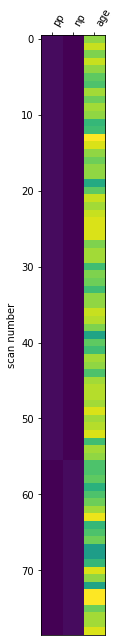

In [49]:
rerun_sec_lev_rtm = False

sec_lev_desi_rtm = pd.DataFrame({
    "pp": (data.loc[(subs_rtm,"T0",na()),:].group_str == "PP").astype(int),
    "np": (data.loc[(subs_rtm,"T0",na()),:].group_str == "NP").astype(int),
    "age": data.loc[(subs_rtm,"T0",na()),:].age
})

print(f"N = {data.loc[(subs_rtm,'T0',na()),:].shape[0]} subjects")
plot_design_matrix(sec_lev_desi_rtm, rescale=False)

#### Run only GCOR

In [50]:
# iterate voxe-wise measures
sec_level_res_rtm = {}
sec_level_res_rtm["gcor"] = {}

# RERUN
if rerun_sec_lev_rtm:
    
    # get data files
    vols = [load_img(d) for d in data.loc[(subs_rtm,"T0",na()), "gcor_path"].to_list()]
    
    # con1
    sec_level_res_rtm["gcor"]["con1"] = run_2nd_level(
        data=vols,
        design=sec_lev_desi_rtm,
        contrast_par=np.array([1, -1, 0]),
        contrast_nonpar=np.array([1, 0, 0]),
        save_dir=join(wd, "results"),
        save_prefix="RTM_gcor_con1_",
        cmap="cold_white_hot", 
        title=f"{measure}: PP > NP [-lg(p)]"
    )
    
    # con2
    sec_level_res_rtm["gcor"]["con2"] = run_2nd_level(
        data=vols,
        design=sec_lev_desi_rtm,
        contrast_par=np.array([-1, 1, 0]),
        contrast_nonpar=np.array([0, 1, 0]),
        save_dir=join(wd, "results"),
        save_prefix="RTM_gcor_con2_",
        cmap="cold_white_hot_r", 
        title=f"{measure}: PP < NP [-lg(p)]"
    )

else:
    # NOT RERUN, JUST LOAD SAVED FILES
    for con in ["con1", "con2"]:
        sec_level_res_rtm["gcor"][con] = {}
        for file in glob(join(wd, "results", f"RTM_gcor_{con}_*.nii.gz")):
            name = os.path.basename(file).replace(f"RTM_gcor_{con}_", "").replace(".nii.gz", "")
            sec_level_res_rtm["gcor"][con][name] = load_img(file)

# show results dict
sec_level_res_rtm

{'gcor': {'con1': {'map_par_logp': <nibabel.nifti1.Nifti1Image at 0x7fd91874ab80>,
   'map_nonpar_logp': <nibabel.nifti1.Nifti1Image at 0x7fd91874a100>},
  'con2': {'map_par_logp': <nibabel.nifti1.Nifti1Image at 0x7fda62ebb520>,
   'map_nonpar_idx': <nibabel.nifti1.Nifti1Image at 0x7fda62ebbbe0>,
   'map_nonpar_logp': <nibabel.nifti1.Nifti1Image at 0x7fda6396e910>,
   'map_nonpar_bin': <nibabel.nifti1.Nifti1Image at 0x7fda6396e5e0>}}}

#### Extract cluster data

In [51]:
rerun_cl_extract_rtm = False

In [52]:
if rerun_cl_extract_rtm:

    # VOXEL-WISE
        
    # image data
    vols_func = [load_img(d) for d in data["gcor_path"].to_list()]
        
    for con in ["con1", "con2"]:
        
        # indexed thresholded image
        if "map_nonpar_idx" in sec_level_res_rtm["gcor"][con].keys():
            
            # masker
            masker = NiftiLabelsMasker(
                labels_img=sec_level_res["gcor"][con]["map_nonpar_idx"],
                standardize=False,
            )
            # extract functional and structural data
            temp_func = masker.fit_transform(vols_func)
            for cl in range(temp_func.shape[1]):
                data[f"rtm_gcor_{con}_cl{cl+1}"] = temp_func[:, cl]

    # SAVE    
    data.to_csv(join(wd, "pheno", "pprs_pheno_mri_proc_res_rtm.csv"))
    
else:
    data = pd.read_csv(join(wd, "pheno", "pprs_pheno_mri_proc_res_rtm.csv"))
    data = data.set_index(["idx_id", "idx_tp", "idx_group"])

### Spatial correlations

In [53]:
rerun_spc_rtm = False

In [54]:
if rerun_spc_rtm:
    
    # run
    res_jsp_rtm = dict()
    res_jsp_rtm["gcor"] = dict()
    res_jsp_rtm["gcor"]["T0"] = dict()

    jsp = JuSpyce(
        x=pd.concat([pred_aba, pred_pet], axis=1).T,
        y=data.loc[(subs_rtm, "T0", na()), "gcor_path"].to_list(),
        z=[tpm_gm],
        data_space="mni152",
        parcellation=parc,
        parcellation_space="mni152",
        parcellation_labels=parc_info.label.to_list(),
        y_labels=data.loc[(subs_rtm, "T0", na()),:].index,
        standardize="x",
        drop_nan=False,
        n_proc=8
    ).fit(verbose=False)
    
    groups = data.loc[(subs_rtm, "T0", na()), "group"].replace({0:2})
    jsp.transform("partial", dataset="X", replace=True, verbose=False)
    jsp.transform("partial", dataset="Y", replace=True, verbose=False)
    jsp.compare(comparison="z(A,B)", groups=groups, verbose=False)
    jsp.predict(comparison="z(A,B)", method="spearman", r_to_z=True, verbose=False)
    jsp.permute_groups(
        comparison="z(A,B)",
        groups=groups,
        method="spearman",
        p_from_average_y="mean",
        r_to_z=True,
        n_perm=10000,
        seed=42,
        verbose=True
    )

    res_jsp_rtm["gcor"]["T0"]["zr"] = jsp.predictions["z(A,B)-spearman"]
    res_jsp_rtm["gcor"]["T0"]["zrp"] = jsp.p_comparisons["z(A,B)-spearman-norm"]
        
    # collect results
    spc_zr_rtm = res_jsp_rtm["gcor"]["T0"]["zr"].assign(idx_metric="gcor").set_index("idx_metric", append=True)
    spc_sig_rtm = res_jsp_rtm["gcor"]["T0"]["zrp"].assign(idx_metric="gcor").set_index("idx_metric", append=True)
    #spc_sig.index = pd.MultiIndex.from_tuples([(m, tp) for m in metrics for tp in tps])
    
    # save
    spc_zr_rtm.to_csv(join(wd, "results", "rtm_spc_zr.csv"))
    spc_sig_rtm.to_csv(join(wd, "results", "rtm_spc_zr_sig.csv"))
    
else:
    
    # load
    spc_zr_rtm = pd.read_csv(join(wd, "results", "rtm_spc_zr.csv"), index_col=[0,1,2,3])
    spc_sig_rtm = pd.read_csv(join(wd, "results", "rtm_spc_zr_sig.csv"), index_col=[0,1])    
    
# merge and print overview results
data_spc_rtm = data
data_spc_rtm = data_spc_rtm.merge(
    spc_zr_rtm.loc[na(),na(),na(), "gcor"].rename(columns=dict(zip(spc_zr_rtm.columns, ["rtm_gcor_"+c for c in spc_zr_rtm.columns]))), 
    left_index=True, 
    right_index=True
)

print("Average Spearman colocalization")
display(spc_zr_rtm.groupby(["idx_metric", "idx_tp"], sort=False).mean().loc[(na(), "T0"),:].round(2))
print("Associated group-permutation p-values")
display(spc_sig_rtm)

Average Spearman colocalization


PGR  ESR1  ESR2  NR3C1  NR3C2  OXTR  GABAa  mGluR5
idx_metric idx_tp                                                     
gcor       T0     -0.11 -0.05  0.02   0.15   0.18 -0.19   0.13    0.09

Associated group-permutation p-values


PGR      ESR1      ESR2     NR3C1     NR3C2  \
            idx_metric                                                     
mean-z(A,B) gcor        0.004855  0.055659  0.312044  0.003403  0.003473   

                            OXTR     GABAa    mGluR5  
            idx_metric                                
mean-z(A,B) gcor        0.001397  0.007191  0.119976

### Repeat longitudinal analyses

In [55]:
cl_iter_rtm = [
    ('rtm_gcor_con2_cl1', 'GCOR', 'PP < NP', 'leftPut'),
    ('rtm_gcor_con2_cl2', 'GCOR', 'PP < NP', 'rightPut')
]

mri_long_lmm_rtm = list()

for lab, measure, contrast, name in cl_iter_rtm:
    print(lab)
    
    # longitudinal data, only PP, doesnt matter if all timepoints
    temp_mri_long = data.loc[(subs_PP_long, na(), "PP"), :]
    
    # calculate LMM and pairwise paired t tests
    lmm = smf.mixedlm(f"{lab} ~ weeks_postpartal", data=temp_mri_long, groups="ID").fit()
    lmm2 = smf.mixedlm(f"{lab} ~ weeks_postpartal + np.square(weeks_postpartal)", data=temp_mri_long, groups="ID").fit()

    temp_df = pd.DataFrame({
        "Measure": measure,
        "Contrast": contrast,
        "Cluster name": name,
        ("", "df"): f"({lmm.df_modelwc}, {lmm.df_resid})",
        ("Weeks PP", "converged"): lmm.converged,
        ("Weeks PP", "coef"): lmm.params["weeks_postpartal"].round(4),
        ("Weeks PP", "-lg(p)"): -np.log10(lmm.pvalues["weeks_postpartal"]).round(3),
        ("Weeks PP^2", "converged"): lmm2.converged,
        ("Weeks PP^2", "coef"): lmm2.params["np.square(weeks_postpartal)"].round(4),
        ("Weeks PP^2", "-lg(p)"): -np.log10(lmm2.pvalues["np.square(weeks_postpartal)"]).round(3),
    }, index=range(1))
    
    # save
    temp_df = temp_df.set_index(["Measure", "Contrast", "Cluster name"])
    mri_long_lmm_rtm.append(temp_df)
        
mri_long_lmm_rtm = pd.concat(mri_long_lmm_rtm)
mri_long_lmm_rtm.columns = pd.MultiIndex.from_tuples(mri_long_lmm_rtm.columns)

mri_long_lmm_rtm.to_csv(join(wd, "tables", "rtm_mri_longitudinal_lmm_stat.csv"))
mri_long_lmm_rtm.to_html(join(wd, "tables", "rtm_mri_longitudinal_lmm_stat.html"))
mri_long_lmm_rtm

rtm_gcor_con2_cl1
rtm_gcor_con2_cl2


Weeks PP                Weeks PP^2  \
                                     df converged    coef -lg(p)  converged   
Measure Contrast Cluster name                                                 
GCOR    PP < NP  leftPut       (3, 108)      True  0.0215  3.167       True   
                 rightPut      (3, 108)      True  0.0199  3.367       True   

                                              
                                 coef -lg(p)  
Measure Contrast Cluster name                 
GCOR    PP < NP  leftPut      -0.0015  1.251  
                 rightPut     -0.0017  1.837

## Plots

In [56]:
def where(condition, x, y):
    out = np.where(condition, x, y)
    if isinstance(condition, pd.DataFrame):
        out = pd.DataFrame(out, columns=condition.columns, index=condition.index)
    return out

def lgp_to_star(lgp_array, lgq_array, empty=""):
    lgp_array_flat = np.array(lgp_array).flatten()
    lgq_array_flat = np.array(lgq_array).flatten()
    a = list()
    for lgp, lgq in zip(lgp_array_flat, lgq_array_flat):
        if lgq > -np.log10(0.05): a.append("★")
        elif lgp > -np.log10(0.05): a.append("☆")
        else: a.append(empty)
    
    return np.array(a).reshape(lgp_array.shape, order="C")

# colors
colors = dict()
for sub in subs_NP: 
    colors[sub] = "tab:blue"
for sub in [s for s in subs_PP if s not in subs_PP_long]: 
    colors[sub] = "0.5"
temp = np.array([
    [0.12156863, 0.46666667, 0.70588235, 1.        ],
    [1.        , 0.49803922, 0.05490196, 1.        ],
    [0.17254902, 0.62745098, 0.17254902, 1.        ],
    [0.83921569, 0.15294118, 0.15686275, 1.        ],
    [0.58039216, 0.40392157, 0.74117647, 1.        ],
    [0.54901961, 0.3372549 , 0.29411765, 1.        ],
    [0.89019608, 0.46666667, 0.76078431, 1.        ],
    [0.49803922, 0.49803922, 0.49803922, 1.        ],
    [0.7372549 , 0.74117647, 0.13333333, 1.        ],
    [0.09019608, 0.74509804, 0.81176471, 1.        ],
    [0.6       , 0.2       , 0.8       , 1.        ],
    [0.        , 0.6       , 0.5       , 1.        ],
    [0.9       , 0.6       , 0.        , 1.        ],
    [0.35      , 0.7       , 0.9       , 1.        ],
    [0.8       , 0.4       , 0.        , 1.        ],
    [0.5       , 0.        , 0.5       , 1.        ],
    [0.        , 0.5       , 0.        , 1.        ],
    [0.9       , 0.1       , 0.1       , 1.        ],
    [0.6       , 0.4       , 0.2       , 1.        ]
])
for i, sub in enumerate(subs_PP_long): 
    colors[sub] = temp[i] #get_cmap("tab20")(i)

### MRI brains - cross-sectional

/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = getattr(ax, type)(data_2d.copy(),
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


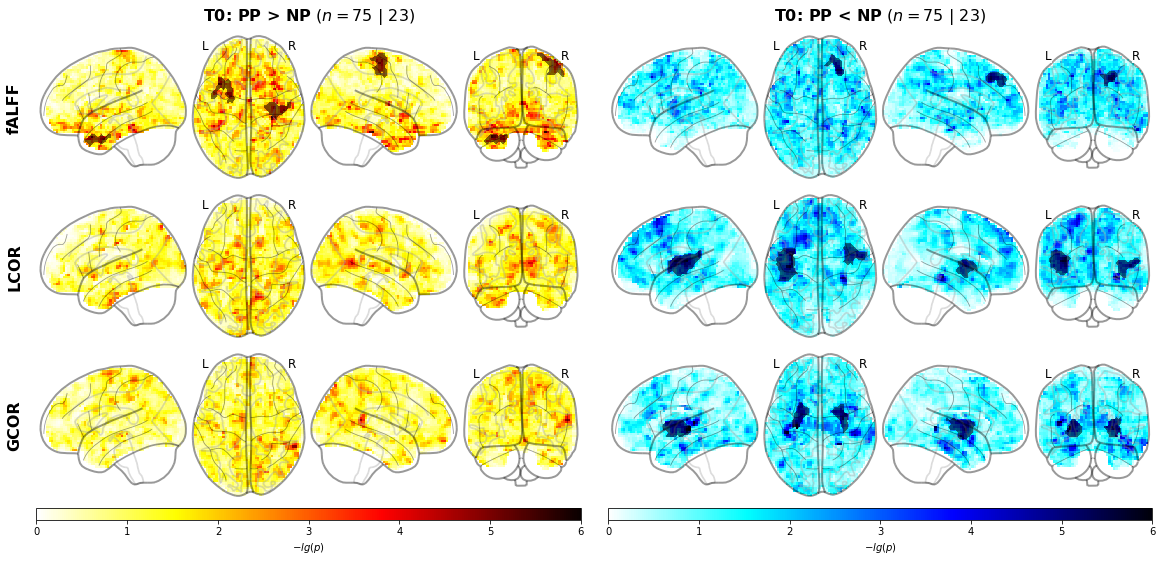

In [57]:
vmin = 0
vmax = 6

fig, axes = plt.subplots(4,2, figsize=(20,9),
                         gridspec_kw=dict(
                             hspace=0.05, 
                             wspace=0.05, 
                             height_ratios=(1,1,1, 0.08)))

# iterate contrasts
for c, con, con_name in zip(
    range(2), 
    ["con1", "con2"],
    ["PP > NP", "PP < NP"]):
    
    # VOXELWISE BRAINS
    for r, measure, measure_name in zip(
        range(3), 
        ["falff", "lcor", "gcor"], 
        ["fALFF", "LCOR", "GCOR"]):
        
        # get maps
        map_unthresh = sec_level_res[measure][con]["map_par_logp"]
        map_thresh = sec_level_res[measure][con]["map_nonpar_logp"]
        
        # plot main glass brain
        gb = plot_glass_brain(
            map_unthresh, 
            display_mode="lzry",
            alpha=0.4,
            colorbar=False, 
            cmap="cold_white_hot" if con=="con1" else "cold_white_hot_r",
            figure=fig,
            axes=axes[r,c],
            vmin=vmin,
            vmax=vmax
        )
        
        # significant cluster
        if (map_thresh.get_fdata() > cl_thresh).any():
            
            # plot overlays
            gb.add_contours(
                img=threshold_img(map_thresh, cl_thresh), 
                levels=[1], 
                colors="k", 
                linewidth=5,
                filled=True,
                alpha=0.5
            )
        
        # titles
        if r==0:
            axes[r,c].set_title(f"T0: {con_name} $(n = {data.loc[(na(),'T0','PP'),:].shape[0]}\ |\ "
                                f"{data.loc[(na(),'T0','NP'),:].shape[0]})$", 
                                size=16, weight="semibold", pad=10)
        if c==0: 
            axes[r,c].annotate(
                measure_name, 
                xy=(-0.04,0.5), 
                xycoords="axes fraction", 
                rotation=90,
                size=16, weight="semibold", ha="center", va="center"
            )
    
    # COLORBAR
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(
        cmap="black_red_r" if con=="con1" else "black_blue_r", 
        norm=norm)
    sm.set_array([])
    plt.colorbar(
        sm,
        label=r"$-lg(p)$",
        orientation="horizontal",
        cax=axes[3,c],
    )
    
# save
fig.savefig(join(wd, "plots", "fig1_brains.pdf"), bbox_inches="tight", dpi=400)
fig.savefig(join(wd, "plots", "fig1_brains.png"), bbox_inches="tight", dpi=400)

### Cross-sectional associations / sensitivity analyses

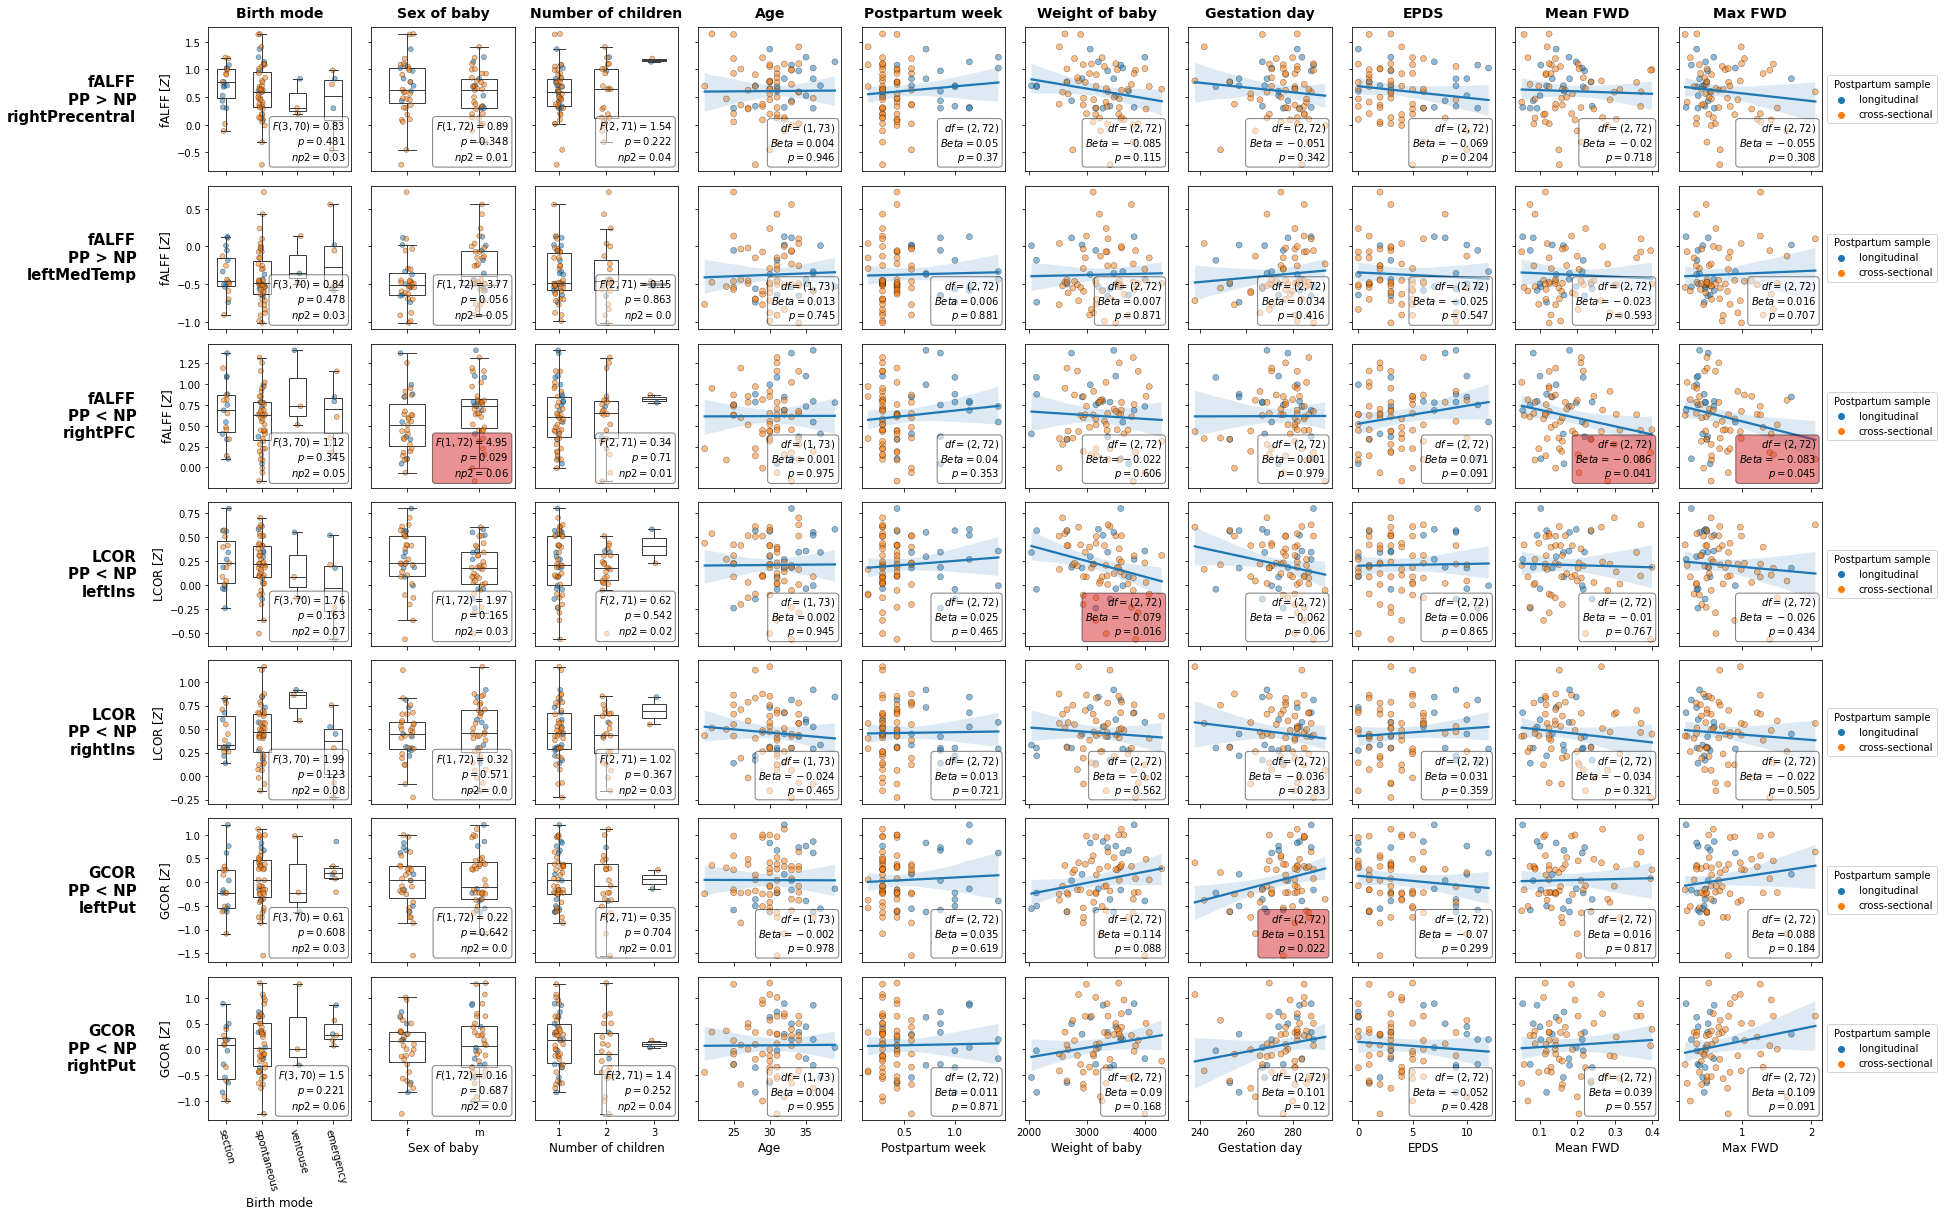

In [74]:
vars = ["birth_mode_str", "baby_sex_str", "n_children", 
        "age", "weeks_postpartal", "baby_weight", "gestation_day", "epds", "fwd_mean", "fwd_max"]
var_names = ["Birth mode", "Sex of baby", "Number of children", 
             "Age", "Postpartum week", "Weight of baby", "Gestation day", "EPDS", "Mean FWD", "Max FWD"]

if "group_crosslong_str" not in data.columns:
    # new variable with cross vs long subjects
    data["group_crosslong_str"] = data.group_str.copy()
    data.loc[(subs_PP_long, na(), "PP"), "group_crosslong_str"] = "PP-long"
    data.loc[(subs_PP_onlybl, na(), "PP"), "group_crosslong_str"] = "PP-cross"
    
fig, axes = plt.subplots(len(cl_labs), len(vars), figsize=(27, 17), sharex="col", sharey="row")

for r, (lab, m, contrast, name) in enumerate(cl_iter):
    for c, (var, var_name) in enumerate(zip(vars, var_names)):
        temp = data.loc[(na(), "T0", "PP"), [var, lab, "group_crosslong_str"]].dropna()
        if var=="n_children":
            temp[var] = temp[var].astype(int)
        # if var=="birth_mode_str":
        #     temp = temp.query("birth_mode_str in ['spontaneous','section']")
        ax = axes[r,c]
        kwargs = dict(
            x=temp[var],
            y=temp[lab],
            ax=ax
        )
        kwargs_scat = dict(
            alpha=0.5,
            hue=temp["group_crosslong_str"],
            palette="tab10",
            linewidth=0.5,
            edgecolor="k",
        )
        
        # categorical
        if var in ["birth_mode_str", "baby_sex_str", "n_children"]:
            sns.stripplot(
                **kwargs,
                **kwargs_scat,
                zorder=1,
                size=5
            )
            sns.boxplot(
                **kwargs,
                width=0.5,
                fliersize=0,
                boxprops=dict(facecolor="none"),
                zorder=2,
                linewidth=1,
            )
            f, df, p, np2 = mri_bl_assoc.iloc[r,:][(f"ANCOVA: {var_name}", na())]
            s = f"$F{df} = {f}$\n $p = {p}$\n$np2 = {np2}$"
            
        # continuous
        else:
            sns.scatterplot(
                **kwargs,
                **kwargs_scat,
                sizes=8
            )
            sns.regplot(
                **kwargs,
                scatter=False,
            )   
            coef, df, p = mri_bl_assoc.iloc[r,:][(f"MLR: {var_name}", na())]
            s = f"$df = {df}$\n$Beta = {coef}$\n$p = {p}$" 

        ax.annotate(s, xy=(0.96, 0.05), xycoords="axes fraction", ha="right", va="bottom",
                    bbox=dict(boxstyle="round", fc="tab:red" if p < 0.05 else "w", alpha=0.5))
        
        if ax.get_subplotspec().is_first_row():
            ax.set_title(var_name, weight="semibold", size=14, pad=10)
        
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(var_name, size=12)
            if "birth_mode" in var:
                ax.set_xticks(ax.get_xticks())
                ax.set_xticklabels(ax.get_xticklabels(), rotation_mode="anchor", ha="left", rotation=-75)
        else:
            ax.set_xlabel("")
        
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(m + " $[Z]$", size=12)
            ax.annotate(f"{m}\n{contrast}\n{name}", xy=(-0.5,0.5), xycoords="axes fraction", 
                        size=15, weight="semibold", ha="right", va="center")
        else:
            ax.set_ylabel("")
        
        if ax.get_subplotspec().is_last_col():
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, ["longitudinal" if "long" in l else "cross-sectional" for l in labels], 
                      loc="center left", bbox_to_anchor=(1, 0.5), title="Postpartum sample")
        else:
            ax.legend().remove()

fig.tight_layout() 
fig.savefig(join(wd, "plots", "figS1_pp_sensitivity.pdf"), bbox_inches="tight")
fig.savefig(join(wd, "plots", "figS1_pp_sensitivity.png"), bbox_inches="tight", dpi=400)

### MRI brains - longitudinal 

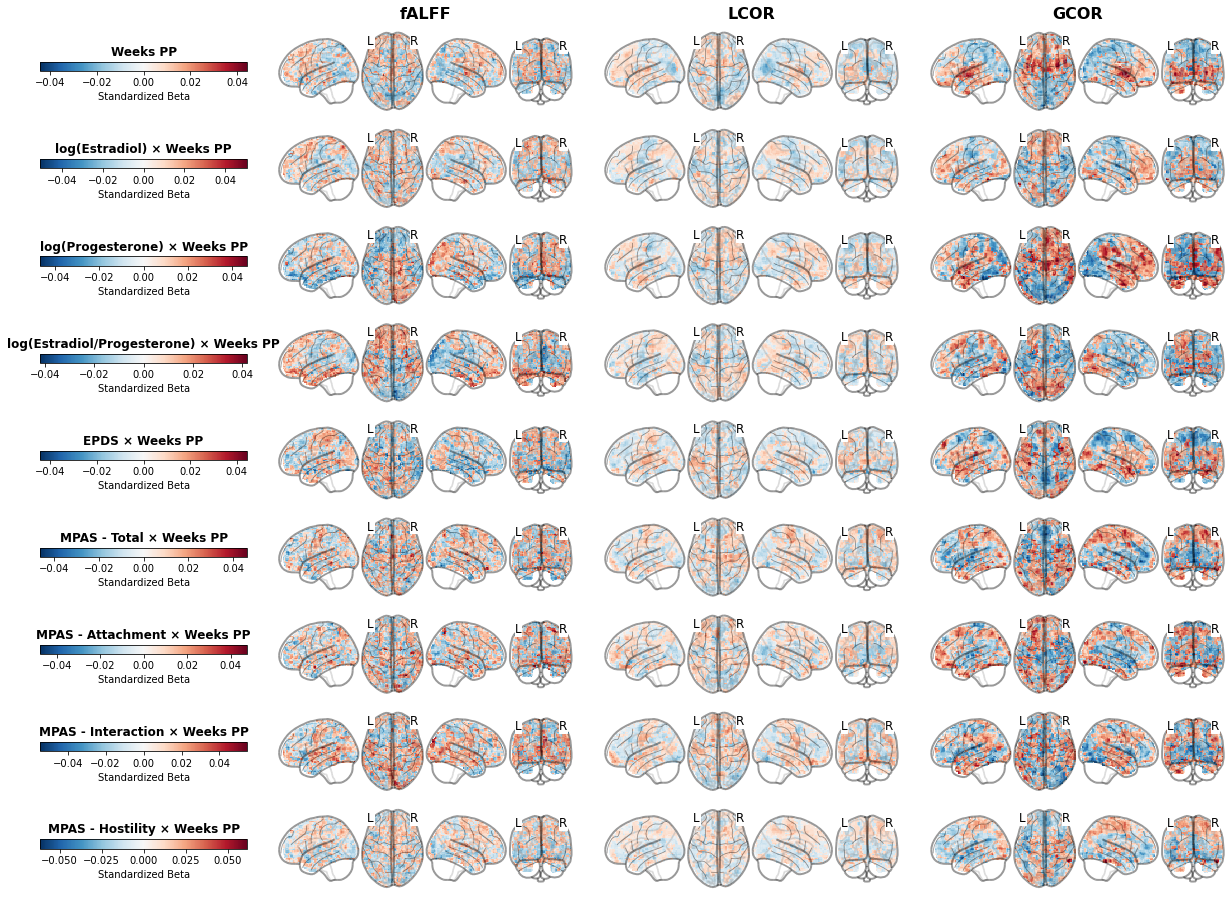

In [59]:
es_lims = {}
for c in sec_level_res_long["falff"].keys():
    es_lims[c] = [np.max(np.abs(sec_level_res_long[m][c].get_fdata())) for m in ["falff", "lcor", "gcor"]]
    es_lims[c] = (-max(es_lims[c]), max(es_lims[c]))

contrasts = [
    'weeks_postpartal', 
    'estradiol_log*weeks_postpartal', 'progesterone_log*weeks_postpartal', 'ep_ratio_log*weeks_postpartal', 
    'epds*weeks_postpartal',
    'mpas*weeks_postpartal',  'mpas_attachment*weeks_postpartal', 'mpas_interaction*weeks_postpartal', 'mpas_hostility*weeks_postpartal'
]
contrast_names = [
    'Weeks PP', 
    'log(Estradiol) × Weeks PP', 'log(Progesterone) × Weeks PP', 'log(Estradiol/Progesterone) × Weeks PP', 
    'EPDS × Weeks PP',
    'MPAS - Total × Weeks PP',  'MPAS - Attachment × Weeks PP', 'MPAS - Interaction × Weeks PP', 'MPAS - Hostility × Weeks PP'
]

fig, axes = plt.subplots(len(contrasts), 3, figsize=(17,16), 
                         gridspec_kw=dict(wspace=0.1, hspace=0.05))
for c, measure in enumerate(["fALFF", "LCOR", "GCOR"]): 
    axes[0,c].set_title(measure, weight="semibold", size=16)
    
    for r, (contrast, contrast_name) in enumerate(zip(contrasts, contrast_names)):
        
        gb = plot_glass_brain(
            sec_level_res_long[measure.lower()][contrast], 
            display_mode="lzry",
            alpha=0.4,
            colorbar=False, 
            cmap="RdBu_r",
            plot_abs=False,
            figure=fig,
            axes=axes[r,c],
            vmin=es_lims[contrast][0],
            vmax=es_lims[contrast][1]
        )  
        
        # ANNOTATE
        if c==0:
        
            # COLORBAR
            ax_cbar = axes[r,c].inset_axes((-0.8, 0.5, 0.7, 0.1))
            sm = plt.cm.ScalarMappable(
                cmap="RdBu_r",
                norm=mpl.colors.Normalize(*es_lims[contrast]))
            sm.set_array([])
            fig.colorbar(
                sm,
                label="Standardized Beta",
                orientation="horizontal",
                cax=ax_cbar
            )
            ax_cbar.set_title(contrast_name, size=12, weight="semibold")
        
# save
fig.savefig(join(wd, "plots", "figS3_brains_long.png"), bbox_inches="tight", dpi=300)

### MRI brains - long/cross correlation

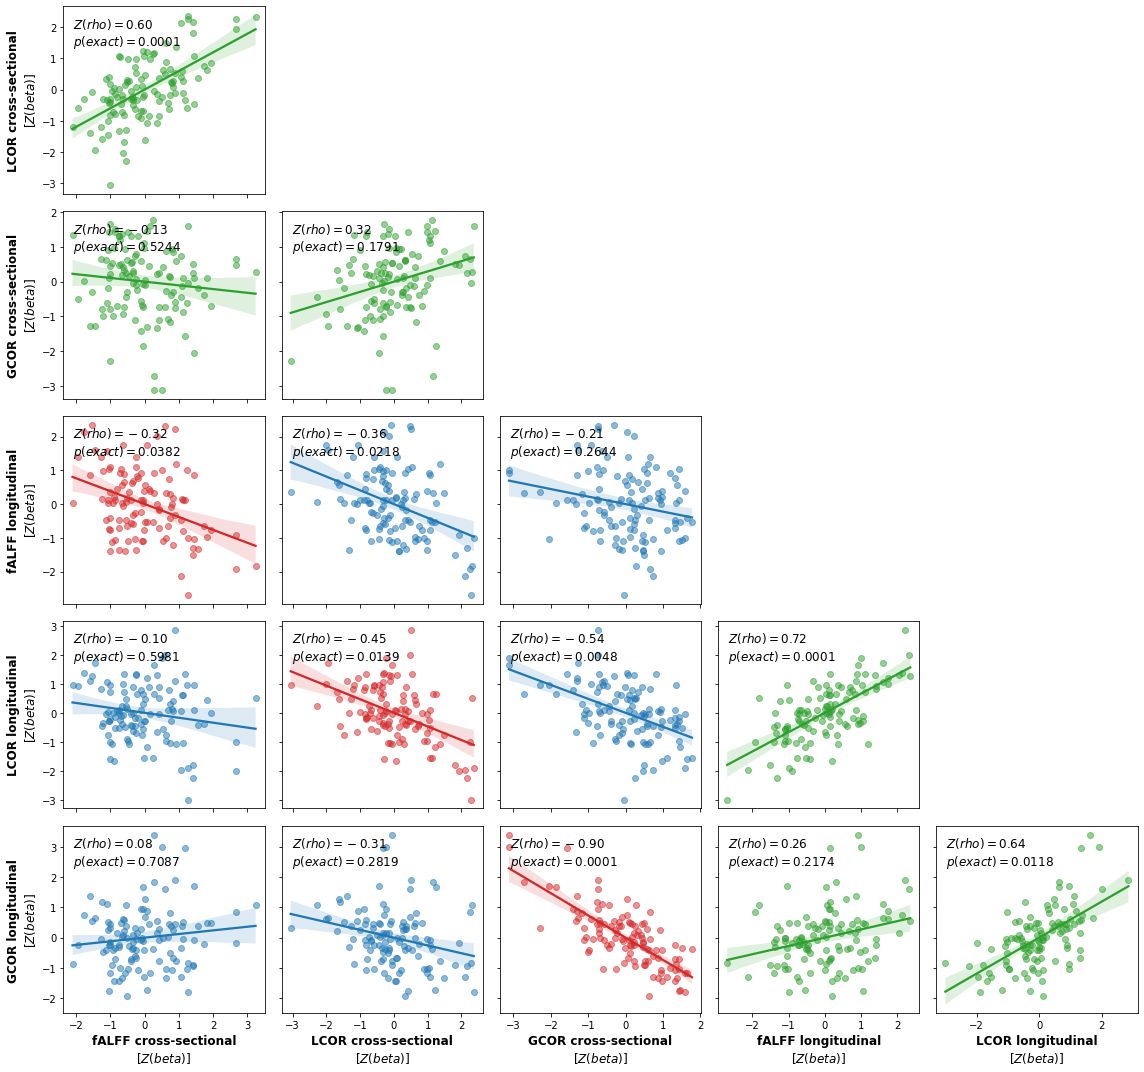

In [60]:
temp = pd.read_csv(join(wd, "results", "spc_longcross_data.csv"), index_col=0).T
temp_res = pd.read_csv(join(wd, "results", "spc_longcross.csv"), index_col=0, header=[0,1])
fig, axes = plt.subplots(len(temp.columns)-1, len(temp.columns)-1, figsize=(16, 15), 
                         sharey="row", sharex="col")

for r, measure_r in enumerate(temp.columns[1:]):
    for c, measure_c in enumerate(temp.columns[:-1]):
        ax = axes[r,c]
        if r < c:
            ax.set_axis_off()
        else:        
            sns.regplot(
                y=temp[measure_r],
                x=temp[measure_c],
                ax=ax,
                scatter_kws=dict(alpha=0.5),
                color="tab:red" if measure_r.split("_")[0]==measure_c.split("_")[0] 
                    else "tab:green" if measure_r.split("_")[1]==measure_c.split("_")[1] 
                    else "tab:blue"
            )
            rho = temp_res.loc[measure_r, (measure_c, "rho")]
            p = (temp_res.loc[measure_r, (measure_c, "p")] + temp_res.loc[measure_c, (measure_r, "p")]) / 2
            ax.annotate(
                f"$Z(rho) = {rho:.02f}$"
                f"\n$p(exact) = {p:.04f}$",
                xy=(0.05,0.95),
                xycoords="axes fraction",
                ha="left", va="top",
                size=12
            )
            if ax.get_subplotspec().is_last_row():
                ax.set_xlabel(
                    measure_c \
                        .replace("falff", "fALFF").replace("gcor", "GCOR").replace("lcor", "LCOR") \
                        .replace("_long", " longitudinal\n$[Z(beta)]$").replace("_cross", " cross-sectional\n$[Z(beta)]$"),
                weight="semibold", 
                size=12
            )
            else:
                ax.set_xlabel("")
            if ax.get_subplotspec().is_first_col():
                ax.set_ylabel(
                    measure_r \
                        .replace("falff", "fALFF").replace("gcor", "GCOR").replace("lcor", "LCOR") \
                        .replace("_long", " longitudinal\n$[Z(beta)]$").replace("_cross", " cross-sectional\n$[Z(beta)]$"), 
                    weight="semibold", 
                    size=12
                )
            else:
                ax.set_ylabel("")

fig.tight_layout()
fig.savefig(join(wd, "plots", "figS4_brain_spc.pdf"), bbox_inches="tight")
fig.savefig(join(wd, "plots", "figS4_brain_spc.png"), bbox_inches="tight", dpi=300)

### MRI group comparisons & development

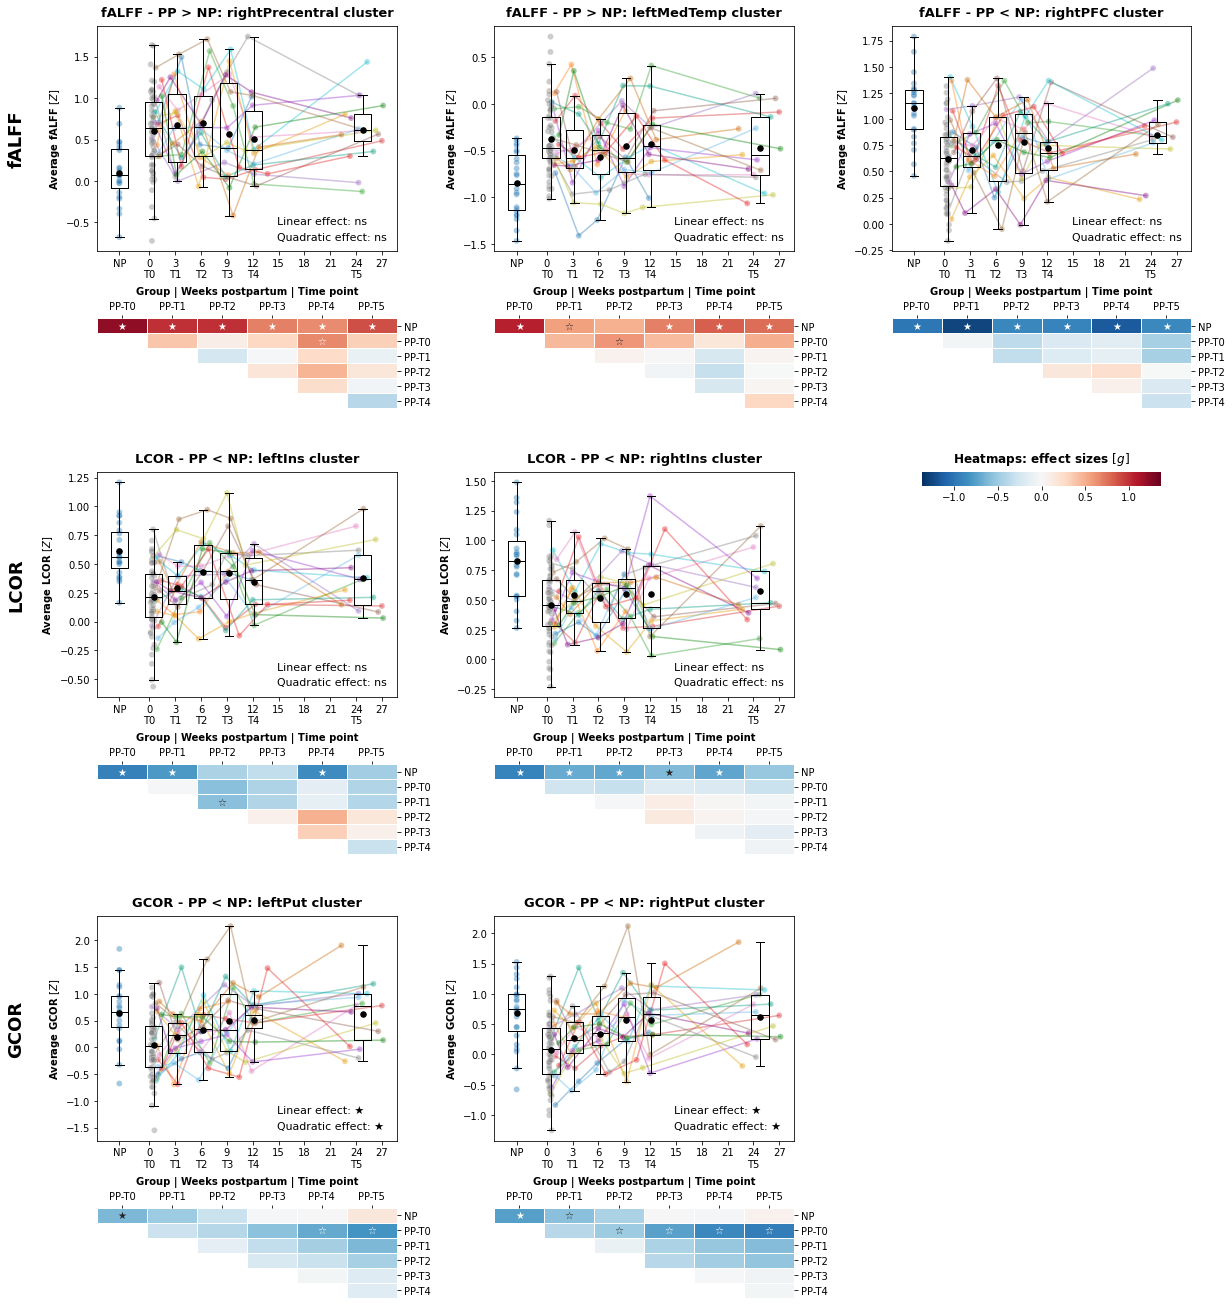

In [61]:
# maximum effect size
es_lim = np.nanmax(np.abs(np.r_[
    mri_bl_confounds[("ANCOVA: PP vs. NP: Age", "g")].values,
    mri_long_unpaired[(f"ANCOVA: PP-{tp} vs. NP: Age", "g")].values,
    mri_long_paired.loc[:, (na(), "g")].values.flatten()
]))

fig, axes = plt.subplots(3,3, figsize=(17,18), sharex=False, constrained_layout=True, gridspec_kw=dict(hspace=0.1))
axes = axes.ravel()

for (lab, measure, contrast, name), i in zip(cl_iter, [0,1,2, 3,4, 6,7]):
    
    temp_mri = pd.concat(
        [data.loc[(subs_NP, ), :].melt(["ID", "group_str", "weeks_postpartal"], lab), # all NP
         data.loc[(subs_PP, "T0", ), :].melt(["ID", "group_str", "weeks_postpartal"], lab).replace({"PP": "PP-T0"})] + \
        [data.loc[(subs_PP_long, tp), :].melt(["ID", "group_str", "weeks_postpartal"], lab).replace({"PP": f"PP-{tp}"}) for tp in ["T1", "T2", "T3", "T4", "T5"]]
    )
    temp_mri.loc[temp_mri.group_str=="NP", "weeks_postpartal"] = -3.5

    sns.scatterplot(
        temp_mri,
        x="weeks_postpartal",
        hue="ID",
        y="value",
        ax=axes[i],
        legend=None,
        alpha=0.4,
        zorder=3,
        palette=colors
    )
    sns.lineplot(
        temp_mri,
        x="weeks_postpartal",
        y="value",
        hue="ID",
        ax=axes[i],
        legend=None,
        alpha=0.4,
        zorder=2,
        palette=colors
    )
    
    for group in temp_mri.group_str.unique():   

        axes[i].boxplot(
            x=temp_mri.loc[temp_mri.group_str==group, "value"],
            positions=[temp_mri.loc[temp_mri.group_str==group, "weeks_postpartal"].mean()],
            widths=2,
            zorder=10,
            showfliers=False,
            medianprops=dict(c="k")       
        )
        axes[i].scatter(
            y=[temp_mri.loc[temp_mri.group_str==group, "value"].mean()],
            x=[temp_mri.loc[temp_mri.group_str==group, "weeks_postpartal"].mean()],
            zorder=11,
            c="k",
            s=30
        )
    
    # LMM
    for var in ["Weeks PP", "Weeks PP^2"]:
        p = mri_long_lmm.loc[(measure, contrast, name), (var, "-lg(p)")]
        q =  mri_long_lmm.loc[(measure, contrast, name), (var, "-lg(q)")]
        if q > -np.log10(0.05): s = "★"
        elif p > -np.log10(0.05): s = "☆"
        else: s = "ns"
        axes[i].annotate(
            f"{'Linear' if var=='Weeks PP' else 'Quadratic'} effect: {s}",
            xy=(0.6, 0.05 + (0.07 if var=='Weeks PP' else 0)),
            xycoords="axes fraction",
            size=11
        )
    
    # Labels
    axes[i].set_title(f"{measure} - {contrast}: {name} cluster",  weight="semibold", size=13, pad=10)
    axes[i].set_ylabel(f"Average {measure} $[Z]$", weight="semibold")
    axes[i].set_xticks([-3.5] + list(range(0,28,3)))
    axes[i].set_xticklabels(["NP", "0\nT0", "3\nT1", "6\nT2", "9\nT3", "12\nT4", "15", "18", "21", "24\nT5", "27"])
    axes[i].set_xlabel("Group | Weeks postpartum | Time point", weight="semibold", labelpad=7)
    
    
    # significance
    comp_p = pd.DataFrame(
        np.zeros((7,7)),
        columns=["NP"]+[f"PP-{tp}" for tp in tps],
        index=["NP"]+[f"PP-{tp}" for tp in tps]
    )
    comp_q, comp_es = comp_p.copy(), comp_p.copy()

    # NP vs PP T0
    comp_p.loc["NP", "PP-T0"] = mri_bl_confounds.loc[(measure, contrast, name), ("ANCOVA: PP vs. NP: Age", "-lg(p)")]
    comp_q.loc["NP", "PP-T0"] = mri_bl_confounds.loc[(measure, contrast, name), ("ANCOVA: PP vs. NP: Age", "-lg(p)")]
    comp_es.loc["NP", "PP-T0"] = mri_bl_confounds.loc[(measure, contrast, name), ("ANCOVA: PP vs. NP: Age", "g")]

    # NP vs PP each timepoint
    for tp in tps:
        comp_p.loc["NP", f"PP-{tp}"] = mri_long_unpaired.loc[(measure, contrast, name), (f"ANCOVA: PP-{tp} vs. NP: Age", "-lg(p)")]
        comp_q.loc["NP", f"PP-{tp}"] = mri_long_unpaired.loc[(measure, contrast, name), (f"ANCOVA: PP-{tp} vs. NP: Age", "-lg(q)")]
        comp_es.loc["NP", f"PP-{tp}"] = mri_long_unpaired.loc[(measure, contrast, name), (f"ANCOVA: PP-{tp} vs. NP: Age", "g")]
        
    # PP vs PP each combi
    for k in [c for c in mri_long_paired.columns if ("T-test" in c[0]) & (c[1]=="-lg(p)")]:
        comp_p.loc["PP-"+k[0].split(" ")[1], "PP-"+k[0].split(" ")[3]] = mri_long_paired.loc[(measure, contrast, name), k]
        comp_es.loc["PP-"+k[0].split(" ")[1], "PP-"+k[0].split(" ")[3]] = mri_long_paired.loc[(measure, contrast, name), (k[0], "g")]
        
    for k in [c for c in mri_long_paired.columns if ("T-test" in c[0]) & (c[1]=="-lg(q)")]:
        comp_q.loc["PP-"+k[0].split(" ")[1], "PP-"+k[0].split(" ")[3]] = mri_long_paired.loc[(measure, contrast, name), k]


    comp_es = comp_es + comp_es.T
    comp_es = comp_es.replace({np.nan:0})
    comp_p = comp_p + comp_p.T
    comp_q = comp_q + comp_q.T
    
    comp_es = comp_es.drop("NP", axis="columns").drop("PP-T5", axis="index")
    comp_p = comp_p.drop("NP", axis="columns").drop("PP-T5", axis="index")
    comp_q = comp_q.drop("NP", axis="columns").drop("PP-T5", axis="index")
    
    comp_sig = lgp_to_star(comp_p, comp_q, "")
    mask = np.zeros(comp_es.shape)        
    mask[np.tril_indices_from(mask, k=-1)] = True
    
    # plot heatmap
    sig_ax = axes[i].inset_axes((0, -0.7, 1, 0.4))
    if i==0:
        cbar_ax = axes[5].inset_axes((0.1, 0.94, 0.8, 0.06)) 
        cbar_ax.set_title("Heatmaps: effect sizes $[g]$", weight="semibold", size=12, pad=10)
    ax = sns.heatmap(
        comp_es,
        vmin=-es_lim,
        vmax=es_lim,
        cmap="RdBu_r",
        cbar=True if i==0 else False,
        cbar_ax=cbar_ax,
        cbar_kws=dict(orientation="horizontal"),
        annot=comp_sig,
        linewidths=1,
        linecolor="w",
        fmt="s",
        mask=mask,
        ax=sig_ax
    )
    ax.xaxis.tick_top()
    ax.yaxis.tick_right()
    ax.set_yticks(np.arange(0.5, 5.6))
    ax.set_yticklabels(["NP"]+[f"PP-{tp}" for tp in tps[:5]], rotation=0)

    if i in [0,3,6]:
        axes[i].annotate(
            measure, 
            xy=(-0.27,0.5), 
            xycoords="axes fraction", 
            rotation=90,
            size=18, weight="semibold", ha="center", va="center"
        )

[ax.axis("off") for ax in axes if ax.axis() == (0.0, 1.0, 0.0, 1.0)]

# save
fig.savefig(join(wd, "plots", "fig2_boxes.pdf"), bbox_inches="tight")
fig.savefig(join(wd, "plots", "fig2_boxes.png"), bbox_inches="tight", dpi=300)

### Spatial associations

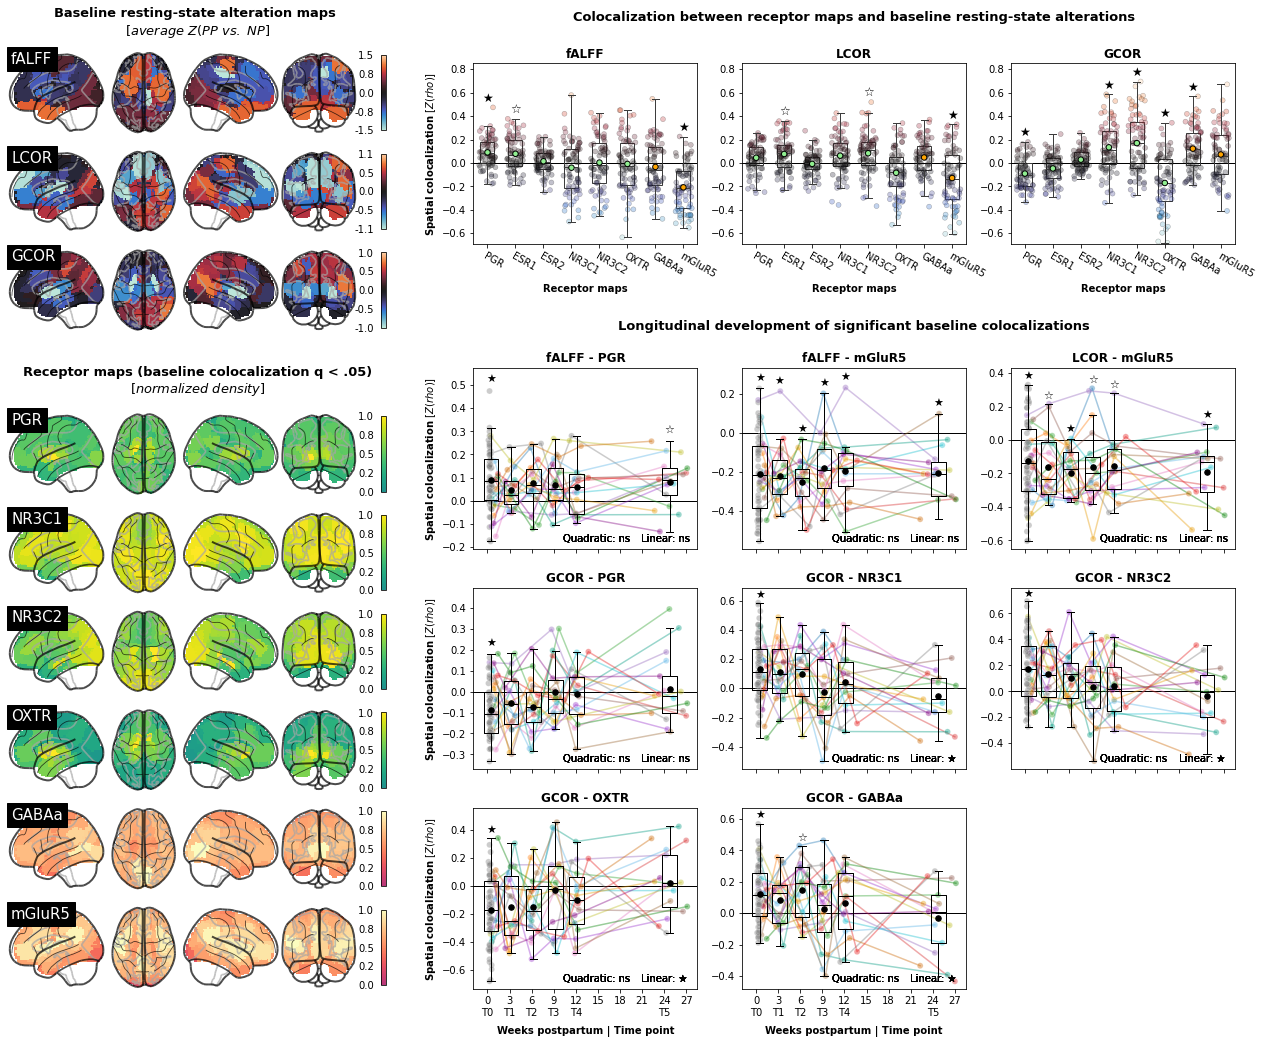

In [66]:
fig = plt.figure(figsize=(22,18))
gs = GridSpec(1, 2, figure=fig, width_ratios=(0.5,1), wspace=0.15)
measures = ["fALFF", "LCOR", "GCOR"]
receptors = set(spc_cross[spc_cross.loc[:, ("T0", "q(norm)")] < 0.05].index.get_level_values("Receptor"))
receptors = [r for r in pred_aba.columns if r in receptors] + [r for r in pred_pet.columns if r in receptors]

## BRAINS
gs_brains = GridSpecFromSubplotSpec(1 + 3 + 1 + len(receptors), 1, gs[:,0], wspace=0.2, hspace=0.2, 
                                    height_ratios=[0.3] + [1]*3 + [0.6] + [1]*len(receptors))
kwargs = dict(
    display_mode="lzry",
    annotate=False,
    cbar_tick_format="%.1f",
    colorbar=True, 
    plot_abs=False,
)
# MRI
ax = fig.add_subplot(gs_brains[0])
ax.set_axis_off()
ax.annotate("Baseline resting-state alteration maps \n$[average\ Z(PP\ vs.\ NP]$",
            xy=(0.5,0.5), ha="center", va="center", size=13, weight="semibold")
for r, m in enumerate(measures, start=1):
    temp_z = pd.read_csv(join(wd, "results", f"spc_pp_data_{m}.csv"), index_col=[0,1,2])
    temp_z = (temp_z.loc[(subs_PP, na(), "PP"), :] - temp_z.loc[(subs_NP, na(), "NP"), :].mean()) / temp_z.loc[(subs_NP, na(), "NP"), :].std()
    temp_z = temp_z.groupby("idx_tp").mean().T
    ax = fig.add_subplot(gs_brains[r])
    plot_glass_brain(
        parcel_data_to_volume(temp_z["T0"].values, parc)[0], 
        title=m, 
        axes=ax,
        **kwargs,
        cmap="icefire"
    )
# ABA/PET
ax = fig.add_subplot(gs_brains[4])
ax.set_axis_off()
ax.annotate("Receptor maps (baseline colocalization q < .05)\n$[normalized\ density]$",
            xy=(0.5,0.3), ha="center", va="center", size=13, weight="semibold")
for r, atlas in enumerate(receptors, start=5):
    ax = fig.add_subplot(gs_brains[r])
    plot_glass_brain(
        parcel_data_to_volume(minmax_scale(pred_aba_pet[atlas]), parc)[0], 
        title=atlas, 
        axes=ax,
        **kwargs,
        cmap="viridis" if atlas in pred_aba.columns else "magma"
    )

## SCATTER/BOXPLOTS
temp = spc_cross[spc_cross.loc[:, ("T0", "q(norm)")] < 0.05]
gs_boxes = GridSpecFromSubplotSpec(1 + 1 + 1 + int(np.ceil(len(temp) / 3)), 3, gs[:,1], wspace=0.2, hspace=0.3, 
                                   height_ratios=[0.075, 1, 0.25] + [1]*int(np.ceil(len(temp) / 3)))

# BASELINE
ax = fig.add_subplot(gs_boxes[0,:])
ax.set_axis_off()
ax.annotate("Colocalization between receptor maps and baseline resting-state alterations",
            xy=(0.5,0.5), ha="center", va="center", size=13, weight="semibold")
temp = spc_zr.loc[(na(), "T0", "PP")].reset_index() \
    .melt(id_vars="idx_metric", value_vars=spc_zr.columns, var_name="receptor", value_name="Z")
axes = [fig.add_subplot(gs_boxes[1, c]) for c in range(len(measures))]
for c, (ax, m) in enumerate(zip(axes, measures)):
    ax.sharey(axes[0])
    kwargs = dict(
        data=temp[temp.idx_metric==m],
        x="receptor",
        y="Z",
        dodge=False,
        ax=ax
    )
    sns.stripplot(
        **kwargs,
        hue="Z",
        hue_norm=(-temp["Z"].abs().max(), temp["Z"].abs().max()),
        palette="icefire",
        jitter=0.3,
        legend=None,
        alpha=0.3,
        edgecolor="k",
        linewidth=0.5,
        zorder=1
    )
    sns.boxplot(
        **kwargs,
        fliersize=0,
        width=0.5,
        boxprops=dict(facecolor="none"),
        zorder=2,
        linewidth=1,
    )
    receptors = [l.get_text() for l in ax.get_xticklabels()]
    ax.scatter(
        x=receptors,
        y=temp[temp.idx_metric==m].groupby("receptor").mean().loc[receptors],
        zorder=20,
        c=["orange" if r in pred_pet.columns else "lightgreen" for r in receptors],
        s=30,
        ec="k"
    ) 
    for x, r in enumerate(spc_zr.columns):
        if spc_cross.loc[(m,r), ("T0", "q(norm)")] < 0.05: s = "★"
        elif spc_cross.loc[(m,r), ("T0", "p(norm)")] < 0.05: s = "☆"
        else: s = ""
        ax.text(
            s=s, 
            x=x, 
            y=spc_zr.loc[(na(), "T0", "PP", m), r].max() + 0.08, 
            ha="center", va="center", size=12
        )  
    ax.axhline(c="k", zorder=0, lw=1)
    ax.set_ylim(None, 0.85)
    ax.set_xlabel("Receptor maps", weight="semibold")
    ax.set_title(m, weight="semibold", size=12)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-30, rotation_mode="anchor", ha="left")
    if c==0:
        ax.set_ylabel("Spatial colocalization $[Z(rho)]$", weight="semibold")
    else:
        ax.set_ylabel("")
    
# LONGITUDINAL
ax = fig.add_subplot(gs_boxes[2,:])
ax.set_axis_off()
ax.annotate("Longitudinal development of significant baseline colocalizations",
            xy=(0.5,0.05), ha="center", va="center", size=13, weight="semibold")
temp = spc_cross[spc_cross.loc[:, ("T0", "q(norm)")] < 0.05]
axes = [fig.add_subplot(gs_boxes[3,0]), fig.add_subplot(gs_boxes[3,1]), fig.add_subplot(gs_boxes[3,2]),
        fig.add_subplot(gs_boxes[4,0]), fig.add_subplot(gs_boxes[4,1]), fig.add_subplot(gs_boxes[4,2]),
        fig.add_subplot(gs_boxes[5,0]), fig.add_subplot(gs_boxes[5,1])]
if len(axes) != len(temp):
    raise ValueError("Adjust longitudinal axes list!")

for i, (idx, ax) in enumerate(zip(temp.index, axes)):
    m, r = idx
    
    temp = data_spc.loc[(na(), na(), "PP"), [f"{m}_{r}", "weeks_postpartal", "ID"]]
    sns.scatterplot(
        temp,
        x="weeks_postpartal",
        hue="ID",
        y=f"{m}_{r}",
        ax=ax,
        legend=None,
        alpha=0.4,
        zorder=3,
        palette=colors
    )
    sns.lineplot(
        temp,
        x="weeks_postpartal",
        y=f"{m}_{r}",
        hue="ID",
        ax=ax,
        legend=None,
        alpha=0.4,
        zorder=2,
        palette=colors
    )
    temp_mean = temp.groupby("idx_tp").mean()
    temp_max = temp.groupby("idx_tp").max()
    for tp in tps:   
        ax.boxplot(
            x=temp.loc[(na(), tp, "PP"), f"{m}_{r}"],
            positions=[temp_mean.loc[tp, "weeks_postpartal"]],
            widths=2,
            zorder=10,
            showfliers=False,
            medianprops=dict(c="k")
        )
        ax.scatter(
            y=temp_mean.loc[tp, f"{m}_{r}"],
            x=temp_mean.loc[tp, "weeks_postpartal"],
            zorder=11,
            c="k",
            s=30
        )        
        if spc_cross.loc[(m,r), (tp, "q(norm)")] < 0.05: s = "★"
        elif spc_cross.loc[(m,r), (tp, "p(norm)")] < 0.05: s = "☆"
        else: s = ""
        ax.text(
            s=s, 
            x=temp_mean.loc[tp, "weeks_postpartal"], 
            y=temp_max.loc[tp, f"{m}_{r}"] + 0.05,
            ha="center", va="center", size=11
        )  
        # LMM
        for var in ["Weeks PP", "Weeks PP^2"]:
            if spc_long.loc[(m,r), (var, "q")] < 0.05: s = "★"
            elif spc_long.loc[(m,r), (var, "p")] < 0.05: s = "☆"
            else: s = "ns"
            ax.annotate(
                f"{'Linear' if var=='Weeks PP' else 'Quadratic'}: {s}",
                xy=(0.4 + (0.35 if var=='Weeks PP' else 0), 0.04),
                xycoords="axes fraction",
                ha="left",
                size=10
            )
    ax.set_ylim(None, temp_max[f"{m}_{r}"].max() + 0.1)
    ax.axhline(c="k", zorder=0, lw=1)
    ax.set_title(f"{m} - {r}", weight="semibold", size=12)
    ax.set_xticks(list(range(0,28,3)))
    if ax.get_subplotspec().is_last_row():
        ax.set_xticklabels(["0\nT0", "3\nT1", "6\nT2", "9\nT3", "12\nT4", "15", "18", "21", "24\nT5", "27"])
        ax.set_xlabel("Weeks postpartum | Time point", weight="semibold", labelpad=8)
    else:
        ax.set_xticklabels([])
        ax.set_xlabel("")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Spatial colocalization $[Z(rho)]$", weight="semibold")
    else:
        ax.set_ylabel("")
        
fig.savefig(join(wd, "plots", "fig3_spatial_correlations.pdf"), bbox_inches="tight", dpi=300)
fig.savefig(join(wd, "plots", "fig3_spatial_correlations.png"), bbox_inches="tight", dpi=300)

### Receptor cross correlation

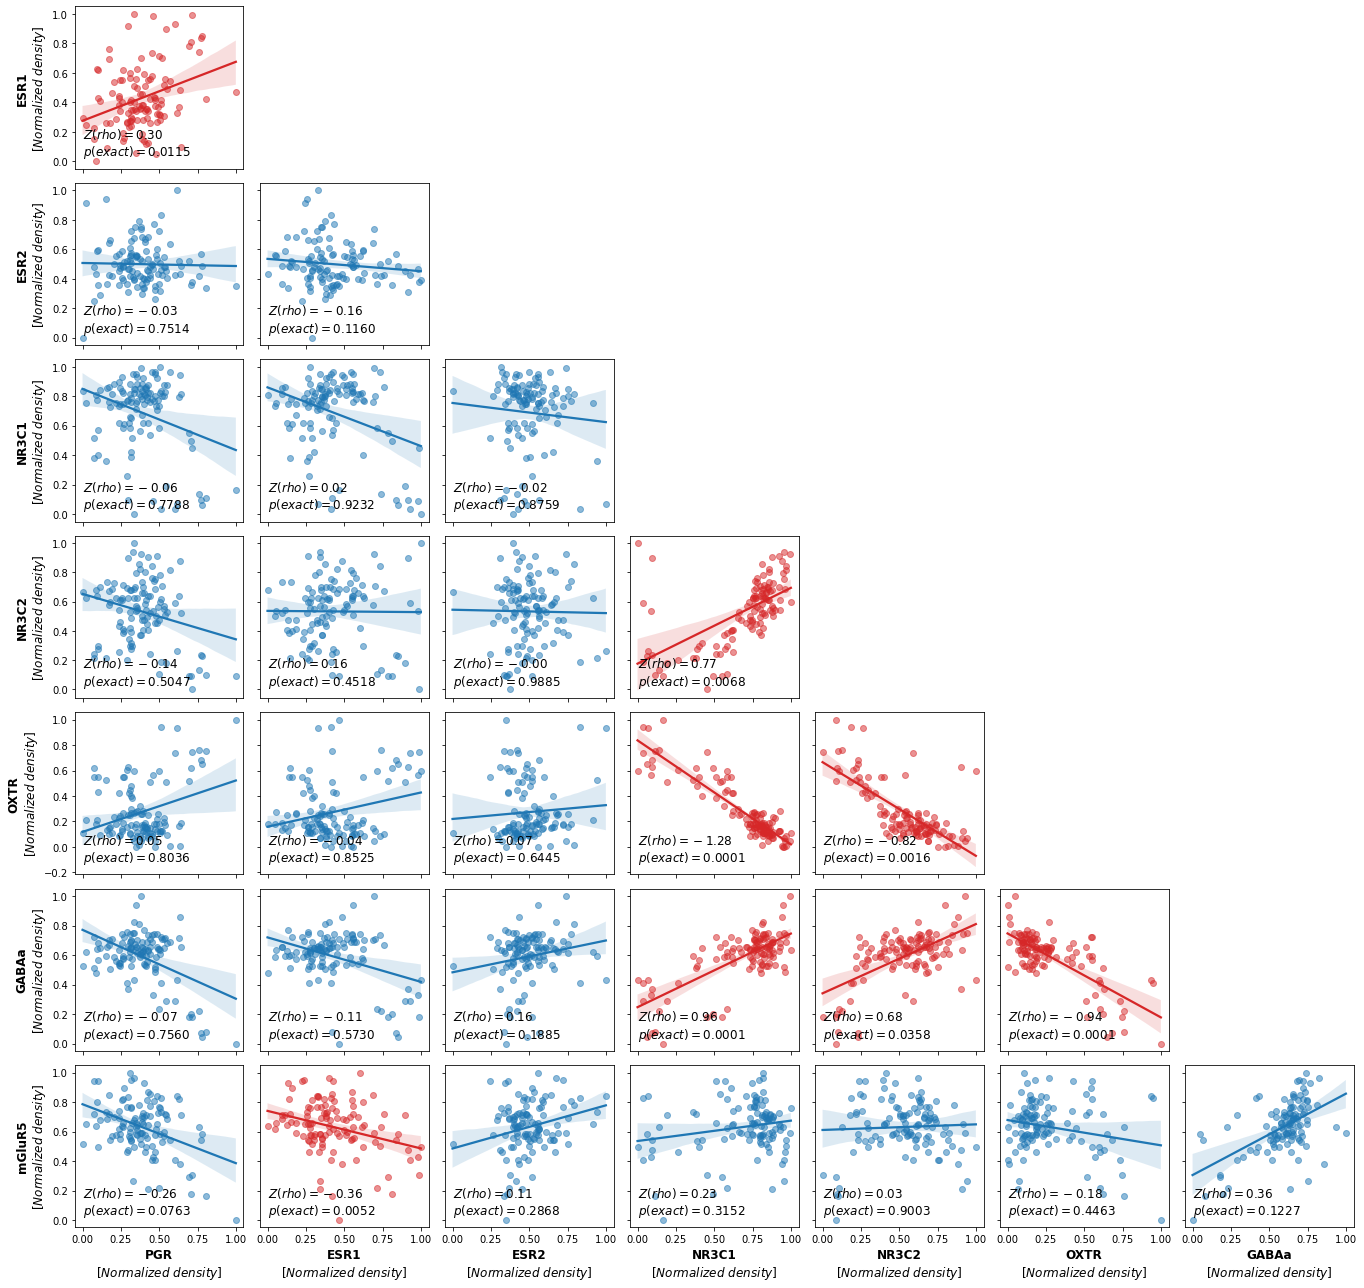

In [67]:
temp_res = pd.read_csv(join(wd, "results", "spc_receptors.csv"), index_col=0, header=[0,1])
fig, axes = plt.subplots(len(pred_aba_pet.columns)-1, len(pred_aba_pet.columns)-1, figsize=(19,18), 
                         sharey="row", sharex="col")

for r, receptor_r in enumerate(pred_aba_pet.columns[1:]):
    for c, receptor_c in enumerate(pred_aba_pet.columns[:-1]):
        ax = axes[r,c]
        if r < c:
            ax.set_axis_off()
        else:        
            rho = temp_res.loc[receptor_r, (receptor_c, "rho")]
            p = (temp_res.loc[receptor_r, (receptor_c, "p")] + temp_res.loc[receptor_c, (receptor_r, "p")]) / 2
            sns.regplot(
                y=minmax_scale(pred_aba_pet[receptor_r]),
                x=minmax_scale(pred_aba_pet[receptor_c]),
                ax=ax,
                scatter_kws=dict(alpha=0.5),
                color="tab:red" if p < .05 else "tab:blue"
            )
            ax.annotate(
                f"$Z(rho) = {rho:.02f}$"
                f"\n$p(exact) = {p:.04f}$",
                xy=(0.05,0.05),
                xycoords="axes fraction",
                ha="left", va="bottom",
                size=12
            )
            if ax.get_subplotspec().is_last_row():
                ax.set_xlabel(f"{receptor_c}\n$[Normalized\ density]$", weight="semibold", size=12)
            else:
                ax.set_xlabel("")
            if ax.get_subplotspec().is_first_col():
                ax.set_ylabel(f"{receptor_r}\n$[Normalized\ density]$", weight="semibold", size=12)
            else:
                ax.set_ylabel("")

fig.tight_layout()
fig.savefig(join(wd, "plots", "figS6_receptor_spc.pdf"), bbox_inches="tight")
fig.savefig(join(wd, "plots", "figS6_receptor_spc.png"), bbox_inches="tight", dpi=300)

### Spatial association scatters

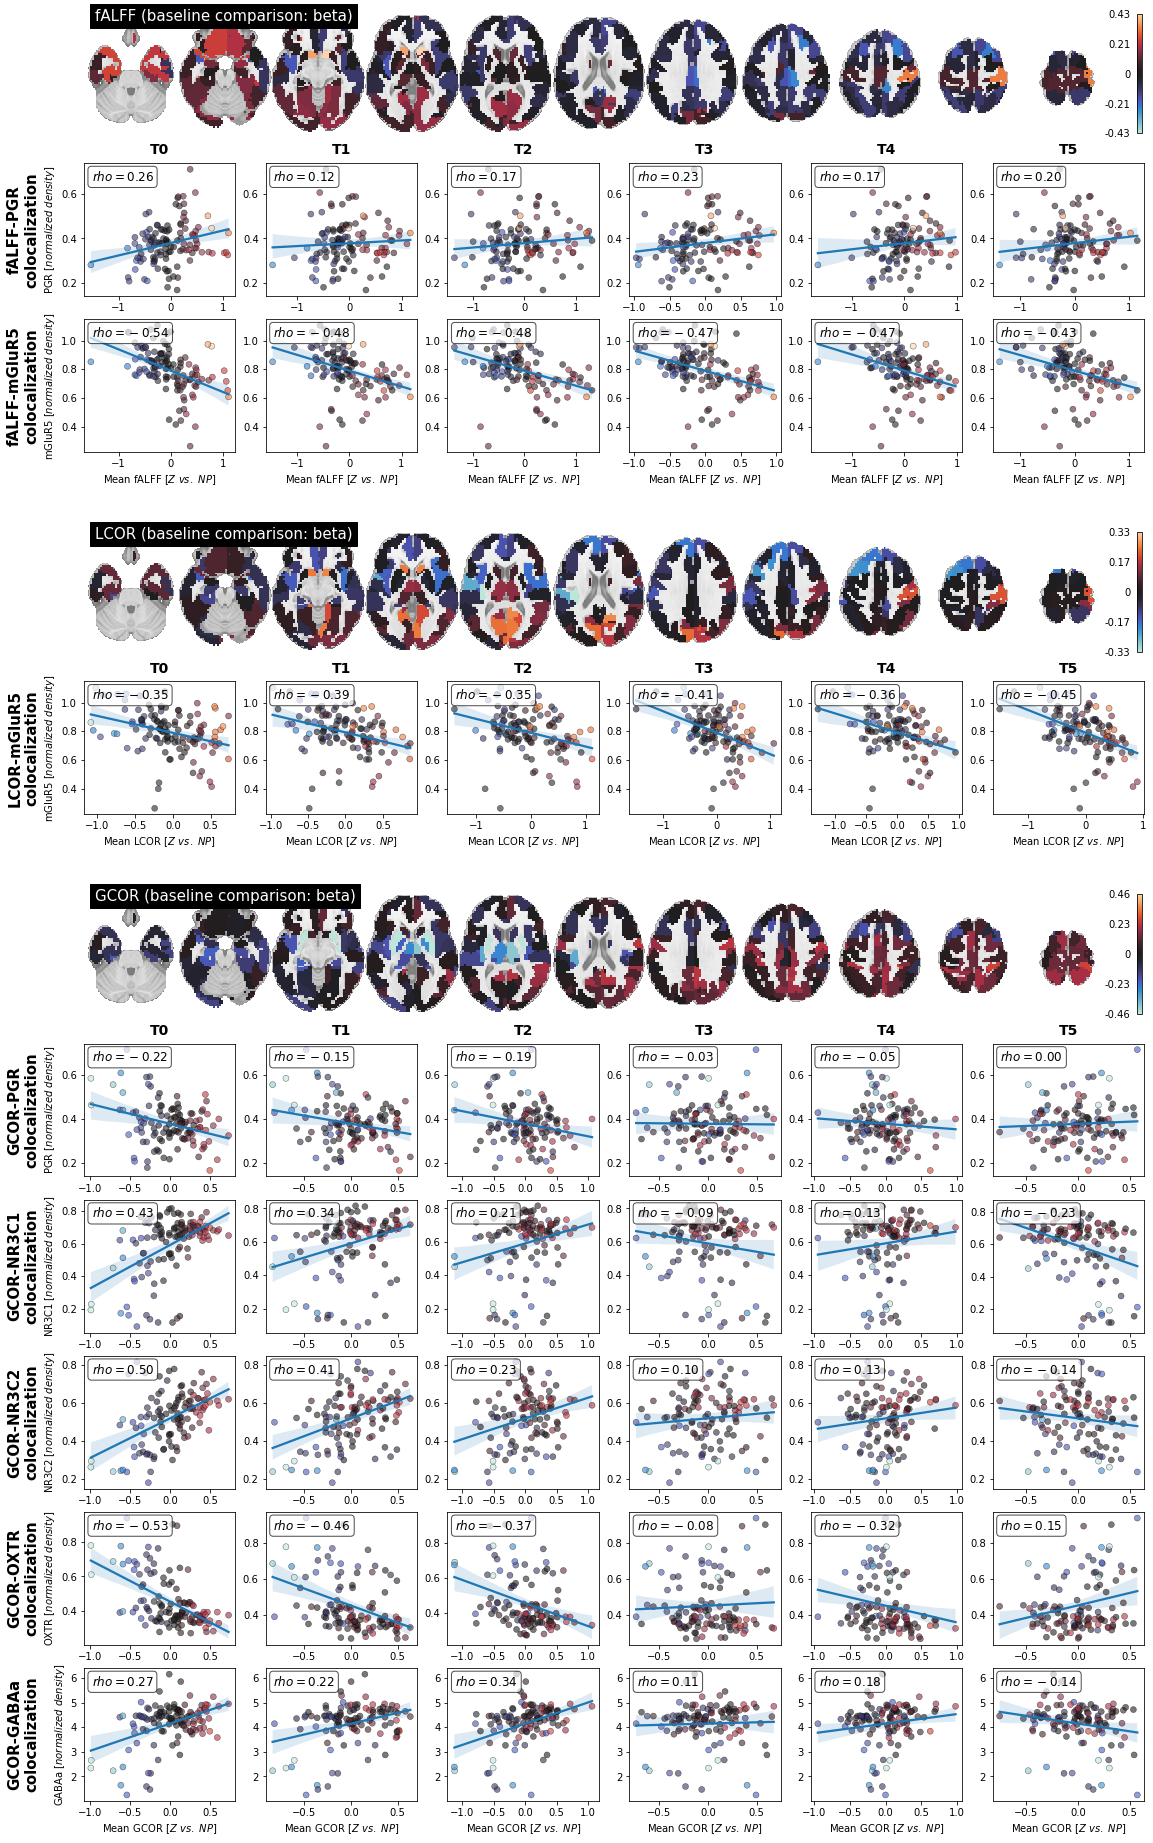

In [69]:
temp = spc_cross[spc_cross.loc[:, ("T0", "q(norm)")] < 0.05]
measures = temp.index.get_level_values("Measure").unique()

fig = plt.figure(figsize=(19,33))
gs = GridSpec(temp.shape[0] + len(measures) + len(measures)-1, len(tps), hspace=0.2, height_ratios=[1]*3 + [0.2, 1, 1, 0.2] + [1]*6)

## BRAINS
parcellater = NiftiLabelsMasker(parc, parc_labels).fit()
temp_mri = pd.DataFrame(
    {m: parcellater.transform(sec_level_res[m.lower()]["con1"]["map_par_effectsize"]).squeeze() for m in measures},
    index=parc_labels
)
for r, m in zip([0, 4, 7], measures):
    ax = fig.add_subplot(gs[r,:])
    plot_stat_map(
        parcel_data_to_volume(temp_mri[m], parc)[0],
        cut_coords=np.arange(-30,71,10),
        display_mode="z",
        cmap="icefire",
        vmax=temp_mri[m].abs().max(),
        symmetric_cbar=True,
        axes=ax,
        title=m+" (baseline comparison: beta)",
        annotate=False,
    )
    
## DISTANCE PLACEHOLDER
for r in [3,6]:
    ax = fig.add_subplot(gs[r,:])
    ax.set_axis_off()

## SCATTERS
for r, (m, receptor) in zip([1,2, 5, 8,9,10,11,12], temp.index):
    
    temp_z = pd.read_csv(join(wd, "results", f"spc_pp_data_{m}.csv"), index_col=[0,1,2])
    temp_z = (temp_z.loc[(subs_PP, na(), "PP"), :] - temp_z.loc[(subs_NP, na(), "NP"), :].mean()) / temp_z.loc[(subs_NP, na(), "NP"), :].std()
    temp_z = temp_z.groupby("idx_tp").mean().T
    
    for c, tp in enumerate(tps):
        ax = fig.add_subplot(gs[r,c])
        
        sns.regplot(
            x=temp_z[tp],
            y=pred_aba_pet[receptor],
            scatter=False,
            ax=ax
        ) 
        sns.scatterplot(
            x=temp_z[tp],
            y=pred_aba_pet[receptor],
            hue=temp_mri[m],
            legend=False,
            palette="icefire",
            hue_norm=(-temp_mri[m].abs().max(), temp_mri[m].abs().max()),
            edgecolor="k",
            alpha=0.6,
            ax=ax
        )
        ax.annotate(
            f"$rho = {corr(pred_aba_pet[receptor], temp_z[tp], rank=True):.02f}$",
            xy=(0.05,0.95), 
            xycoords="axes fraction", 
            ha="left", va="top",
            size=12,
            bbox=dict(boxstyle="round", fc="w", alpha=0.7)
        )
        
        if r in [2, 5, 12]:
            ax.set_xlabel(f"Mean {m} $[Z\ vs.\ NP]$")
        else:
            ax.set_xlabel("")
        
        if c==0:
            ax.set_ylabel(f"{receptor} $[normalized\ density]$")
            ax.annotate(
                f"{m}-{receptor}\ncolocalization", 
                xy=(-0.4,0.5), 
                xycoords="axes fraction", 
                rotation=90,
                size=15, weight="semibold", ha="center", va="center"
            )
        else:
            ax.set_ylabel("")
            
        if r in [1, 5, 8]:
            ax.set_title(tp, weight="semibold", size=14, pad=9)
        else:
            ax.set_title("")

fig.savefig(join(wd, "plots", "figS5_spatial_correlation_scatters.pdf"), bbox_inches="tight", dpi=300)
fig.savefig(join(wd, "plots", "figS5_spatial_correlation_scatters.png"), bbox_inches="tight", dpi=300)

### Longitudinal associations

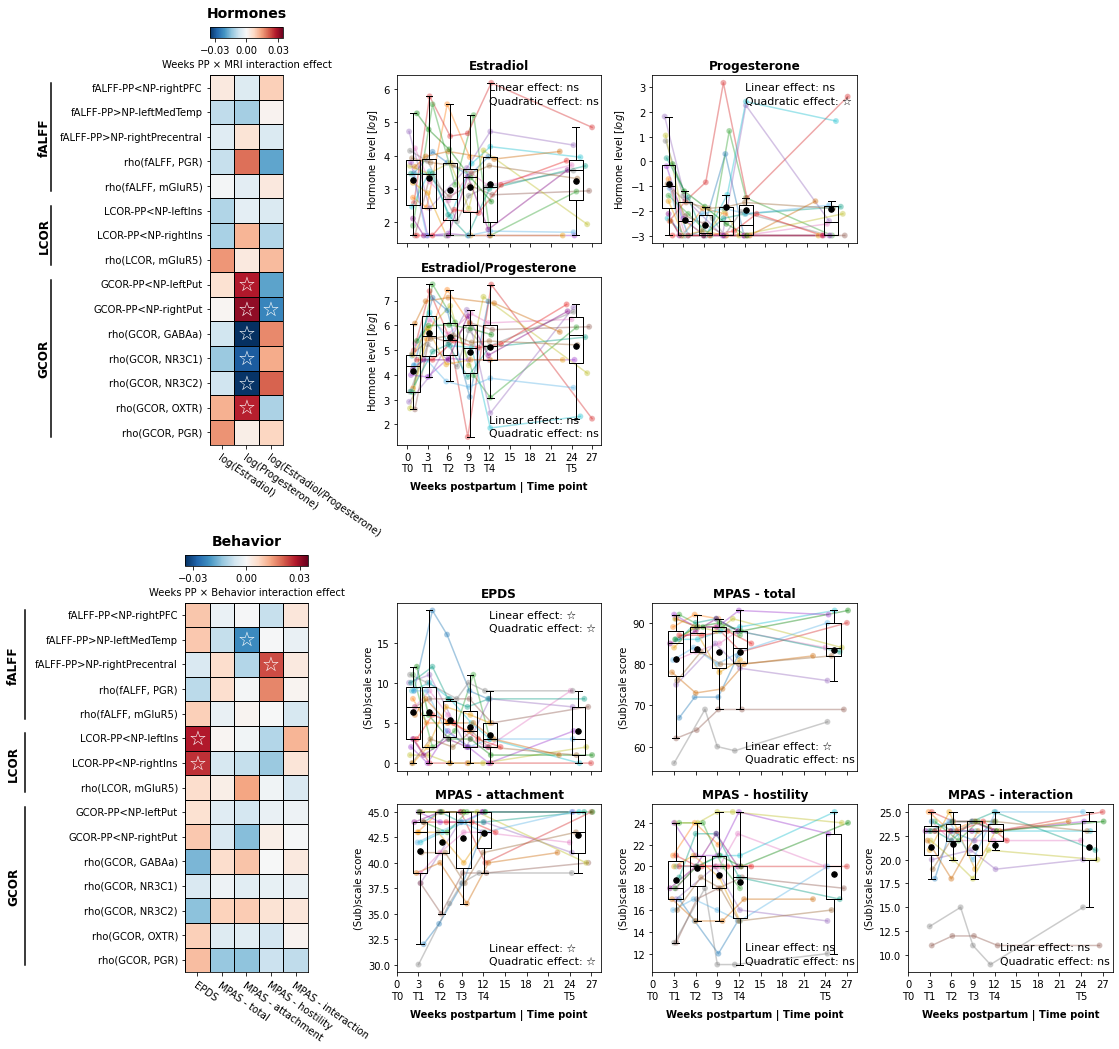

In [70]:
fig = plt.figure(figsize=(18, 16.5))
gs = GridSpec(4, 4, figure=fig,
              width_ratios=(1.2,1,1,1),
              hspace=1.5, wspace=0.05)


## HEATMAPS
y_labs = assoc_behav[("Interaction", "coef")].index.get_level_values("X").unique()
y_labs = [c for c in y_labs if "fALFF" in c] + [c for c in y_labs if "LCOR" in c] + [c for c in y_labs if "GCOR" in c]
lim = np.max(np.abs(assoc_behav[("Interaction", "coef")].to_list() + assoc_horm[("Interaction", "coef")].to_list()))

for i, (title, ax, x_labs, coef, p, q) in enumerate(zip(
    ["Hormones", "Behavior"],
    [fig.add_subplot(gs[:2,0]), fig.add_subplot(gs[2:4,0])],
    [['log(Estradiol)', 'log(Progesterone)', 'log(Estradiol/Progesterone)'],
     ['EPDS', 'MPAS - total', 'MPAS - attachment', 'MPAS - hostility', 'MPAS - interaction']],
    [assoc_horm[("Interaction", "coef")].reset_index().pivot(columns="X", index="Y"),
     assoc_behav[("Interaction", "coef")].reset_index().pivot(columns="Y", index="X")],
    [assoc_horm[("Interaction", "p")].reset_index().pivot(columns="X", index="Y"),
     assoc_behav[("Interaction", "p")].reset_index().pivot(columns="Y", index="X")],
    [assoc_horm[("Interaction", "q")].reset_index().pivot(columns="X", index="Y"),
     assoc_behav[("Interaction", "q")].reset_index().pivot(columns="Y", index="X")]
)):

    annot = p.copy().astype(str)
    annot[p <= 0.05] = "☆"
    annot[p > 0.05] = ""
    annot[q <= 0.05] = "★"
    
    ax_cbar = ax.inset_axes((0,1.1,1,0.03))
    sns.heatmap(
        data=coef.loc[y_labs, (na(), na(), x_labs)],
        cmap="RdBu_r",
        vmin=-lim,
        vmax=lim,
        center=0,
        ax=ax,
        cbar=True, 
        cbar_ax=ax_cbar,
        cbar_kws=dict(label=f"Weeks PP × {'MRI' if title=='Hormones' else title} interaction effect", 
                      orientation="horizontal"),
        square=True,
        linewidths=1,
        linecolor="k",
        annot=annot.loc[y_labs, (na(), na(), x_labs)],
        fmt="s",
        annot_kws=dict(size=20, ha="center", va="center", fontweight="bold")
    )
    ax_cbar.set_xticks([-0.03, 0, 0.03])
    
    ax_cbar.spines["outline"].set(visible=True, lw=.8, edgecolor="black")
    sns.despine(top=False, right=False, bottom=False, left=False)
    ax.set_title(title, weight="semibold", size=14, pad=10)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticklabels(x_labs, rotation=-35, ha="left", rotation_mode="anchor")

    ax_lab = ax.inset_axes((-2.2 if title=="Hormones" else -1.35, 0,0.1,1))
    ax_lab.set_ylim(ax.get_ylim())
    ax_lab.set_axis_off()
    n_falff = len([c for c in y_labs if "fALFF" in c])
    n_lcor = len([c for c in y_labs if "LCOR" in c])
    n_gcor = len([c for c in y_labs if "GCOR" in c])
    for r, m in zip([(0.5, n_falff-0.5), 
                    (n_falff+0.5, n_falff+n_lcor-0.5), 
                    (n_falff+n_lcor+0.5, n_falff+n_lcor+n_gcor+-0.5)], 
                    metrics):
        ax_lab.plot([0,0], [r[0]-0.2, r[1]+0.2], c="k")
        ax_lab.text(s=m, x=-0.1, y=np.mean(r), rotation=90, va="center", ha="center", size=12, weight="semibold")
        
        
## DEVELOPMENT
gs_horm = GridSpecFromSubplotSpec(2, 3, subplot_spec=gs[:2,1:], wspace=0.25)
gs_behav = GridSpecFromSubplotSpec(2, 3, subplot_spec=gs[2:4,1:], wspace=0.25)

for r, (y_labs, y_vars, axes, sig_locs) in enumerate(zip(
    [['Estradiol', 'Progesterone', 'Estradiol/Progesterone'],
     ['EPDS', 'MPAS - total', 'MPAS - attachment', 'MPAS - hostility', 'MPAS - interaction']],
    [["estradiol_log", "progesterone_log", "ep_ratio_log"], 
     ["epds",  "mpas", "mpas_attachment", "mpas_hostility", "mpas_interaction"]],
    [[fig.add_subplot(loc) for loc in [gs_horm[0,0], gs_horm[0,1], gs_horm[1,0]]],
     [fig.add_subplot(loc) for loc in [gs_behav[0,0], gs_behav[0,1], gs_behav[1,0], gs_behav[1,1], gs_behav[1,2]]]],
    [["top", "top", "bottom"],
     ["top", "bottom", "bottom", "bottom", "bottom"]]
)):
    
    for c, (y, y_lab, ax, sig_loc) in enumerate(zip(y_vars, y_labs, axes, sig_locs)):
        
        temp = data_spc.loc[(subs_PP_long, na(), "PP"), [y, "weeks_postpartal", "ID"]].dropna()

        sns.scatterplot(
            temp,
            x="weeks_postpartal",
            hue="ID",
            y=y,
            ax=ax,
            legend=None,
            alpha=0.4,
            zorder=3,
            palette=colors
        )
        sns.lineplot(
            temp,
            x="weeks_postpartal",
            y=y,
            hue="ID",
            ax=ax,
            legend=None,
            alpha=0.4,
            zorder=2,
            palette=colors
        )
        temp_mean = temp.groupby("idx_tp").mean()
        temp_max = temp.groupby("idx_tp").max()
        for tp in temp.index.get_level_values("idx_tp").unique():   
            ax.boxplot(
                x=temp.loc[(subs_PP_long, tp, "PP"), y],
                positions=[temp_mean.loc[tp, "weeks_postpartal"]],
                widths=2,
                zorder=10,
                showfliers=False,
                medianprops=dict(c="k")
            )
            ax.scatter(
                y=temp_mean.loc[tp, y],
                x=temp_mean.loc[tp, "weeks_postpartal"],
                zorder=11,
                c="k",
                s=30
            )     
        
        # LMM
        for var in ["Weeks PP", "Weeks PP^2"]:
            p = dem_data_long.loc[y_lab if r==1 else f"log({y_lab})", (var, "p")]
            if p < 0.05: s = "☆"
            else: s = "ns"
            ax.annotate(
                f"{'Linear' if var=='Weeks PP' else 'Quadratic'} effect: {s}",
                xy=(0.45, (0.05 if sig_loc == "bottom" else 0.83) + (0.08 if var=='Weeks PP' else 0)),
                xycoords="axes fraction",
                size=11
            )
                
        ax.set_title(y_lab, size=12, fontweight="semibold")
        ax.set_xticks(list(range(0,28,3)))
        if any(s in y_lab.lower() for s in ["mpas", "epds"]):
            ax.set_ylabel("(Sub)scale score")
        else:
            ax.set_ylabel("Hormone level $[log]$")

        if ax.get_subplotspec().is_last_row():
            ax.set_xticklabels(["0\nT0", "3\nT1", "6\nT2", "9\nT3", "12\nT4", "15", "18", "21", "24\nT5", "27"])
            ax.set_xlabel("Weeks postpartum | Time point", weight="semibold", labelpad=8)
        else:
            ax.set_xticklabels([])
            ax.set_xlabel("")


fig.savefig(join(wd, "plots", "fig4_hormone_behavior.pdf"), bbox_inches="tight")
fig.savefig(join(wd, "plots", "fig4_hormone_behavior.png"), bbox_inches="tight", dpi=300)

### RTM sensitivity

/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
/Users/llotter/opt/anaconda3/envs/pprs/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = getattr(ax, type)(data_2d.copy(),


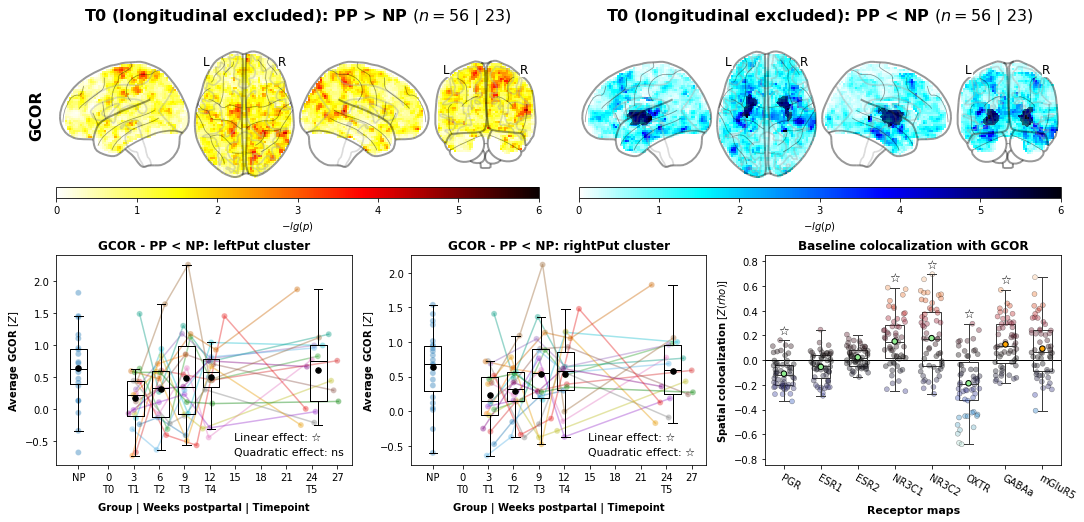

In [72]:
fig = plt.figure(figsize=(18,8))
gs = GridSpec(2, 3, figure=fig, 
              width_ratios=(1,1,1), height_ratios=(0.8,1),
              hspace=0.3, wspace=0.2)

# GLM brains
ax_brain = fig.add_subplot(gs[0,:])
ax_brain.set_axis_off()
ax_brain_con1 = ax_brain.inset_axes((0,0,0.48,1))
ax_brain_con2 = ax_brain.inset_axes((0.52,0,0.48,1))

vmin = 0
vmax = 6

for con, ax in zip(["con1", "con2"], [ax_brain_con1, ax_brain_con2]):
    
    map_unthresh = sec_level_res_rtm["gcor"][con]["map_par_logp"]
    map_thresh = sec_level_res_rtm["gcor"][con]["map_nonpar_logp"]
        
    # plot main glass brain
    gb = plot_glass_brain(
        map_unthresh, 
        display_mode="lzry",
        alpha=0.4,
        colorbar=False, 
        cmap="cold_white_hot" if con=="con1" else "cold_white_hot_r",
        figure=fig,
        axes=ax,
        vmin=vmin,
        vmax=vmax
    )
        
    # significant cluster
    if (map_thresh.get_fdata() > cl_thresh).any():
        
        # plot overlays
        gb.add_contours(
            img=threshold_img(map_thresh, cl_thresh), 
            levels=[1], 
            colors="k", 
            linewidth=5,
            filled=True,
            alpha=0.5
        )
    
    # titles
    ax.set_title(f"T0 (longitudinal excluded): PP {'>' if con=='con1' else '<'} NP $(n = {data.loc[(subs_rtm,'T0','PP'),:].shape[0]}\ |\ "
                    f"{data.loc[(subs_rtm,'T0','NP'),:].shape[0]})$", 
                    size=16, weight="semibold", pad=10)
    if con=="con1": 
        ax.annotate(
            "GCOR", 
            xy=(-0.04,0.5), 
            xycoords="axes fraction", 
            rotation=90,
            size=16, weight="semibold", ha="center", va="center"
        )
    
    # colorbar
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(
        cmap="black_red_r" if con=="con1" else "black_blue_r", 
        norm=norm)
    sm.set_array([])
    plt.colorbar(
        sm,
        label=r"$-lg(p)$",
        orientation="horizontal",
        cax=ax.inset_axes((0,0,1,0.07)),
    )
    

# Cluster development

ax_clust1 = fig.add_subplot(gs[1,0])
ax_clust2 = fig.add_subplot(gs[1,1])

for (lab, measure, contrast, name), ax in zip(cl_iter_rtm, [ax_clust1, ax_clust2]):
    
    temp_mri = pd.concat(
        [data.loc[(subs_NP, ), :].melt(["ID", "group_str", "weeks_postpartal"], lab)] + \
        [data.loc[(subs_PP_long, tp), :].melt(["ID", "group_str", "weeks_postpartal"], lab).replace({"PP": f"PP-{tp}"}) for tp in ["T1", "T2", "T3", "T4", "T5"]]
    )
    temp_mri.loc[temp_mri.group_str=="NP", "weeks_postpartal"] = -3.5

    sns.scatterplot(
        temp_mri,
        x="weeks_postpartal",
        hue="ID",
        y="value",
        ax=ax,
        legend=None,
        alpha=0.4,
        zorder=3,
        palette=colors
    )
    sns.lineplot(
        temp_mri,
        x="weeks_postpartal",
        y="value",
        hue="ID",
        ax=ax,
        legend=None,
        alpha=0.4,
        zorder=2,
        palette=colors
    )
    
    for group in temp_mri.group_str.unique():   

        ax.boxplot(
            x=temp_mri.loc[temp_mri.group_str==group, "value"],
            positions=[temp_mri.loc[temp_mri.group_str==group, "weeks_postpartal"].mean()],
            widths=2,
            zorder=10,
            showfliers=False,
            medianprops=dict(c="k")       
        )
        ax.scatter(
            y=[temp_mri.loc[temp_mri.group_str==group, "value"].mean()],
            x=[temp_mri.loc[temp_mri.group_str==group, "weeks_postpartal"].mean()],
            zorder=11,
            c="k",
            s=30
        )
    
    # LMM
    for var in ["Weeks PP", "Weeks PP^2"]:
        p = mri_long_lmm_rtm.loc[(measure, contrast, name), (var, "-lg(p)")]
        if p > -np.log10(0.05): s = "☆"
        else: s = "ns"
        ax.annotate(
            f"{'Linear' if var=='Weeks PP' else 'Quadratic'} effect: {s}",
            xy=(0.6, 0.05 + (0.07 if var=='Weeks PP' else 0)),
            xycoords="axes fraction",
            size=11
        )
    
    # Labels
    ax.set_title(f"{measure} - {contrast}: {name} {'cluster' if measure!='NBS' else 'average connectivity'}", weight="semibold")
    ax.set_ylabel(f"Average {measure if measure!='NBS' else 'network connectivity'} $[Z]$", weight="semibold")
    ax.set_xticks([-3.5] + list(range(0,28,3)))
    ax.set_xticklabels(["NP", "0\nT0", "3\nT1", "6\nT2", "9\nT3", "12\nT4", "15", "18", "21", "24\nT5", "27"])
    ax.set_xlabel("Group | Weeks postpartal | Timepoint", weight="semibold", labelpad=8)
    

# SPC at baseline

ax_spc = fig.add_subplot(gs[1,2])
temp = spc_zr_rtm.loc[(na(), "T0", "PP"),:].reset_index().melt(id_vars="idx_metric", value_vars=spc_zr_rtm.columns)

sns.stripplot(
    temp,
    x="variable",
    hue="value",
    y="value",
    dodge=False,
    ax=ax_spc,
    palette="icefire",
    edgecolor="k",
    linewidth=0.5,
    jitter=0.3,
    legend=None,
    alpha=0.4,
    zorder=1
)
sns.boxplot(
    temp,
    x="variable",
    #hue="variable",
    y="value",
    ax=ax_spc,
    fliersize=0,
    width=0.5,
    boxprops=dict(facecolor="none"),
    zorder=2,
    linewidth=1,
)
receptors = [l.get_text() for l in ax_spc.get_xticklabels()]
ax_spc.scatter(
    x=receptors,
    y=temp[temp.idx_metric=="gcor"].groupby("variable").mean().loc[receptors],
    zorder=20,
    c=["orange" if r in pred_pet.columns else "lightgreen" for r in receptors],
    s=30,
    ec="k"
) 

for x, r in enumerate(spc_zr_rtm.columns):
    
    if spc_sig_rtm[r].values[0] < 0.05: s = "☆"
    else: s = ""
    ax_spc.text(
        s=s, 
        x=x, 
        y=spc_zr_rtm.loc[(na(), "T0", "PP", "gcor"), r].max() + 0.08, 
        ha="center", va="center", size=12
    )  
        
ax_spc.axhline(c="k", zorder=0, lw=1)
ax_spc.set_xticks(ax_spc.get_xticks())
ax_spc.set_xticklabels(ax_spc.get_xticklabels(), rotation=-30, rotation_mode="anchor", ha="left")
ax_spc.set_ylim(-0.85,0.85)
ax_spc.set_xlabel("Receptor maps", weight="semibold", size=11)
ax_spc.set_ylabel("Spatial colocalization $[Z(rho)]$", weight="semibold")
ax_spc.set_title("Baseline colocalization with GCOR", weight="semibold")

fig.savefig(join(wd, "plots", "figS2_rtm_sensitivity.pdf"), bbox_inches="tight")
fig.savefig(join(wd, "plots", "figS2_rtm_sensitivity.pdf"), bbox_inches="tight", dpi=400)

## Save notebook to HTML

In [75]:
!!jupyter nbconvert 3_results_analyses_plots.ipynb --to html

['[NbConvertApp] Converting notebook 3_results_analyses_plots.ipynb to html',
 '[NbConvertApp] Writing 8094745 bytes to 3_results_analyses_plots.html']